# Libraries

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FuncFormatter
# from wordcloud import WordCloud
# import itertools
# import matplotlib as mpl
# from zipfile import ZipFile
# plt.style.use(['default'])

In [1]:
import numpy as np
from scipy.stats import chi2_contingency

# Consts

In [91]:
# Lookup dict from general emotions to sentiment grouping
sentiment_lookup = {
    'sentiment_positive':['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief'],
    'sentiment_negative':['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness'],
    'sentiment_ambiguous':['confusion', 'curiosity', 'realization', 'surprise'],
    'sentiment_neutral':['neutral']
}

# Lookup dict from sentiment grouping to general emotions
emotion2sentiment = {
    'admiration':'sentiment_positive', 
    'amusement':'sentiment_positive',
    'anger':'sentiment_negative',
    'annoyance':'sentiment_negative',
    'approval':'sentiment_positive',
    'caring':'sentiment_positive',
    'confusion':'sentiment_ambiguous',
    'curiosity':'sentiment_ambiguous',
    'desire':'sentiment_positive',
    'disappointment':'sentiment_negative',
    'disapproval':'sentiment_negative',
    'disgust':'sentiment_negative',
    'embarrassment':'sentiment_negative',
    'excitement':'sentiment_positive',
    'fear':'sentiment_negative',
    'gratitude':'sentiment_positive',
    'grief':'sentiment_negative',
    'joy':'sentiment_positive',
    'love':'sentiment_positive',
    'nervousness':'sentiment_negative',
    'optimism':'sentiment_positive',
    'pride':'sentiment_positive',
    'realization':'sentiment_ambiguous',
    'relief':'sentiment_positive',
    'remorse':'sentiment_negative',
    'sadness':'sentiment_negative',
    'surprise':'sentiment_ambiguous',
    'neutral':'sentiment_neutral'
}

# Lookup dict from general emotions to ekman groupng
ekman_lookup = {
    'ekman_joy':['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief'],
    'ekman_anger':['anger', 'annoyance', 'disapproval'],
    'ekman_disgust':['disgust'],
    'ekman_fear':['fear', 'nervousness'],
    'ekman_sadness':['disappointment', 'embarrassment', 'grief', 'remorse', 'sadness'],
    'ekman_surprise':['confusion', 'curiosity', 'realization', 'surprise'],
    'ekman_neutral':['neutral']
}

# Lookup dict from topics to themes
theme2topic = {
    'Authorities': [3,4,11,12,15],
    'Daily Life Impact': [0,6,22],
    'Preventive measures': [8,13,17,20,21],
    'Outbreak and Variants': [1,9],
    'Cases and deaths': [14,19],
    'Breaking News': [2],
    'Vaccination': [16,18],
    'Education': [5],
    'Medical Care': [7],
    'Economy': [10]
}

# Lookup dict from topics to themes
topic2theme = {
    0:'Daily Life Impact',
    1:'Outbreak and Variants',
    2:'Breaking News',
    3:'Authorities',
    4:'Authorities',
    5:'Education',
    6:'Daily Life Impact',
    7:'Medical Care',
    8:'Preventive measures',
    9:'Outbreak and Variants',
    10:'Economy',
    11:'Authorities',
    12:'Authorities',
    13:'Preventive measures',
    14:'Cases and deaths',
    15:'Authorities',
    16:'Vaccination',
    17:'Preventive measures',
    18:'Vaccination',
    19:'Cases and deaths',
    20:'Preventive measures',
    21:'Preventive measures',
    22:'Daily Life Impact'    
}

# List of emotions
emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 
    'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

# List of tweet features besides emotions
comment_columns = [
    'tweet_id', 'conversation_id', 'author_id', 'in_reply_to_user_id', 'is_quote', 'created_at', 'geo',
    'lang', 'like_count', 'quote_count', 'reply_count', 'retweet_count', 'source', 'text'
]

# Load comments and News

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt

# Get and process news -- uncomment this if generating news data frame
# news = pd.read_parquet('./../data/raw/news_tweets_em_scores.parquet')
# news_accounts = pd.read_csv('./../data/raw/news_accounts.csv')
# news_topics = pd.read_csv('./../data/processed/news_tweets_topics_290322.csv')
# news = news.merge(news_accounts[['author_id', 'country']])
# news = news.merge(news_topics[['tweet_id', 'num_topic']])
# news['created_at'] = pd.to_datetime(news.created_at, utc=True)
# news['emotion'] = news[emotions].idxmax(axis=1).values
# news['score'] = news[emotions].max(axis=1)
# news = news.drop(emotions, axis=1)
# news = news.sort_values('created_at').drop_duplicates('conversation_id', keep='first')
# news.to_csv('./../data/processed/news.csv', index=False)

# Get and process comments -- uncomment this if generating comments data frame
# comments_emotions = pd.read_parquet('./../data/raw/tweets_replies_em_scores.parquet', columns=emotions)
# comments_scores = comments_emotions.max(axis=1)
# comments_emotions = comments_emotions.idxmax(axis=1).values
# comments = pd.read_parquet('./../data/raw/tweets_replies_em_scores.parquet', columns=comment_columns)
# comments['emotion'] = comments_emotions
# comments['score'] = comments_scores
# comments = comments.merge(news.rename(
#     columns={'created_at':'news_at', 'emotion':'news_emotion', 'score':'news_score', 'num_topic':'topic'}
# )[['conversation_id', 'news_at', 'news_emotion', 'news_score', 'topic', 'country']])
# comments = comments.sort_values('created_at').drop_duplicates('tweet_id', keep='first')
# comments.to_csv('./../data/processed/comments.csv', index=False)

# Read comments and news dataframes
comments = pd.read_csv('./../data/processed/comments.csv')
news = pd.read_csv('./../data/processed/news.csv')

# Prepare comments dataframe to create figures
comments['news_at'] = pd.to_datetime(comments.news_at, utc=True)
comments['ds'] = comments.news_at.dt.date
comments['dsw'] = (comments['news_at'] + pd.offsets.Week(weekday=6)).dt.date
comments['dsm'] = pd.to_datetime(
    comments.news_at.dt.year.astype(str) + '-' + comments.news_at.dt.month.astype(str) + '-1'
)

# Create daily, weekly and montly comments consolidated view per emotion
monthly_emotions = comments.groupby('dsm').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='dsm', columns='emotion', values='emotion_prop')
weekly_emotions = comments.groupby('dsw').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='dsw', columns='emotion', values='emotion_prop')
daily_emotions = comments.groupby('ds').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='ds', columns='emotion', values='emotion_prop')
daily_emotions.index = pd.to_datetime(daily_emotions.index)
weekly_emotions.index = pd.to_datetime(weekly_emotions.index)
monthly_emotions.index = pd.to_datetime(monthly_emotions.index)

# Check available plt styles -- uncoment to check
# plt.style.available

# Include theme to the comments dataset
comments['theme'] = comments.topic.apply(lambda x: topic2theme[x])

# Include sentiment
comments = comments[~comments.emotion.isnull()]
comments['sentiment'] = comments.emotion.apply(lambda x: emotion2sentiment[x])

# Topic Analysis

In [4]:
import gensim
import pickle
from gensim.test.utils import datapath

# Load LDA model results
temp_file = datapath("topic_model_290322")
ldamallet = gensim.models.wrappers.LdaMallet.load(temp_file)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

# Load dictionary
with open('dictionary.pkl', 'rb') as handle:
    dictionary = pickle.load(handle)

# Top words per topic
n_topics = len(comments.topic.value_counts())
df_words = pd.DataFrame([])
topic_words = pd.DataFrame(columns=['topic', 'words'])
for topic in range(n_topics):
    tmp = pd.DataFrame(model.get_topic_terms(topic,35), columns=['wordid','imp'])
    tmp['topic'] = topic
    tmp['word'] = tmp.wordid.apply(lambda x: dictionary[x])
    df_words = pd.concat([df_words, tmp])
    topic_words.loc[len(topic_words)] = [topic, (list(tmp.word.values))]
    
# Topic distribution per tweet
topic_details = pd.read_csv('./../data/processed/news_tweets_topics_290322.csv')

# Top tweets per topic -- uncomment this and select a topic number
# k = 14
# tmp = topic_details[topic_details.num_topic==k].sort_values('topic_'+str(k)).head(5).tweet_id.values
# news[(news.tweet_id.isin(tmp))].text.values

# Top terms per topic -- uncomment this and select a topic number

### Number of Topics

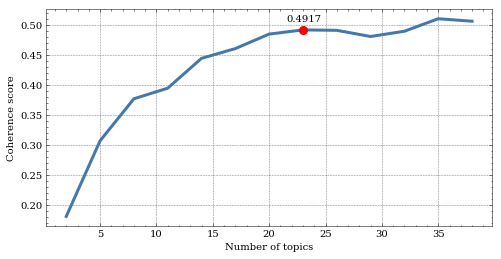

In [5]:
topics = [2,5,8,11,14,17,20,23,26,29,32,35,38]
coherence = [0.18111807889419942,
 0.3069857418245153,
 0.3770153075387129,
 0.3946363098394775,
 0.4443431511723297,
 0.4605954232303439,
 0.48470604721718813,
 0.4916932266272104,
 0.4909952406571094,
 0.4807049008608318,
 0.48947994444945814,
 0.5102746520337154,
 0.5061367752062007]

with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    fig, axs = plt.subplots(figsize=(8, 4))
    axs.set_ylabel('Coherence score')
    axs.set_xlabel('Number of topics')    
    axs.annotate('0.4917', xy=(21.5, .505))
    
    plt.plot(topics, coherence, linewidth=3, )
    plt.plot(23, 0.4917, 'ro', markersize=8, )

### Topics Keywords

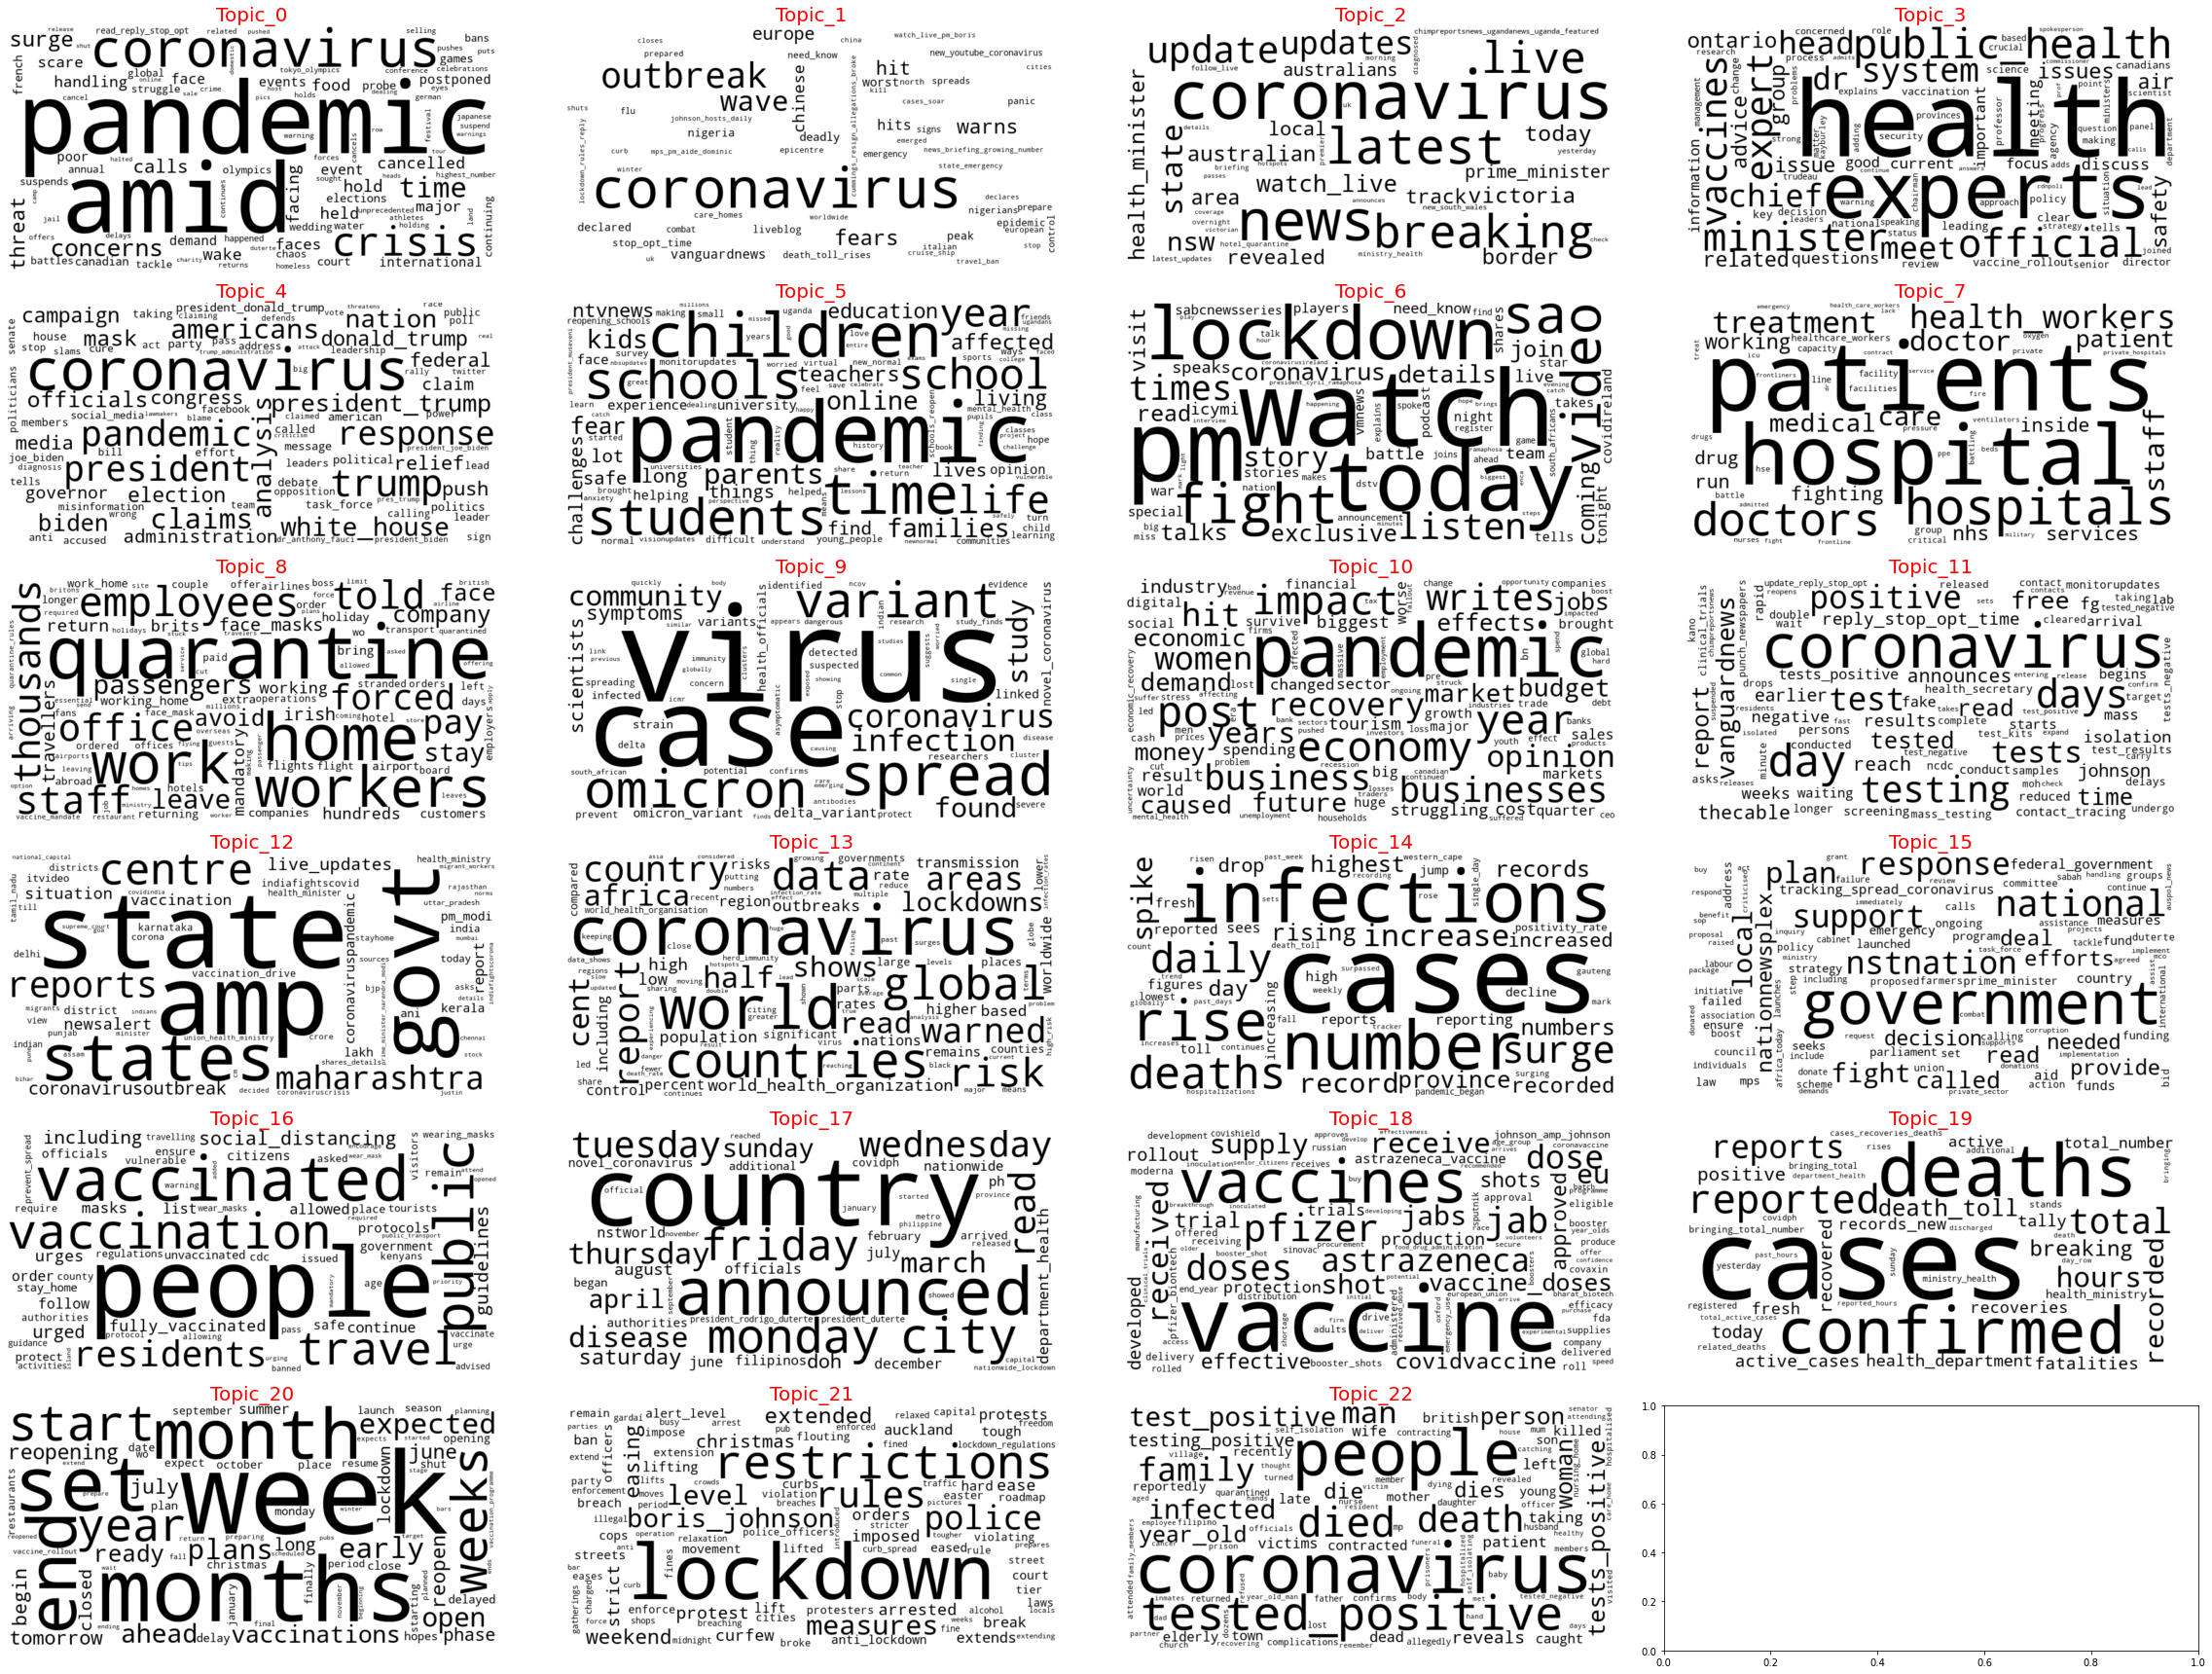

In [6]:
import numpy as np
from wordcloud import WordCloud

fig, axs = plt.subplots(int(np.ceil(n_topics/4)),4,figsize=(8*4, int(np.ceil(n_topics/4))*4))
for topic_number in range(n_topics):
    v = k = []
    for s in model.print_topic(topic_number,topn=100).replace('''"''', '').split(' + '):
        s = s.split('*')
        v = v + [float(s[0])]
        k = k + [s[1]]

    d = {}
    for cnt in range(len(v)):
        d[k[cnt]] = v[cnt]
    wordcloud = WordCloud(
        relative_scaling=.5, background_color='white', color_func=lambda *args, **kwargs: (0,0,0), random_state=13, min_font_size=10, width=800, height=400
    ).generate_from_frequencies(d)
    
    ax = axs[int(np.floor(topic_number/4))][topic_number%4]
    ax.set_title('Topic_' + str(topic_number), fontdict={'color':'red', 'fontsize':20})
    ax.axis("off")
    ax.imshow(wordcloud, interpolation='bilinear')
fig.tight_layout()

# News Outlet Wordcloud

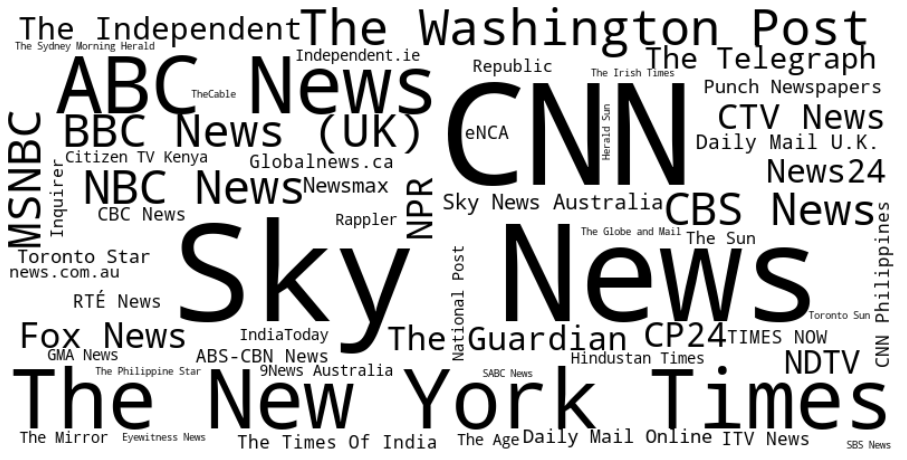

In [27]:
news_accounts = pd.read_csv('./../data/raw/news_accounts.csv')
n = comments.groupby('in_reply_to_user_id').tweet_id.count().reset_index().merge(news_accounts[['author_id', 'display_name']], left_on='in_reply_to_user_id', right_on='author_id')[['display_name', 'tweet_id']].groupby('display_name').tweet_id.sum().reset_index()
d = {}
for index, row in n.iterrows():
    d[row.display_name] = int(row.tweet_id)
wordcloud = WordCloud(
    relative_scaling=.5, background_color='white', color_func=lambda *args, **kwargs: (0,0,0), random_state=13, min_font_size=9, width=800, height=400
).generate_from_frequencies(d)

fig, ax = plt.subplots(1,1,figsize=(16, 10), sharex=True)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Global distribution of emotions

In [140]:
emotion_count = comments.emotion.value_counts(normalize=True)

### Sentiments

In [216]:
general_emotion = {}
for sentiment, emotion_group in sentiment_lookup.items():
    general_emotion[sentiment] = emotion_count[emotion_group].sum()
general_emotion = pd.DataFrame.from_dict(general_emotion, orient='index').reset_index()
general_emotion.columns = ['Emotion', 'Proportion']

In [217]:
general_emotion.Emotion = ['Positive', 'Negative', 'Ambiguous', 'Neutral']

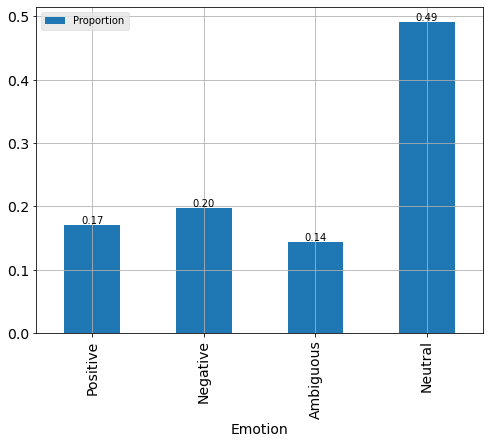

In [231]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(8, 6))
with plt.style.context(['ggplot']):   
    ax2 = general_emotion.plot.bar(x='Emotion', y='Proportion', rot=90, ax=ax, cmap=c1)
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f')

### Positive

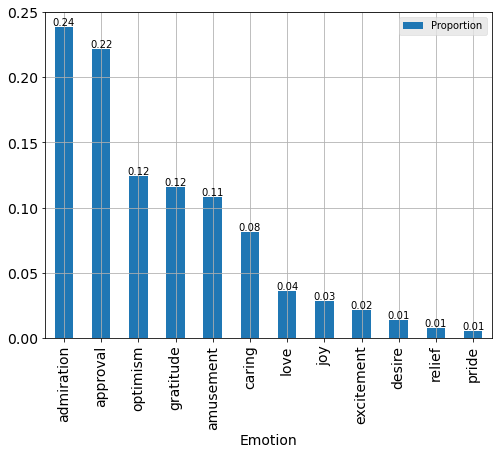

In [232]:
positive_emotion = emotion_count[sentiment_lookup['sentiment_positive']].sort_values(ascending=False).reset_index()
positive_emotion.columns = ['Emotion', 'Proportion']
positive_emotion.Proportion = positive_emotion.Proportion / positive_emotion.Proportion.sum()

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(8, 6),)
with plt.style.context(['ggplot']):   
    ax2 = positive_emotion.plot.bar(x='Emotion', y='Proportion', rot=90, ax=ax, cmap=c1)

    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f')

### Negative

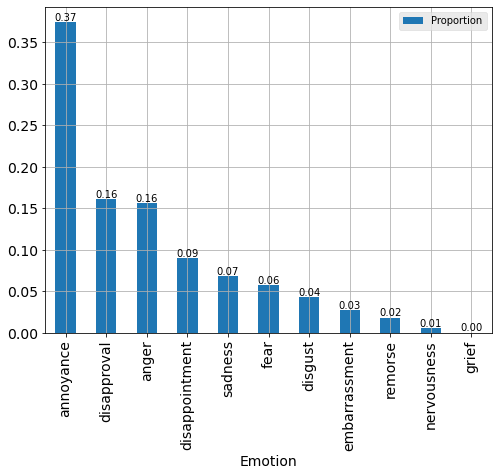

In [233]:
negative_emotion = emotion_count[sentiment_lookup['sentiment_negative']].sort_values(ascending=False).reset_index()
negative_emotion.columns = ['Emotion', 'Proportion']
negative_emotion.Proportion = negative_emotion.Proportion / negative_emotion.Proportion.sum()

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(8, 6),)
with plt.style.context(['ggplot']):   
    ax2 = negative_emotion.plot.bar(x='Emotion', y='Proportion', rot=90, ax=ax, cmap=c1)

    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f')

### Ambiguous

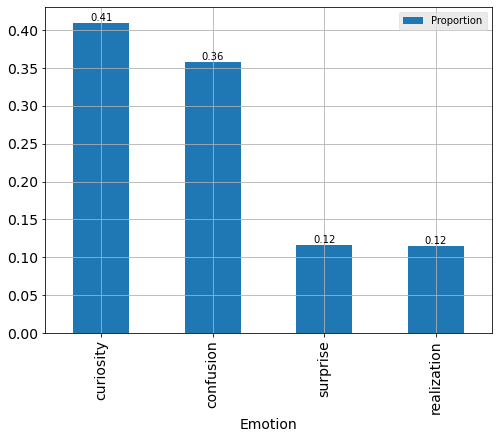

In [234]:
ambiguous_emotion = emotion_count[sentiment_lookup['sentiment_ambiguous']].sort_values(ascending=False).reset_index()
ambiguous_emotion.columns = ['Emotion', 'Proportion']
ambiguous_emotion.Proportion = ambiguous_emotion.Proportion / ambiguous_emotion.Proportion.sum()

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(8, 6),)
with plt.style.context(['ggplot']):   
    ax2 = ambiguous_emotion.plot.bar(x='Emotion', y='Proportion', rot=90, ax=ax, cmap=c1)

    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f')

# Distribution of emotions per day

In [144]:
def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    import matplotlib as mpl
    
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = mpl.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = mpl.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = mpl.colors.ListedColormap(cols)
    return cmap

# Define colormaps
c1 = categorical_cmap(3, 10, cmap="tab10")

### Daily sentiment -- 14-day avg

In [154]:
weekly_emotions.index = pd.to_datetime(weekly_emotions.index)
for s, v in sentiment_lookup.items():
    weekly_emotions[s] = weekly_emotions[v].sum(axis=1)
weekly_sentiments = weekly_emotions[sentiment_lookup.keys()]
sentiment_order = weekly_sentiments.sum(axis=0).sort_values(ascending=False).index

['sentiment_neutral', 'sentiment_negative', 'sentiment_positive', 'sentiment_ambiguous']


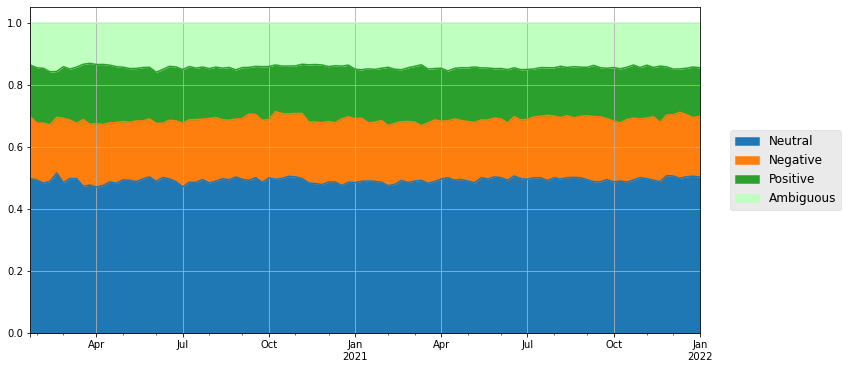

In [213]:
weekly_emotions.index = pd.to_datetime(weekly_emotions.index)
for s, v in sentiment_lookup.items():
    weekly_emotions[s] = weekly_emotions[v].sum(axis=1)
weekly_sentiments = weekly_emotions[sentiment_lookup.keys()]
sentiment_order = weekly_sentiments.sum(axis=0).sort_values(ascending=False).index

fig, ax = plt.subplots(1,1,figsize=(12, 6))
with plt.style.context(['ggplot']):    
    weekly_sentiments[sentiment_order].plot.area(ax=ax, cmap=c1)
    current_handles, current_labels = plt.gca().get_legend_handles_labels()
    plt.xlabel('')
    plt.rcParams.update({'font.size': 12})
    handles = list(current_handles)
    labels = list(current_labels)
    print(labels)
    ax.legend(handles, ['Neutral','Negative','Positive','Ambiguous'], loc='center right', bbox_to_anchor=(1.22, 0.5))

### Main emotions -- weekly

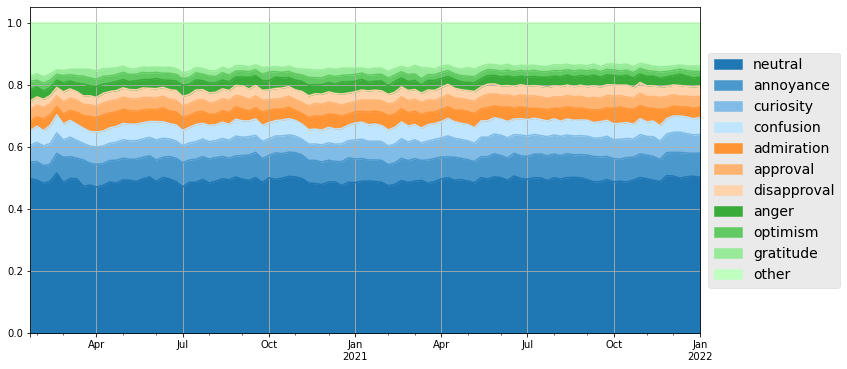

In [215]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
with plt.style.context(['ggplot']):
    main_emotions = weekly_emotions[emotion_count[:10].index]
    main_emotions['other'] = 1 - main_emotions.sum(axis=1)
    main_emotions[list(emotion_count[:10].index) + ['other']].plot.area(ax=ax, cmap=c1)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('')
    ax.legend(loc='center right', bbox_to_anchor=(1.22, 0.5))

### Daily positive emotions -- 14-day avg

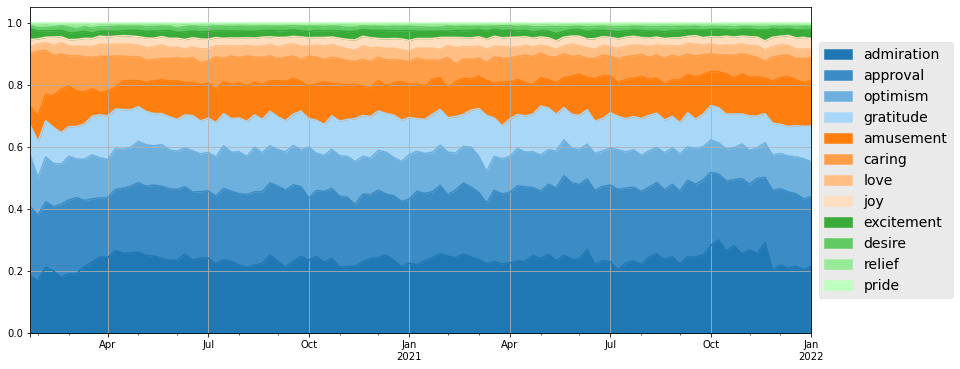

In [192]:
fig, ax = plt.subplots(1,1,figsize=(14, 6))
with plt.style.context(['ggplot']):
    positive_weekly_emotions = weekly_emotions[sentiment_lookup['sentiment_positive']]
    positive_weekly_emotions['sumaxis'] = positive_weekly_emotions.sum(axis=1)
    positive_weekly_emotions = positive_weekly_emotions.iloc[:,:-1].div(positive_weekly_emotions.sumaxis, axis=0)
    positive_order = emotion_count[sentiment_lookup['sentiment_positive']].sort_values(ascending=False).index
    positive_weekly_emotions[positive_order].plot.area(ax=ax, cmap=c1)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('')
    ax.legend(loc='center right', bbox_to_anchor=(1.19, 0.5))

### Daily negative emotions -- 14-day avg

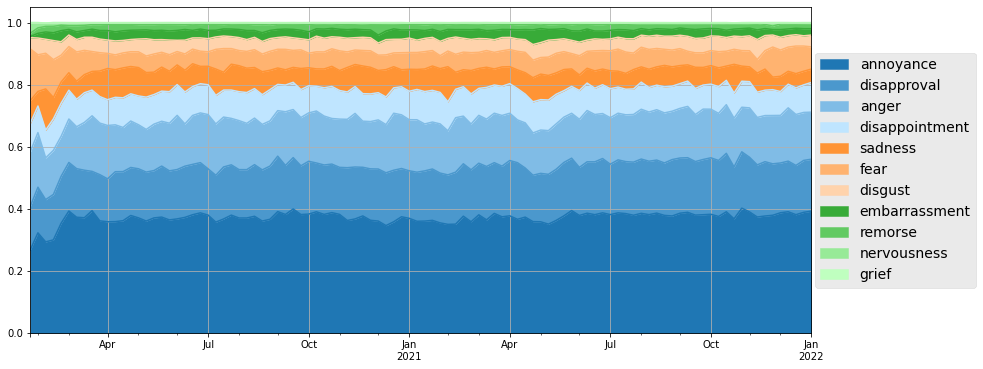

In [185]:
fig, ax = plt.subplots(1,1,figsize=(14, 6))
with plt.style.context(['ggplot']):
    positive_weekly_emotions = weekly_emotions[sentiment_lookup['sentiment_negative']]
    positive_weekly_emotions['sumaxis'] = positive_weekly_emotions.sum(axis=1)
    positive_weekly_emotions = positive_weekly_emotions.iloc[:,:-1].div(positive_weekly_emotions.sumaxis, axis=0)
    positive_order = emotion_count[sentiment_lookup['sentiment_negative']].sort_values(ascending=False).index
    positive_weekly_emotions[positive_order].plot.area(ax=ax, cmap=c1)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('')
    ax.legend(loc='center right', bbox_to_anchor=(1.22, 0.5))

### Daily ambiguous emotions -- 14-day avg

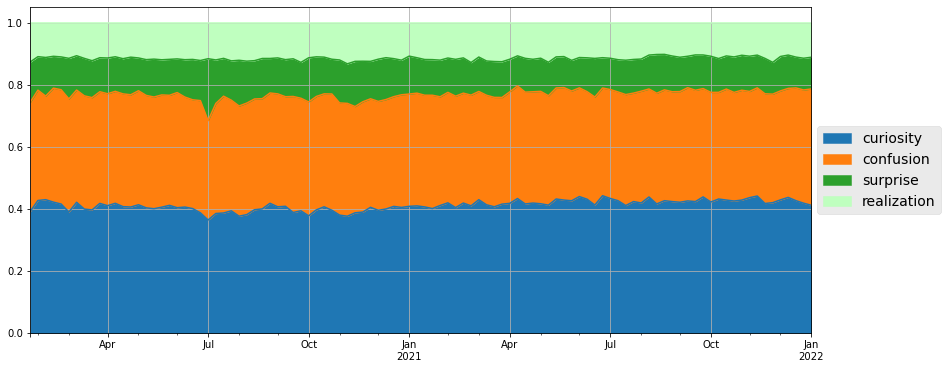

In [188]:
fig, ax = plt.subplots(1,1,figsize=(14, 6), sharex=True)
with plt.style.context(['ggplot']):
    positive_weekly_emotions = weekly_emotions[sentiment_lookup['sentiment_ambiguous']]
    positive_weekly_emotions['sumaxis'] = positive_weekly_emotions.sum(axis=1)
    positive_weekly_emotions = positive_weekly_emotions.iloc[:,:-1].div(positive_weekly_emotions.sumaxis, axis=0)
    positive_order = emotion_count[sentiment_lookup['sentiment_ambiguous']].sort_values(ascending=False).index
    positive_weekly_emotions[positive_order].plot.area(ax=ax, cmap=c1)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('')
    ax.legend(loc='center right', bbox_to_anchor=(1.175, 0.5))

### Daily ekman -- 14-day avg

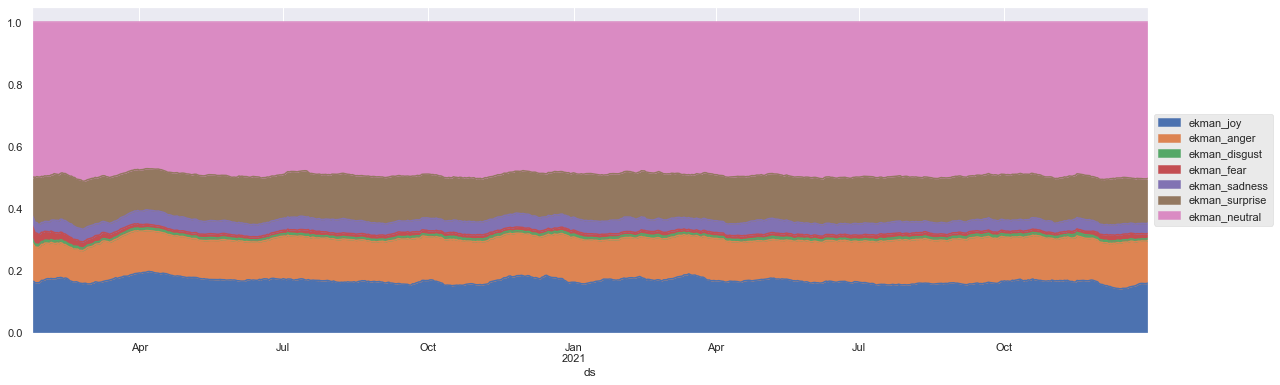

In [40]:
daily_emotions.index = pd.to_datetime(daily_emotions.index)
for s, v in ekman_lookup.items():
    daily_emotions[s] = daily_emotions[v].sum(axis=1)

fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    daily_emotions[ekman_lookup.keys()].rolling('14d').mean().plot.area(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Daily Emotions -- 14-day avg

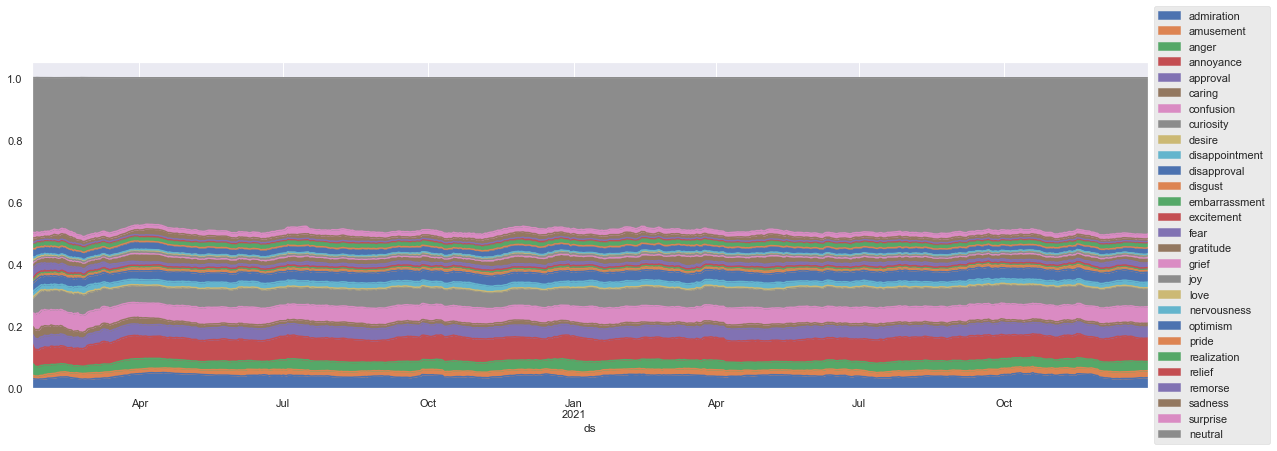

In [41]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    daily_emotions[emotions].rolling('14d').mean().plot.area(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Daily Emotions (except neutral) -- 14-day avg

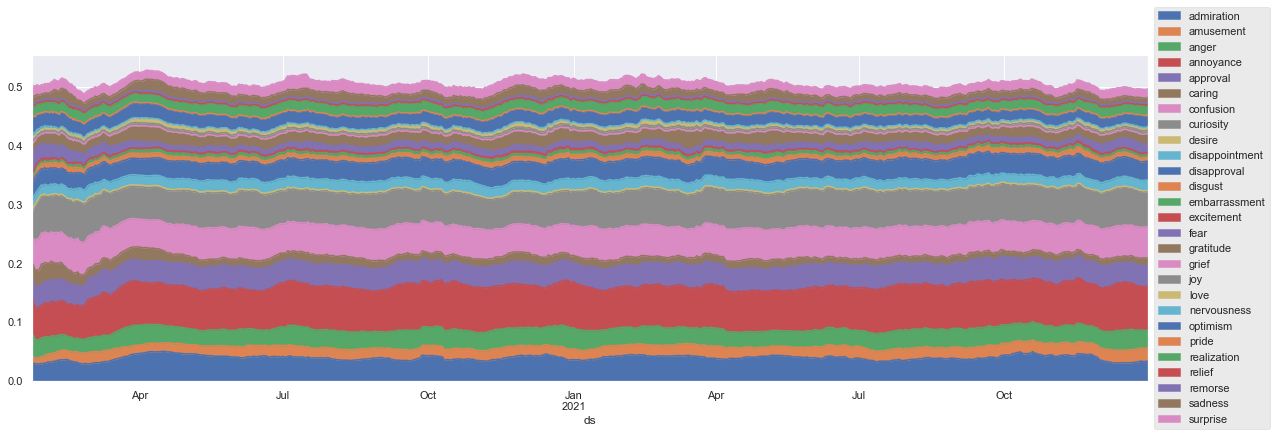

In [42]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = [emotion for emotion in emotions if (emotion not in ['neutral'])]
    daily_emotions[e].rolling('14d').mean().plot.area(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Daily Emotions (except neutral and with less frequent emotions mapped to 'other') -- 14-day avg

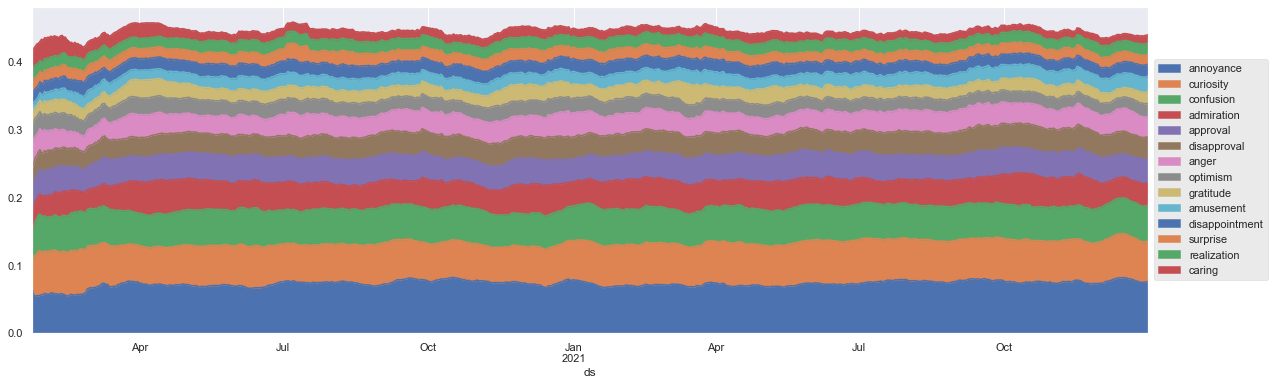

In [43]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = comments[comments.emotion!='neutral'].emotion.value_counts(normalize=True).cumsum()
    e = e[e < 0.9]
    e = list(e.index)
    daily_emotions[e].rolling('14d').mean().plot.area(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Distribution of emotions per theme

### Global

In [236]:
theme_emotions = comments.groupby('theme').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='theme', columns='emotion', values='emotion_prop')
ordered_emotions = comments.emotion.value_counts().index
emotion_value_counts = comments.emotion.value_counts()

for s, v in sentiment_lookup.items():
    theme_emotions[s] = theme_emotions[v].sum(axis=1)

for s, v in ekman_lookup.items():
    theme_emotions[s] = theme_emotions[v].sum(axis=1)

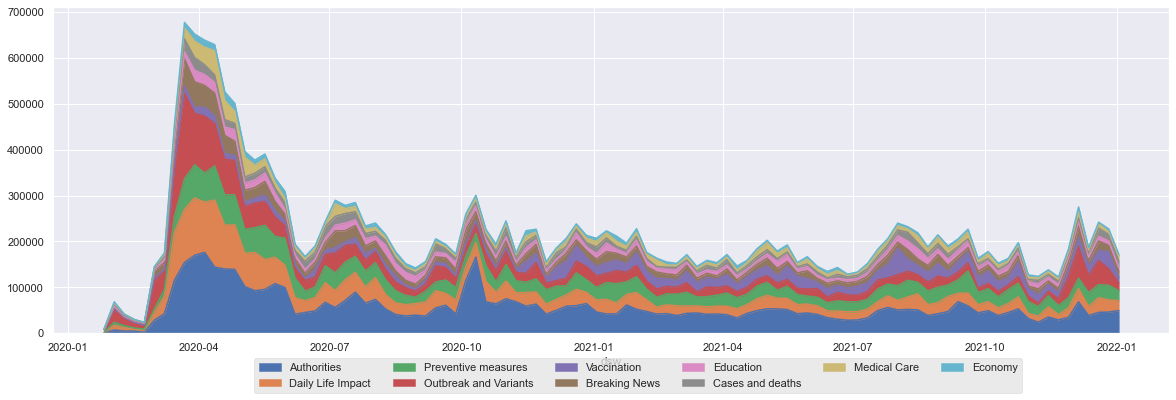

In [337]:
themes_ordered = comments.theme.value_counts().index
weekly_themes = comments.groupby('dsw').theme.value_counts().rename('theme_prop').reset_index().pivot(index='dsw', columns='theme', values='theme_prop')
weekly_themes = weekly_themes[themes_ordered]
fig, ax = plt.subplots(1,1,figsize=(20, 6))
with plt.style.context(['ggplot']):
    weekly_themes.plot.area(ax=ax)
    ax.legend(loc='lower left',bbox_to_anchor=(0.175, -0.2), ncol=6)

In [46]:
weekly_themes.div(weekly_themes.sum(axis=1), axis=0)

theme       Authorities  Breaking News  Cases and deaths  Daily Life Impact  \
dsw                                                                           
2020-01-26     0.053301       0.038177          0.045270           0.090435   
2020-02-02     0.098604       0.055783          0.071057           0.148441   
2020-02-09     0.108845       0.059407          0.046420           0.176339   
2020-02-16     0.145712       0.103812          0.047847           0.129707   
2020-02-23     0.087055       0.142882          0.035806           0.168891   
...                 ...            ...               ...                ...   
2021-12-05     0.247777       0.093215          0.028663           0.104877   
2021-12-12     0.205270       0.062506          0.056215           0.105410   
2021-12-19     0.186877       0.084731          0.073095           0.132619   
2021-12-26     0.201413       0.061040          0.063336           0.116292   
2022-01-02     0.285191       0.082714          0.081505           0.127478   

theme        Economy  Education  Medical Care  Outbreak and Variants  \
dsw                                                                    
2020-01-26  0.000730   0.002295      0.125170               0.609575   
2020-02-02  0.035368   0.013298      0.032028               0.441266   
2020-02-09  0.005914   0.007121      0.067228               0.415657   
2020-02-16  0.017274   0.014668      0.044405               0.388720   
2020-02-23  0.021603   0.006160      0.031999               0.399683   
...              ...        ...           ...                    ...   
2021-12-05  0.039147   0.037391      0.045740               0.246930   
2021-12-12  0.026720   0.039463      0.028797               0.198002   
2021-12-19  0.016245   0.042589      0.038641               0.216870   
2021-12-26  0.025845   0.042523      0.026377               0.155886   
2022-01-02  0.020111   0.046448      0.064485               0.097474   

theme       Preventive measures  Vaccination  
dsw                                           
2020-01-26             0.016794     0.018254  
2020-02-02             0.097931     0.006224  
2020-02-09             0.101313     0.011756  
2020-02-16             0.097898     0.009957  
2020-02-23             0.102284     0.003636  
...                         ...          ...  
2021-12-05             0.082792     0.073468  
2021-12-12             0.162742     0.114873  
2021-12-19             0.118511     0.089823  
2021-12-26             0.140817     0.166472  
2022-01-02             0.126304     0.068290  

[102 rows x 10 columns]

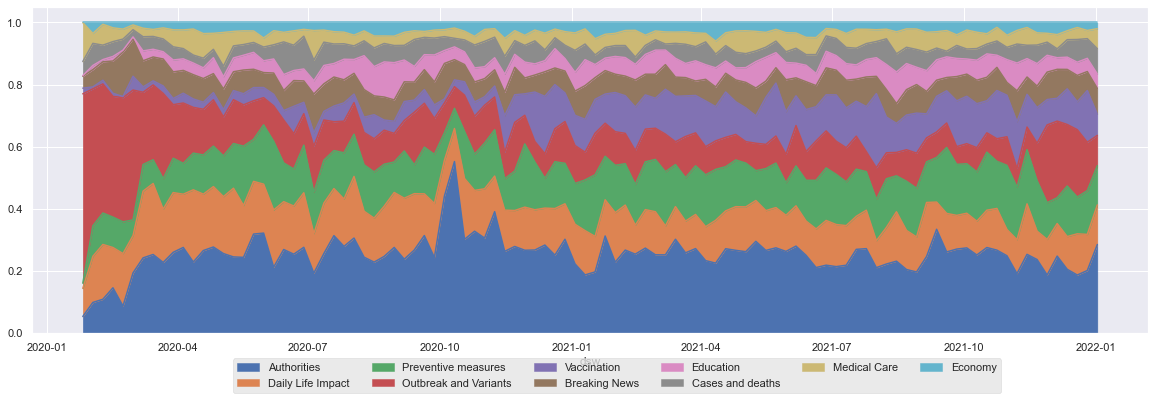

In [338]:
fig, ax = plt.subplots(1,1,figsize=(20, 6))
with plt.style.context(['ggplot']):
    weekly_themes.div(weekly_themes.sum(axis=1), axis=0).plot.area(ax=ax)
    ax.legend(loc='lower left',bbox_to_anchor=(0.175, -0.2), ncol=6)

In [31]:
monthly_themes = comments.groupby('dsm').theme.value_counts(normalize=True).rename('theme_prop').reset_index().pivot(index='dsm', columns='theme', values='theme_prop')
monthly_themes

theme       Authorities  Breaking News  Cases and deaths  Daily Life Impact  \
dsm                                                                           
2020-01-01     0.090045       0.054579          0.071183           0.143899   
2020-02-01     0.161825       0.108098          0.031475           0.135146   
2020-03-01     0.246580       0.083252          0.041884           0.191650   
2020-04-01     0.261564       0.071249          0.028710           0.197370   
2020-05-01     0.275538       0.062978          0.037747           0.179795   
2020-06-01     0.242653       0.069359          0.083041           0.163825   
2020-07-01     0.277824       0.096322          0.060914           0.150787   
2020-08-01     0.250731       0.070329          0.053505           0.168135   
2020-09-01     0.275687       0.064505          0.064720           0.164825   
2020-10-01     0.401636       0.073369          0.049125           0.141887   
2020-11-01     0.291680       0.069258          0.060258           0.124592   
2020-12-01     0.273667       0.066438          0.043985           0.129642   
2021-01-01     0.227506       0.076720          0.039877           0.132725   
2021-02-01     0.257916       0.074630          0.031029           0.124064   
2021-03-01     0.272571       0.063608          0.046361           0.103515   
2021-04-01     0.247875       0.070415          0.051645           0.132025   
2021-05-01     0.278074       0.071489          0.034696           0.128607   
2021-06-01     0.232310       0.079372          0.049984           0.126303   
2021-07-01     0.240710       0.074819          0.052456           0.112525   
2021-08-01     0.216505       0.079885          0.063249           0.132873   
2021-09-01     0.283919       0.059821          0.035979           0.114931   
2021-10-01     0.258147       0.073502          0.038604           0.116649   
2021-11-01     0.220142       0.078170          0.046516           0.117831   
2021-12-01     0.221216       0.076026          0.061720           0.118088   

theme        Economy  Education  Medical Care  Outbreak and Variants  \
dsm                                                                    
2020-01-01  0.033737   0.011153      0.045280               0.449778   
2020-02-01  0.009860   0.007954      0.029426               0.417088   
2020-03-01  0.022218   0.029897      0.041011               0.223917   
2020-04-01  0.028437   0.040118      0.076571               0.152689   
2020-05-01  0.032136   0.046107      0.040747               0.125752   
2020-06-01  0.027896   0.040753      0.035510               0.131344   
2020-07-01  0.029913   0.052275      0.052949               0.105317   
2020-08-01  0.038413   0.104999      0.030726               0.101923   
2020-09-01  0.026941   0.062088      0.028096               0.131401   
2020-10-01  0.026057   0.038212      0.030107               0.102095   
2020-11-01  0.034622   0.047064      0.038498               0.108821   
2020-12-01  0.028734   0.047597      0.041988               0.103234   
2021-01-01  0.035373   0.055788      0.049218               0.108806   
2021-02-01  0.030354   0.064756      0.046599               0.109555   
2021-03-01  0.031108   0.051413      0.036124               0.102072   
2021-04-01  0.036864   0.047176      0.055889               0.086146   
2021-05-01  0.029525   0.065013      0.052629               0.087506   
2021-06-01  0.035881   0.048655      0.043895               0.112363   
2021-07-01  0.024765   0.053750      0.045746               0.096889   
2021-08-01  0.022784   0.080202      0.055231               0.092079   
2021-09-01  0.032473   0.061375      0.056043               0.071268   
2021-10-01  0.028732   0.059667      0.044478               0.075800   
2021-11-01  0.026447   0.061446      0.037925               0.165571   
2021-12-01  0.027176   0.042229      0.042758               0.178034   

theme       Preventive measures  Vaccination  
dsm                      

### Theme vs Main Emotions

In [247]:
main_emotions = theme_emotions[emotions].drop('neutral', axis=1)
main_emotions = main_emotions.div(main_emotions.sum(axis=1), axis=0)[emotion_count[1:11].index]
main_emotions['other'] = 1 - main_emotions.sum(axis=1)

emotion                annoyance  curiosity  confusion  admiration  approval  \
theme                                                                          
Authorities             0.158710   0.110914   0.101975    0.078767  0.074215   
Breaking News           0.139636   0.118657   0.099724    0.082452  0.070463   
Cases and deaths        0.122384   0.126541   0.110245    0.065915  0.066332   
Daily Life Impact       0.138610   0.113385   0.095758    0.083393  0.070587   
Economy                 0.132735   0.111040   0.097984    0.078604  0.082993   
Education               0.134289   0.109383   0.092498    0.086618  0.078824   
Medical Care            0.124964   0.114108   0.096138    0.091001  0.069056   
Outbreak and Variants   0.149469   0.116057   0.103421    0.067684  0.072141   
Preventive measures     0.145784   0.116067   0.099421    0.081673  0.076294   
Vaccination             0.135374   0.125884   0.105428    0.082793  0.080386   

emotion                disapproval     anger  optimism  gratitude  amusement  
theme                                                                         
Authorities               0.066401  0.063746  0.038487   0.037200   0.038615  
Breaking News             0.058742  0.059120  0.044933   0.039525   0.034411  
Cases and deaths          0.055974  0.052191  0.041568   0.040079   0.029225  
Daily Life Impact         0.057273  0.057596  0.040397   0.038915   0.034629  
Economy                   0.063257  0.052298  0.044609   0.041333   0.036062  
Education                 0.065345  0.056239  0.039680   0.041395   0.031727  
Medical Care              0.059004  0.057280  0.040422   0.045365   0.030414  
Outbreak and Variants     0.059638  0.063537  0.042364   0.035059   0.035589  
Preventive measures       0.061503  0.062477  0.043096   0.036067   0.036897  
Vaccination               0.068583  0.056908  0.043940   0.043019   0.039634

- Authorities lidera em 'annoyance' e 'anger'
- Medical Care lidera em admiration
- Vaccination tem índices altos em approval e dissaproval e lidera em gratitude

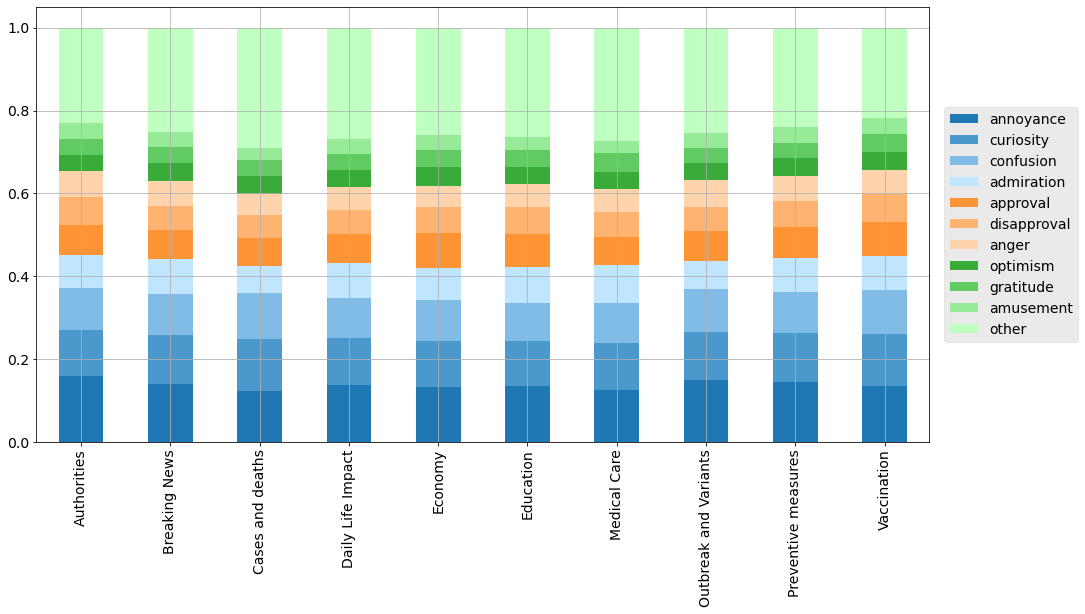

In [251]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(16, 8))
with plt.style.context(['ggplot']):   
    main_emotions = theme_emotions[emotions].drop('neutral', axis=1)
    main_emotions = main_emotions.div(main_emotions.sum(axis=1), axis=0)[emotion_count[1:11].index]
    main_emotions['other'] = 1 - main_emotions.sum(axis=1)
    main_emotions.plot.bar(cmap=c1, ax=ax, stacked=True)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('')
    ax.legend(loc='center right', bbox_to_anchor=(1.175, 0.5))

### Theme vs Emotions (grouped, positive, negative, ambiguous)

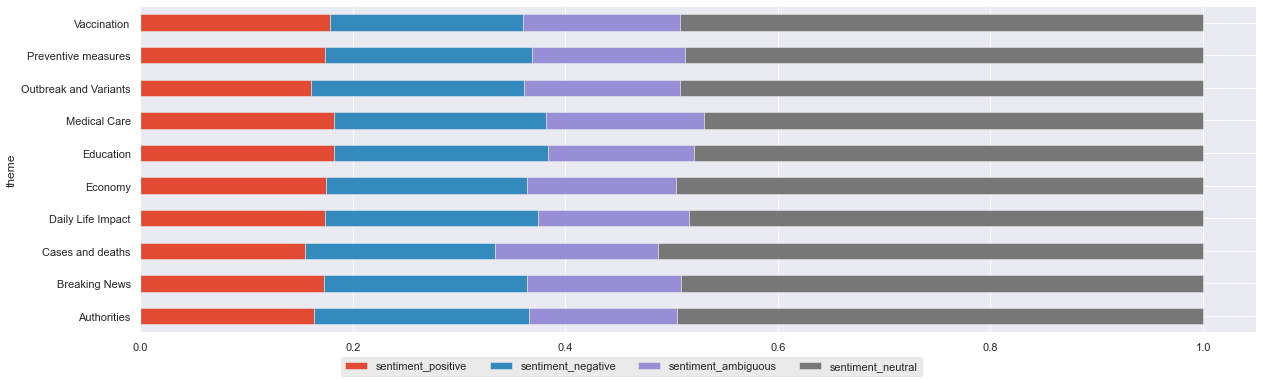

In [344]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    theme_emotions[sentiment_lookup.keys()].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='lower left',bbox_to_anchor=(0.175, -0.15), ncol=6)

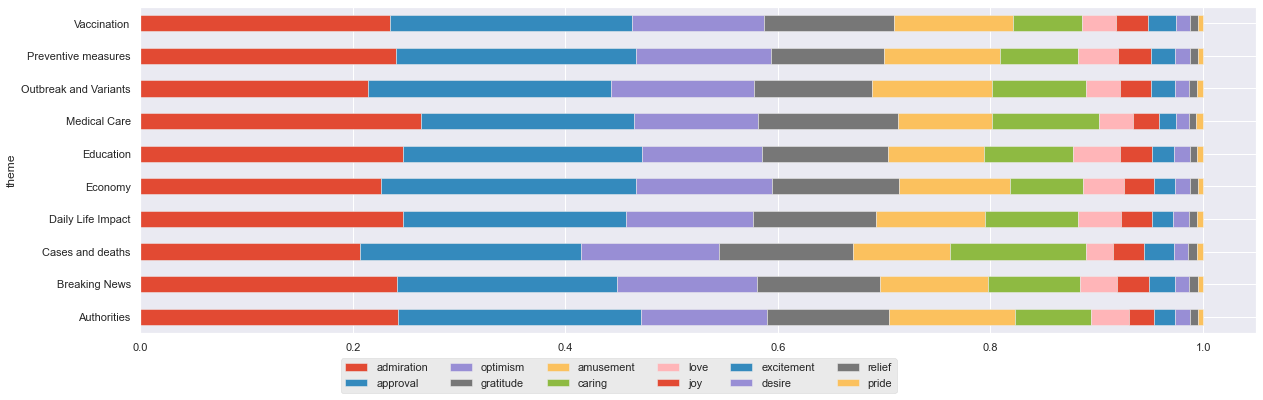

In [367]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    ordered = emotion_value_counts[sentiment_lookup['sentiment_positive']].sort_values(ascending=False).index
    theme_emotions[ordered].div(theme_emotions[ordered].sum(axis=1), axis=0).plot.barh(ax=ax, stacked=True)
    ax.legend(loc='lower left',bbox_to_anchor=(0.175, -0.2), ncol=6)

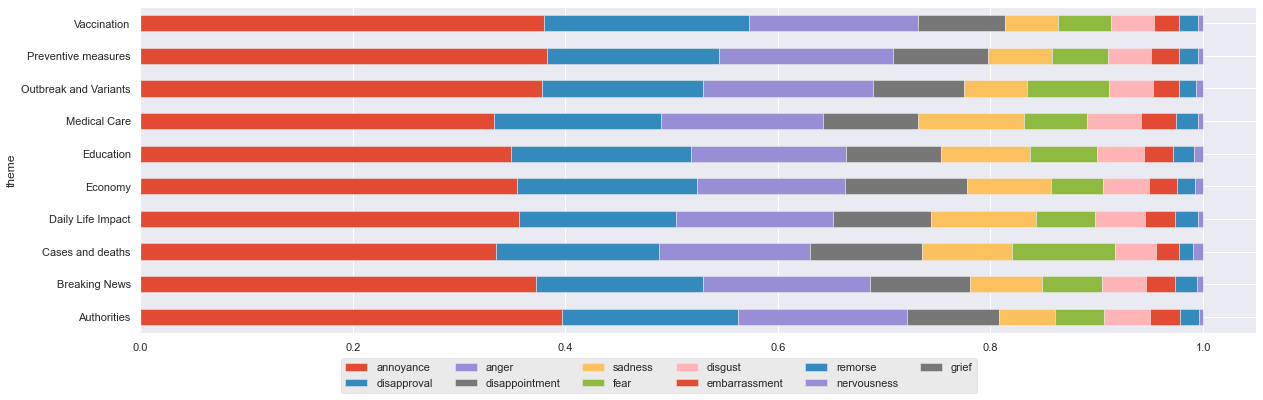

In [368]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    ordered = emotion_value_counts[sentiment_lookup['sentiment_negative']].sort_values(ascending=False).index
    theme_emotions[ordered].div(theme_emotions[ordered].sum(axis=1), axis=0).plot.barh(ax=ax, stacked=True)
    ax.legend(loc='lower left',bbox_to_anchor=(0.175, -0.2), ncol=6)

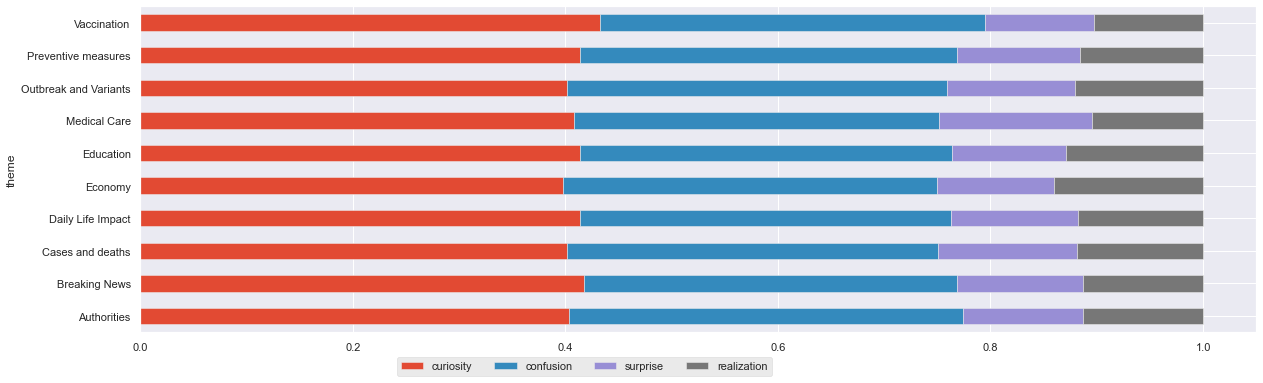

In [370]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    ordered = emotion_value_counts[sentiment_lookup['sentiment_ambiguous']].sort_values(ascending=False).index
    theme_emotions[ordered].div(theme_emotions[ordered].sum(axis=1), axis=0).plot.barh(ax=ax, stacked=True)
    ax.legend(loc='lower left',bbox_to_anchor=(0.225, -0.15), ncol=4)

### Theme vs Ekman

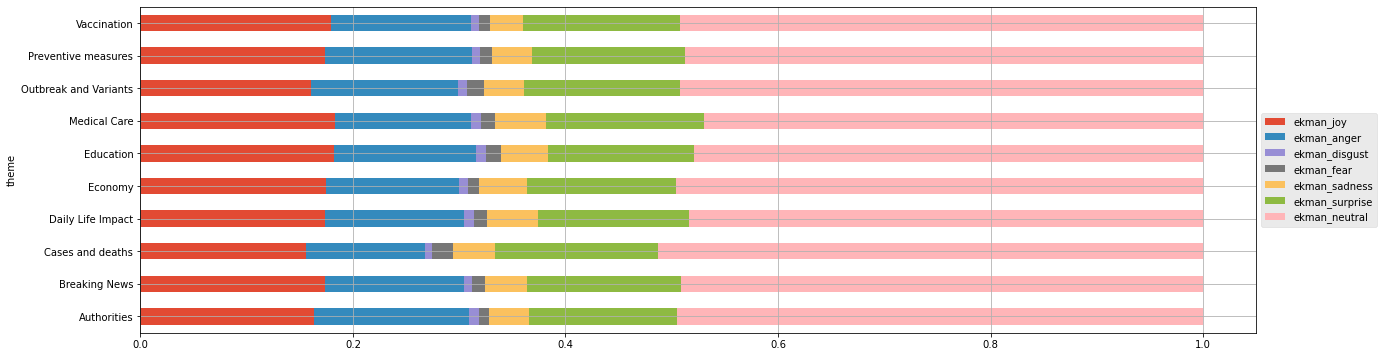

In [12]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    theme_emotions[ekman_lookup.keys()].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Theme vs Emotion

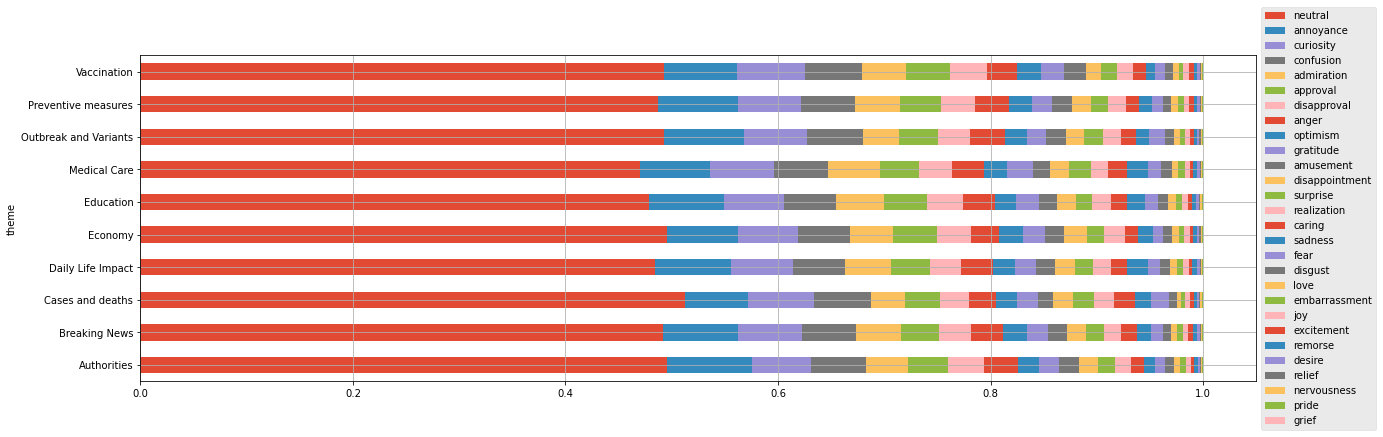

In [13]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    theme_emotions[ordered_emotions].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Theme vs Emotion (except neutral)

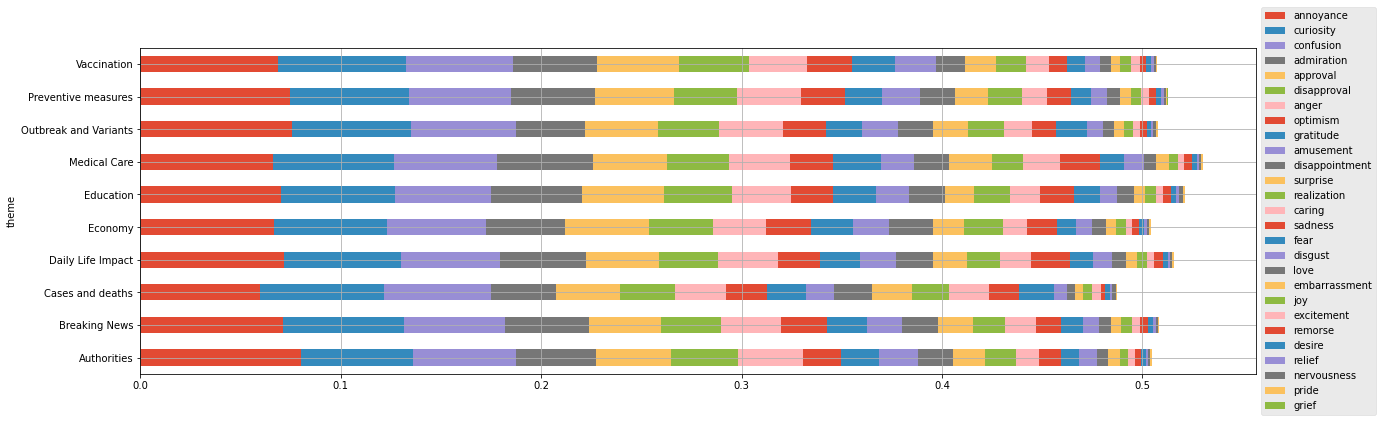

In [14]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = [emotion for emotion in ordered_emotions if (emotion not in ['neutral'])]
    theme_emotions[e].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Theme vs Emotion (most relevant, except neutral)

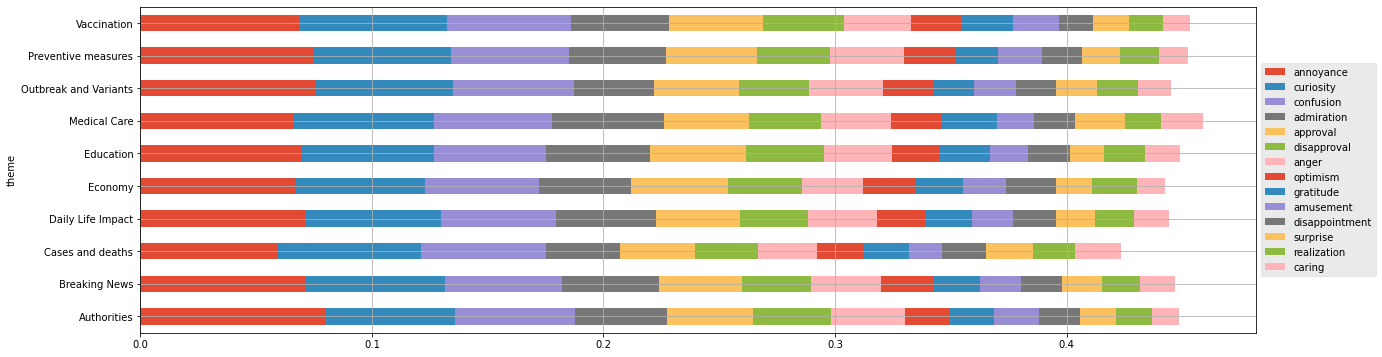

In [15]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = comments[comments.emotion!='neutral'].emotion.value_counts(normalize=True).cumsum()
    e = e[e < 0.9]
    e = list(e.index)
    theme_emotions[e].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Distribution of emotions per country

In [259]:
country_emotions = comments.groupby('country').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='country', columns='emotion', values='emotion_prop')
ordered_emotions = comments.emotion.value_counts().index
emotion_value_counts = comments.emotion.value_counts()

for s, v in sentiment_lookup.items():
    country_emotions[s] = country_emotions[v].sum(axis=1)

for s, v in ekman_lookup.items():
    country_emotions[s] = country_emotions[v].sum(axis=1)

### Country vs Main Emotion

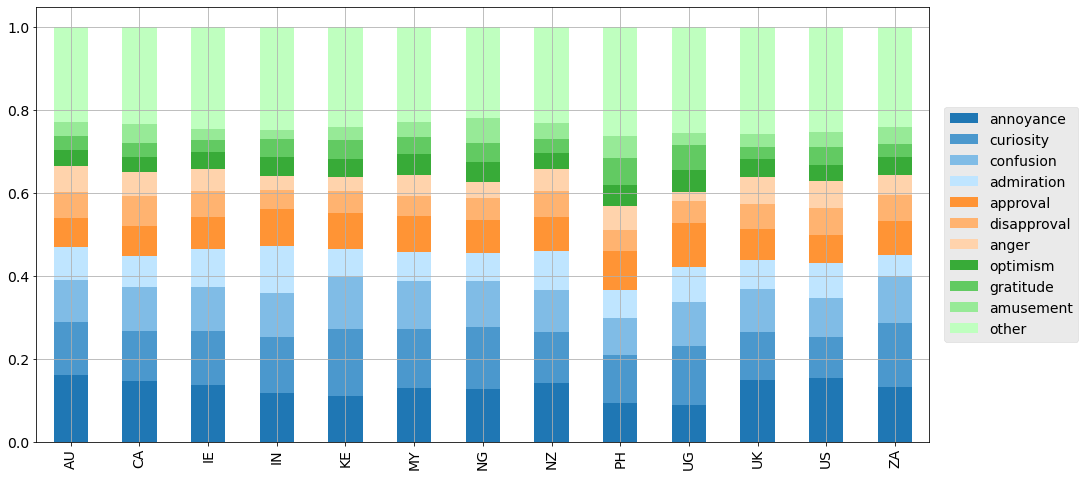

In [260]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(16, 8))
with plt.style.context(['ggplot']):   
    main_emotions = country_emotions[emotions].drop('neutral', axis=1)
    main_emotions = main_emotions.div(main_emotions.sum(axis=1), axis=0)[emotion_count[1:11].index]
    main_emotions['other'] = 1 - main_emotions.sum(axis=1)
    main_emotions.plot.bar(cmap=c1, ax=ax, stacked=True)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('')
    ax.legend(loc='center right', bbox_to_anchor=(1.175, 0.5))

In [261]:
main_emotions

emotion  annoyance  curiosity  confusion  admiration  approval  disapproval  \
country                                                                       
AU        0.161538   0.127179   0.102390    0.077695  0.070236     0.063496   
CA        0.145320   0.121960   0.106905    0.074363  0.073014     0.071988   
IE        0.135878   0.130216   0.106740    0.092668  0.075474     0.063105   
IN        0.116116   0.135167   0.108123    0.112128  0.088897     0.046364   
KE        0.108871   0.163136   0.124875    0.068073  0.086433     0.053498   
MY        0.129975   0.142131   0.114735    0.069830  0.088155     0.047468   
NG        0.127633   0.149759   0.109779    0.068772  0.079844     0.051837   
NZ        0.141008   0.123059   0.101161    0.094517  0.082567     0.061539   
PH        0.093566   0.115630   0.088805    0.067192  0.094168     0.051094   
UG        0.089251   0.140358   0.106662    0.085273  0.106756     0.051624   
UK        0.147725   0.117011   0.102637    0.072009  0.073148     0.060972   
US        0.152839   0.099715   0.094699    0.083786  0.068539     0.064617   
ZA        0.130688   0.156388   0.113387    0.049875  0.081615     0.062927   

emotion     anger  optimism  gratitude  amusement     other  
country                                                      
AU       0.063916  0.038206   0.032565   0.034867  0.227912  
CA       0.056250  0.037035   0.034162   0.044739  0.234262  
IE       0.053483  0.041954   0.029513   0.026241  0.244728  
IN       0.033908  0.045715   0.043439   0.022656  0.247487  
KE       0.033165  0.044283   0.045113   0.032440  0.240111  
MY       0.051233  0.049985   0.042796   0.035176  0.228517  
NG       0.038402  0.048690   0.044927   0.061185  0.219173  
NZ       0.053519  0.040334   0.033867   0.037470  0.230959  
PH       0.057143  0.051305   0.064543   0.054126  0.262426  
UG       0.022187  0.053090   0.060717   0.028686  0.255397  
UK       0.066296  0.042707   0.029151   0.031769  0.256575  
US       0.065351  0.039319   0.042545   0.035523  0.253068  
ZA       0.049174  0.043014   0.031104   0.041084  0.240744

- Uganda and Philippines have the lead on approval (10.7%, 9.4%), optimism (5.3%, 5.1%) and gratitude (6.1%, 6.5%)
- Canada have almost same values for approval (7.3%) and disapproval (7.2%)
- Kenya have the lead on curiosity (16.3%) and confusion (12.5%)
- The US, UK and Australia have the lead on annoyance (15.3%, 14.8%, 16.2%) and anger (6.6%, 6.6%, 6.4%)

### Country vs Emotions (grouped, positive, negative, ambiguous)

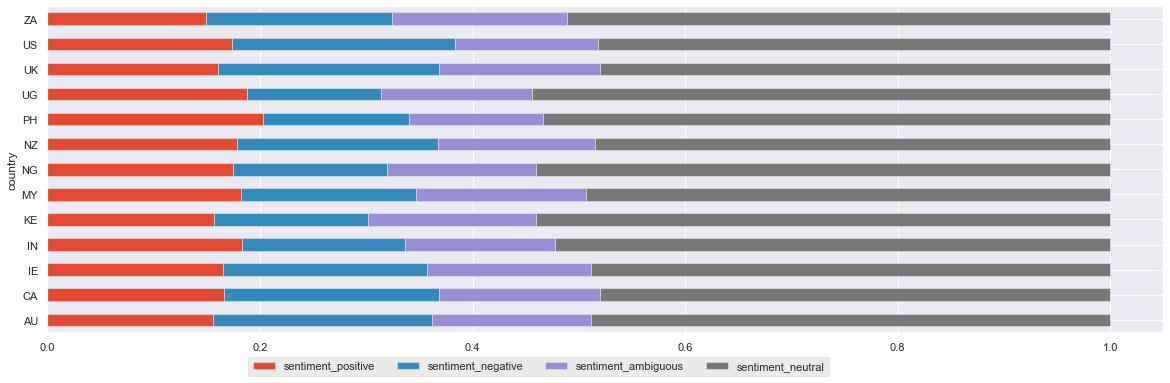

In [372]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    country_emotions[sentiment_lookup.keys()].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='lower left',bbox_to_anchor=(0.175, -0.15), ncol=6)

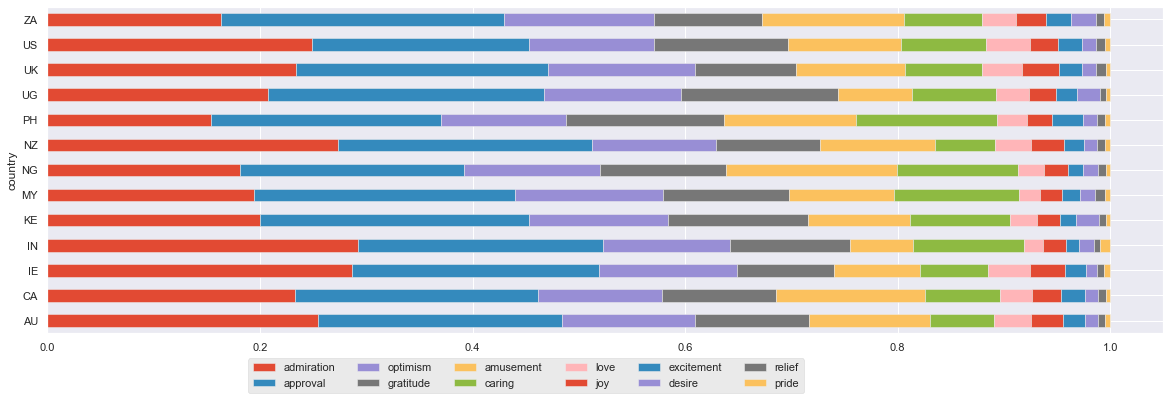

In [373]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    ordered = emotion_value_counts[sentiment_lookup['sentiment_positive']].sort_values(ascending=False).index
    country_emotions[ordered].div(country_emotions[ordered].sum(axis=1), axis=0).plot.barh(ax=ax, stacked=True)
    ax.legend(loc='lower left',bbox_to_anchor=(0.175, -0.2), ncol=6)

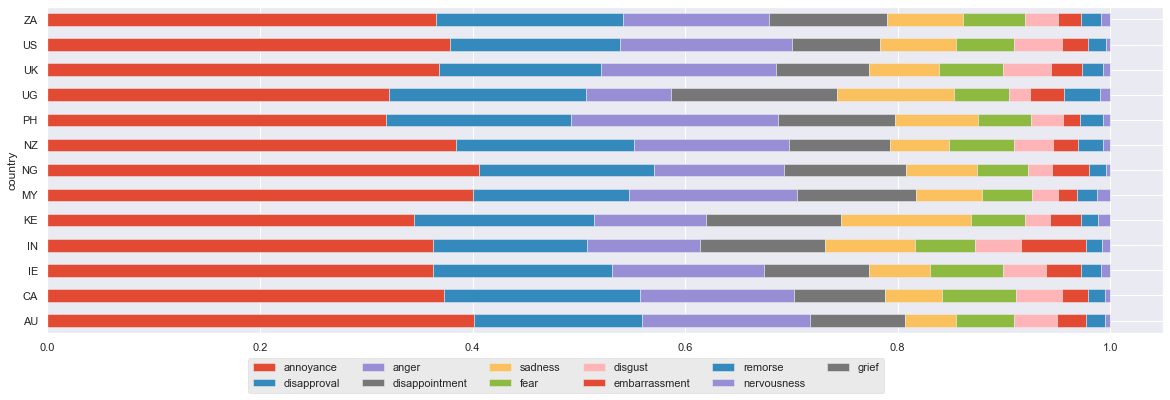

In [374]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    ordered = emotion_value_counts[sentiment_lookup['sentiment_negative']].sort_values(ascending=False).index
    country_emotions[ordered].div(country_emotions[ordered].sum(axis=1), axis=0).plot.barh(ax=ax, stacked=True)
    ax.legend(loc='lower left',bbox_to_anchor=(0.175, -0.2), ncol=6)

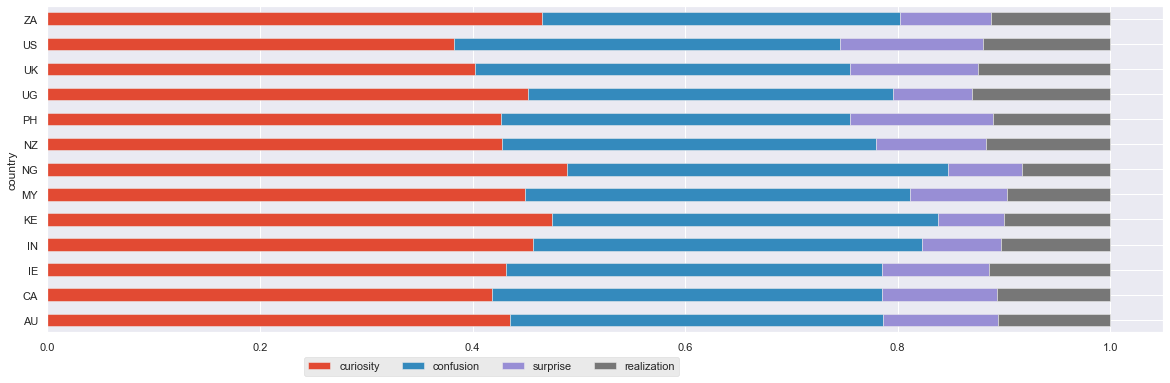

In [375]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    ordered = emotion_value_counts[sentiment_lookup['sentiment_ambiguous']].sort_values(ascending=False).index
    country_emotions[ordered].div(country_emotions[ordered].sum(axis=1), axis=0).plot.barh(ax=ax, stacked=True)
    ax.legend(loc='lower left',bbox_to_anchor=(0.225, -0.15), ncol=4)

### Country vs Ekman

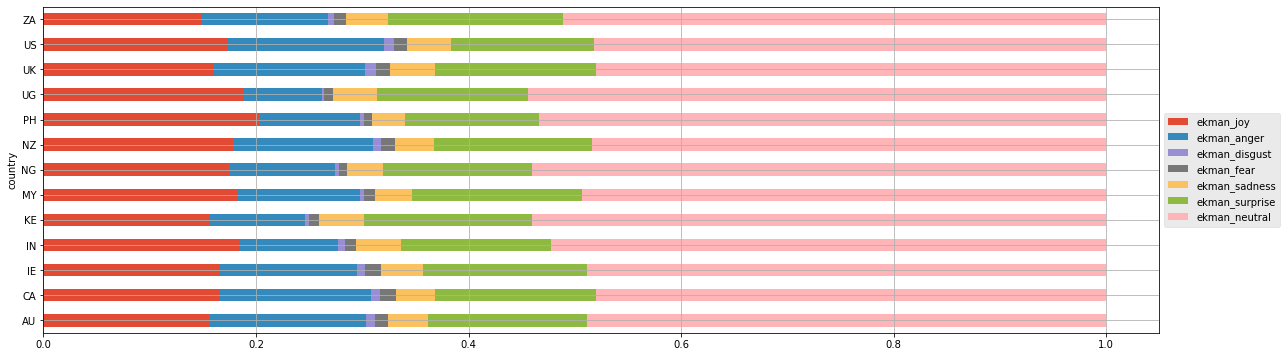

In [18]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    country_emotions[ekman_lookup.keys()].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Country vs Emotion

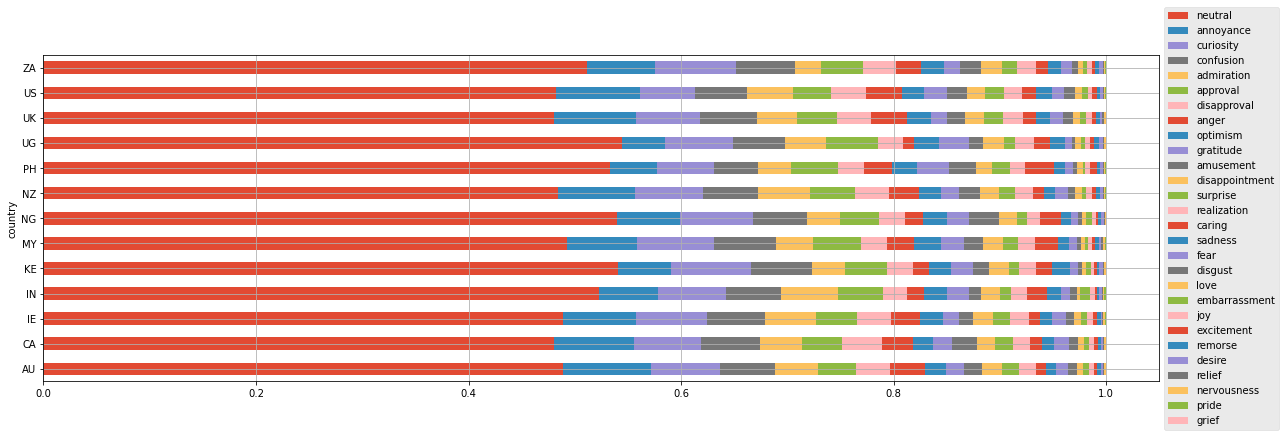

In [19]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    country_emotions[ordered_emotions].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Country vs Emotion (except neutral)

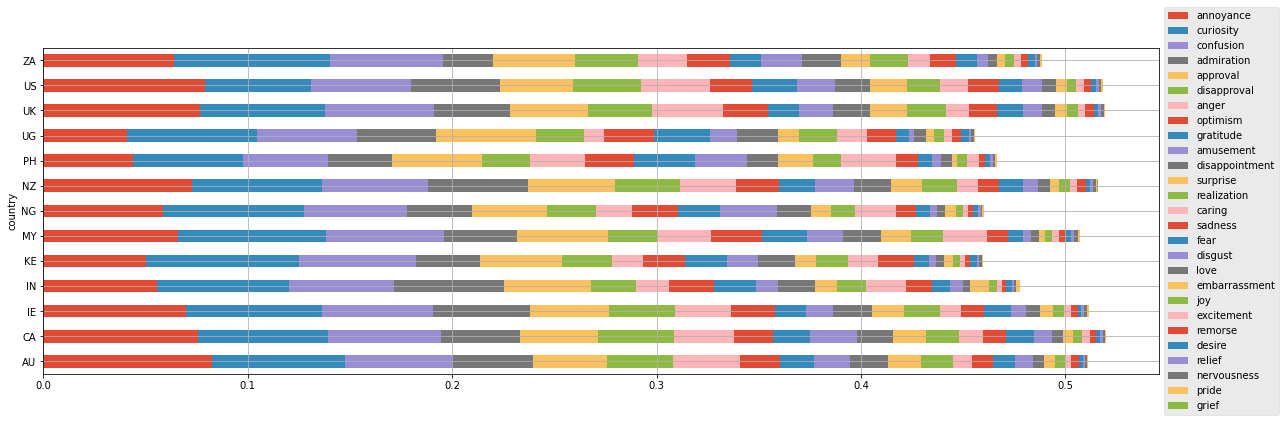

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = [emotion for emotion in ordered_emotions if (emotion not in ['neutral'])]
    country_emotions[e].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Country vs Emotion (most relevant, except neutral)

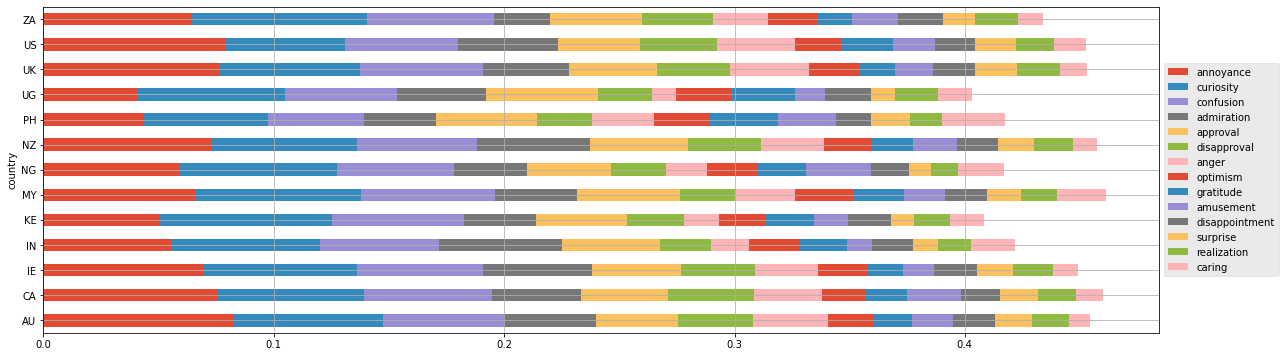

In [21]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = comments[comments.emotion!='neutral'].emotion.value_counts(normalize=True).cumsum()
    e = e[e < 0.9]
    e = list(e.index)
    country_emotions[e].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Distribution of emotions per Media

In [314]:
account_emotions = comments.groupby('in_reply_to_user_id').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='in_reply_to_user_id', columns='emotion', values='emotion_prop')
ordered_emotions = comments.emotion.value_counts().index
emotion_value_counts = comments.emotion.value_counts()

account_value_counts = comments.in_reply_to_user_id.value_counts()
account_value_counts = account_value_counts.rename('prop').rename_axis('author_id').reset_index()
account_value_counts = account_value_counts.merge(news_accounts[['author_id', 'display_name']])
main_account = account_value_counts.head(15)

account_emotions = account_emotions.merge(account_value_counts[['author_id', 'display_name']], left_on='in_reply_to_user_id', right_on='author_id')
account_emotions = account_emotions.set_index('display_name')

### Account vs Main Emotion

In [321]:
main_emotions = account_emotions[account_emotions.author_id.isin(main_account.author_id.values)].reindex(main_account.display_name.values).drop('author_id', axis=1)
main_emotions = main_emotions[emotions].drop('neutral', axis=1)
main_emotions = main_emotions.div(main_emotions.sum(axis=1), axis=0)[emotion_count[1:11].index]
main_emotions['other'] = 1 - main_emotions.sum(axis=1)

In [347]:
account_emotions.sort_values('optimism')

admiration  amusement     anger  annoyance  approval  \
display_name                                                              
Kenyans.co.ke        0.034410   0.013890  0.013575   0.043670  0.040198   
Newsmax              0.031678   0.022587  0.038887   0.086010  0.033251   
Pulse Nigeria        0.021947   0.045996  0.032734   0.076488  0.030072   
Fox News             0.040562   0.023547  0.036991   0.091394  0.038839   
Toronto Sun          0.040416   0.024063  0.027948   0.076827  0.038252   
...                       ...        ...       ...        ...       ...   
Economic Times       0.060537   0.009558  0.012726   0.045749  0.048279   
Daily Trust          0.042489   0.020285  0.012890   0.050889  0.039229   
ChimpReports         0.048269   0.014780  0.011974   0.030122  0.037979   
RNZ                  0.066897   0.011597  0.018929   0.053191  0.047249   
New Straits Times    0.040269   0.017795  0.019442   0.051737  0.048771   

                     caring  confusion  curiosity    desire  disappointment  \
display_name                                                                  
Kenyans.co.ke      0.010944   0.049879   0.068084  0.002105        0.014943   
Newsmax            0.009787   0.050510   0.056756  0.001521        0.015206   
Pulse Nigeria      0.015410   0.043894   0.062386  0.001494        0.013915   
Fox News           0.010652   0.049001   0.053801  0.001417        0.014870   
Toronto Sun        0.009527   0.053911   0.062697  0.001434        0.016855   
...                     ...        ...        ...       ...             ...   
Economic Times     0.019867   0.053321   0.062973  0.003130        0.018405   
Daily Trust        0.029394   0.048691   0.065326  0.003055        0.016355   
ChimpReports       0.015903   0.046399   0.078578  0.004490        0.019457   
RNZ                0.009919   0.049454   0.064501  0.003882        0.019360   
New Straits Times  0.028340   0.054373   0.067752  0.002241        0.019113   

                   disapproval   disgust  embarrassment  excitement      fear  \
display_name                                                                    
Kenyans.co.ke         0.030938  0.002420       0.002105    0.001999  0.005682   
Newsmax               0.042480  0.008184       0.003103    0.002762  0.009574   
Pulse Nigeria         0.017745  0.004203       0.007051    0.003129  0.009900   
Fox News              0.035216  0.008246       0.004418    0.002883  0.008726   
Toronto Sun           0.037762  0.008702       0.005092    0.002809  0.013735   
...                        ...       ...            ...         ...       ...   
Economic Times        0.022415  0.004873       0.006597    0.002249  0.008153   
Daily Trust           0.025240  0.003092       0.004545    0.002105  0.007060   
ChimpReports          0.019645  0.002058       0.003181    0.003742  0.006361   
RNZ                   0.025637  0.005750       0.003306    0.004696  0.009057   
New Straits Times     0.024583  0.003493       0.002768    0.003691  0.007579   

                   gratitude     grief       joy      love  nervousness  \
display_name                                                              
Kenyans.co.ke       0.012838       NaN  0.002420  0.003473     0.000526   
Newsmax             0.018068  0.000056  0.003245  0.006306     0.000367   
Pulse Nigeria       0.012048       NaN  0.003269  0.005790     0.000560   
Fox News            0.018984  0.000027  0.003819  0.005877     0.000352   
Toronto Sun         0.016341  0.000060  0.003742  0.004949     0.000908   
...                      ...       ...       ...       ...          ...   
Economic Times      0.022341  0.000019  0.004179  0.002249     0.001481   
Daily Trust         0.023824  0.000019  0.004172  0.003781     0.000745   
ChimpReports        0.036109  0.000187  0.004864  0.005426     0.000748   
RNZ                 0.022427  0.000048  0.008146  0.009297     0.001773   
New Straits Times   0.024056       NaN  0.004548  0.004218   

In [349]:
main_emotions.sort_values('amusement')

annoyance  curiosity  confusion  admiration  approval  \
display_name                                                                 
The Guardian          0.122894   0.111409   0.103090    0.085766  0.082823   
BBC News (UK)         0.143128   0.119106   0.108259    0.073429  0.072162   
MSNBC                 0.178267   0.098251   0.098446    0.073050  0.062365   
NPR                   0.133178   0.099834   0.099381    0.086351  0.074713   
NBC News              0.152161   0.099252   0.095366    0.085411  0.064555   
Sky News              0.156393   0.117823   0.101897    0.068608  0.070366   
The Washington Post   0.161802   0.099240   0.098966    0.075704  0.070082   
ABC News              0.144780   0.098739   0.094505    0.093024  0.067313   
The New York Times    0.129672   0.097541   0.092441    0.089366  0.073247   
CNN                   0.147012   0.101810   0.093779    0.086043  0.068866   
CBS News              0.171096   0.092086   0.085574    0.081938  0.062157   
News24                0.133944   0.153472   0.112296    0.049489  0.079412   
CTV News              0.149405   0.124295   0.106730    0.075994  0.072184   
Fox News              0.180109   0.106026   0.096567    0.079935  0.076539   
CP24                  0.138596   0.122756   0.108060    0.069439  0.068665   

                     disapproval     anger  optimism  gratitude  amusement  \
display_name                                                                 
The Guardian            0.062236  0.051689  0.047519   0.034040   0.025556   
BBC News (UK)           0.060610  0.059083  0.042850   0.032304   0.027440   
MSNBC                   0.066784  0.072225  0.036971   0.042444   0.029288   
NPR                     0.066231  0.056578  0.042156   0.046675   0.029694   
NBC News                0.061493  0.069195  0.041886   0.041508   0.030555   
Sky News                0.059535  0.071895  0.041995   0.027770   0.031817   
The Washington Post     0.072998  0.068313  0.038352   0.035369   0.032522   
ABC News                0.062488  0.062573  0.038141   0.048120   0.035994   
The New York Times      0.060619  0.057811  0.045030   0.044376   0.036159   
CNN                     0.061588  0.061068  0.039811   0.044628   0.037146   
CBS News                0.063506  0.075567  0.037937   0.038619   0.037975   
News24                  0.061121  0.051663  0.043513   0.029397   0.044500   
CTV News                0.071511  0.055797  0.034634   0.033474   0.045023   
Fox News                0.069400  0.072899  0.030388   0.037412   0.046405   
CP24                    0.061461  0.060634  0.040646   0.032520   0.056709   

                        other  
display_name                   
The Guardian         0.272978  
BBC News (UK)        0.261629  
MSNBC                0.241910  
NPR                  0.265211  
NBC News             0.258617  
Sky News             0.251902  
The Washington Post  0.246653  
ABC News             0.254324  
The New York Times   0.273739  
CNN                  0.258250  
CBS News             0.253544  
News24               0.241192  
CTV News             0.230954  
Fox News             0.204321  
CP24                 0.240515

- Fox News have the lead in annoyance (18.9%) and is the second with largest proportion on anger (7.3%), while it has the lowest proportion of optimism (3.0%)
- The Guardian have the smallest proportions of annoyance (12.3%) and anger (5.2%), while it leads on approval (8.3%) and optimism (4.8%)
- News24 leads in curiosity (15.3%) and confusion (11.2%)
- The Washington Post leads in disapproval (7.3%)
- CP24 leads on amusement (5.7%)

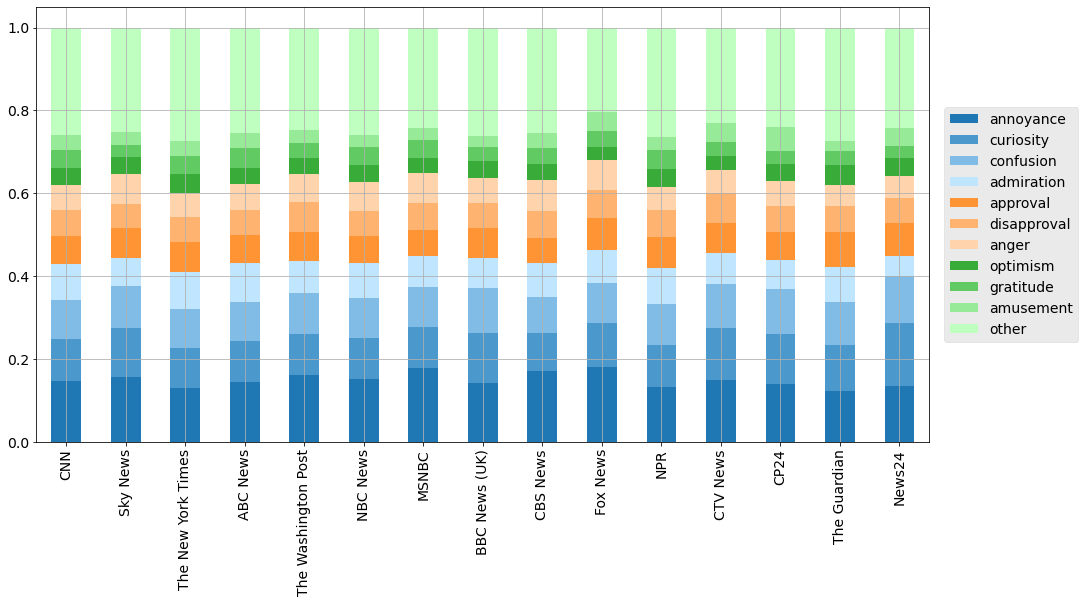

In [323]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(16, 8))
with plt.style.context(['ggplot']):
    main_emotions.plot.bar(cmap=c1, ax=ax, stacked=True)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('')
    ax.legend(loc='center right', bbox_to_anchor=(1.175, 0.5))

In [261]:
main_emotions

emotion  annoyance  curiosity  confusion  admiration  approval  disapproval  \
country                                                                       
AU        0.161538   0.127179   0.102390    0.077695  0.070236     0.063496   
CA        0.145320   0.121960   0.106905    0.074363  0.073014     0.071988   
IE        0.135878   0.130216   0.106740    0.092668  0.075474     0.063105   
IN        0.116116   0.135167   0.108123    0.112128  0.088897     0.046364   
KE        0.108871   0.163136   0.124875    0.068073  0.086433     0.053498   
MY        0.129975   0.142131   0.114735    0.069830  0.088155     0.047468   
NG        0.127633   0.149759   0.109779    0.068772  0.079844     0.051837   
NZ        0.141008   0.123059   0.101161    0.094517  0.082567     0.061539   
PH        0.093566   0.115630   0.088805    0.067192  0.094168     0.051094   
UG        0.089251   0.140358   0.106662    0.085273  0.106756     0.051624   
UK        0.147725   0.117011   0.102637    0.072009  0.073148     0.060972   
US        0.152839   0.099715   0.094699    0.083786  0.068539     0.064617   
ZA        0.130688   0.156388   0.113387    0.049875  0.081615     0.062927   

emotion     anger  optimism  gratitude  amusement     other  
country                                                      
AU       0.063916  0.038206   0.032565   0.034867  0.227912  
CA       0.056250  0.037035   0.034162   0.044739  0.234262  
IE       0.053483  0.041954   0.029513   0.026241  0.244728  
IN       0.033908  0.045715   0.043439   0.022656  0.247487  
KE       0.033165  0.044283   0.045113   0.032440  0.240111  
MY       0.051233  0.049985   0.042796   0.035176  0.228517  
NG       0.038402  0.048690   0.044927   0.061185  0.219173  
NZ       0.053519  0.040334   0.033867   0.037470  0.230959  
PH       0.057143  0.051305   0.064543   0.054126  0.262426  
UG       0.022187  0.053090   0.060717   0.028686  0.255397  
UK       0.066296  0.042707   0.029151   0.031769  0.256575  
US       0.065351  0.039319   0.042545   0.035523  0.253068  
ZA       0.049174  0.043014   0.031104   0.041084  0.240744

- Uganda and Philippines have the lead on approval (10.7%, 9.4%), optimism (5.3%, 5.1%) and gratitude (6.1%, 6.5%)
- Canada have almost same values for approval (7.3%) and disapproval (7.2%)
- Kenya have the lead on curiosity (16.3%) and confusion (12.5%)
- The US, UK and Australia have the lead on annoyance (15.3%, 14.8%, 16.2%) and anger (6.6%, 6.6%, 6.4%)

# Distribution of themes per country

In [263]:
country_themes = comments.groupby('country').theme.value_counts(normalize=True).rename('theme_prop').reset_index().pivot(index='country', columns='theme', values='theme_prop')
ordered_themes = comments.theme.value_counts().index

In [62]:
country_themes

theme    Authorities  Breaking News  Cases and deaths  Daily Life Impact  \
country                                                                    
AU          0.175578       0.224344          0.040226           0.129487   
CA          0.261309       0.054824          0.074543           0.134070   
IE          0.201280       0.050060          0.075893           0.132830   
IN          0.338148       0.057212          0.045080           0.196390   
KE          0.213821       0.052616          0.070952           0.147327   
MY          0.267759       0.042901          0.068653           0.133017   
NG          0.262654       0.078404          0.049300           0.129059   
NZ          0.203233       0.116317          0.041977           0.133386   
PH          0.224164       0.063420          0.110957           0.134219   
UG          0.265397       0.055123          0.056931           0.117466   
UK          0.174591       0.091260          0.043639           0.152312   
US          0.325528       0.052793          0.033666           0.143641   
ZA          0.179445       0.084673          0.071763           0.217315   

theme     Economy  Education  Medical Care  Outbreak and Variants  \
country                                                             
AU       0.029264   0.033921      0.025081               0.113185   
CA       0.034270   0.060656      0.038370               0.116122   
IE       0.027189   0.077009      0.054747               0.103371   
IN       0.026502   0.040146      0.059851               0.096457   
KE       0.042431   0.071721      0.069593               0.119956   
MY       0.038289   0.055749      0.051757               0.097741   
NG       0.024497   0.039836      0.058128               0.204172   
NZ       0.024680   0.046200      0.041214               0.161377   
PH       0.023793   0.031469      0.065379               0.075970   
UG       0.029781   0.182595      0.058268               0.055754   
UK       0.027482   0.049519      0.044437               0.174431   
US       0.029401   0.051104      0.046387               0.123762   
ZA       0.029692   0.043350      0.041039               0.102199   

theme    Preventive measures  Vaccination  
country                                    
AU                  0.162160     0.066753  
CA                  0.135015     0.090820  
IE                  0.170379     0.107243  
IN                  0.085852     0.054364  
KE                  0.130667     0.080916  
MY                  0.168511     0.075623  
NG                  0.116513     0.037437  
NZ                  0.169779     0.061836  
PH                  0.204621     0.066007  
UG                  0.118113     0.060573  
UK                  0.179526     0.062803  
US                  0.106524     0.087194  
ZA                  0.151753     0.078771

- The US leads on Authorities (32.6%)
- AU leads on Breaking News (22.4%)
- UK leads on Outbreak and Variants (17.4%)
- PH leads on Cases and Deaths (11.1%) and Preventive Measures (18.0%)
- UG leads on Education (18.3%)

### Country vs Themes 1

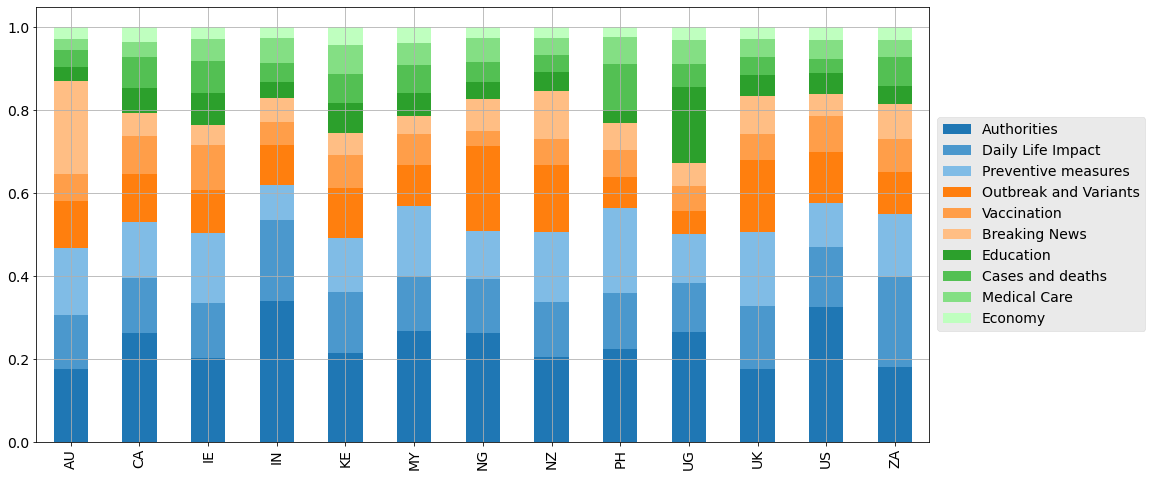

In [267]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(16, 8))
with plt.style.context(['ggplot']):   
    # main_emotions = country_emotions[emotions].drop('neutral', axis=1)
    # main_emotions = main_emotions.div(main_emotions.sum(axis=1), axis=0)[emotion_count[1:11].index]
    # main_emotions['other'] = 1 - main_emotions.sum(axis=1)
    country_themes[ordered_themes].plot.bar(cmap=c1, ax=ax, stacked=True)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('')
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

### Country vs Themes 2

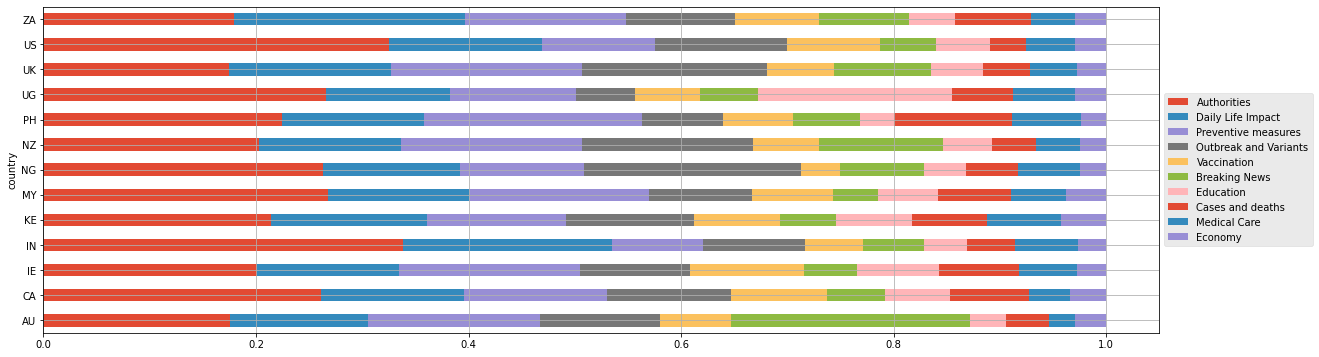

In [133]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    country_themes[ordered_themes].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Distribution of themes per emotion

In [132]:
emotion_themes = comments.groupby('emotion').theme.value_counts(normalize=True).rename('theme_prop').reset_index().pivot(index='emotion', columns='theme', values='theme_prop')
ordered_themes = comments.theme.value_counts().index

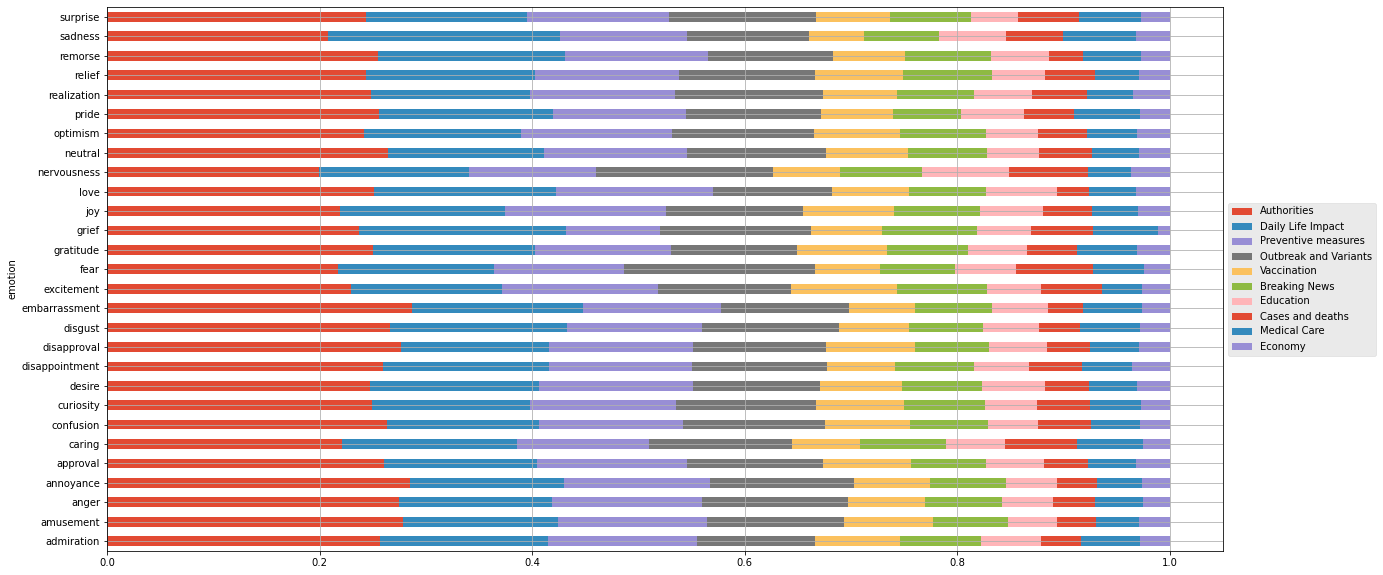

In [137]:
fig, ax = plt.subplots(1,1,figsize=(20, 10), sharex=True)
with plt.style.context(['ggplot']):
    emotion_themes[ordered_themes].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Distribution per account

In [71]:
pd.options.display.max_rows = 150

### Themes per account

In [ ]:
account_themes = comments.groupby('in_reply_to_user_id').theme.value_counts(normalize=True).rename('theme_prop').reset_index().pivot(index='in_reply_to_user_id', columns='theme', values='theme_prop')
account_themes.reset_index().merge(news_accounts[['author_id', 'display_name']], left_on='in_reply_to_user_id', right_on='author_id')[['display_name'] + list(account_themes.columns)]

In [73]:
account_themes = comments[comments.country=='KE'].groupby('in_reply_to_user_id').theme.value_counts(normalize=True).rename('theme_prop').reset_index().pivot(index='in_reply_to_user_id', columns='theme', values='theme_prop')
account_themes.reset_index().merge(news_accounts[['author_id', 'display_name']], left_on='in_reply_to_user_id', right_on='author_id')[['display_name', 'author_id'] + list(account_themes.columns)]

display_name  author_id  Authorities  Breaking News  \
0                   CNN     759251          NaN            NaN   
1                K24 TV   20087934     0.243781       0.050657   
2         Nation Africa   25979455     0.263977       0.028469   
3             NTV Kenya   25985333     0.193827       0.079044   
4         Kenyans.co.ke   38737371     0.151952       0.120278   
5  The Standard Digital   53037279     0.197548       0.078391   
6      Citizen TV Kenya   70394965     0.204118       0.039731   
7     KBC Channel1 News  248697646     0.204082       0.118995   

   Cases and deaths  Daily Life Impact   Economy  Education  Medical Care  \
0               NaN                NaN       NaN        NaN      1.000000   
1          0.023700           0.210847  0.039020   0.053059      0.043931   
2          0.047818           0.148362  0.053555   0.063370      0.057766   
3          0.044331           0.155008  0.040481   0.087001      0.060955   
4          0.096496           0.132274  0.054614   0.089235      0.105335   
5          0.043821           0.161252  0.035057   0.053028      0.049442   
6          0.104383           0.132179  0.039199   0.072426      0.084194   
7          0.076923           0.165777  0.041758   0.073155      0.057457   

   Outbreak and Variants  Preventive measures  Vaccination  
0                    NaN                  NaN          NaN  
1               0.141454             0.142735     0.050817  
2               0.128034             0.126824     0.081825  
3               0.123284             0.119192     0.096876  
4               0.054614             0.133537     0.061665  
5               0.180197             0.126239     0.075027  
6               0.106270             0.137801     0.079698  
7               0.103925             0.099529     0.058399

### Emotions per account

In [70]:
account_emotions = comments.groupby('in_reply_to_user_id').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='in_reply_to_user_id', columns='emotion', values='emotion_prop')
account_emotions.reset_index().merge(news_accounts[['author_id', 'display_name']], left_on='in_reply_to_user_id', right_on='author_id')[['display_name'] + list(account_emotions.columns)]

display_name  admiration  amusement     anger  annoyance  \
0          BBC News (UK)    0.038590   0.014421  0.031050   0.075220   
1               IOL News    0.030690   0.021118  0.025362   0.065560   
2                    CNN    0.045114   0.019476  0.032019   0.077081   
3     The New York Times    0.046758   0.018919  0.030248   0.067847   
4               Fox News    0.040562   0.023547  0.036991   0.091394   
..                   ...         ...        ...       ...        ...   
105                Naija    0.021388   0.037335  0.015381   0.049508   
106             TheCable    0.034203   0.033225  0.016854   0.061766   
107      CNN Philippines    0.026813   0.024492  0.027829   0.039876   
108             Republic    0.054773   0.012313  0.018371   0.065303   
109  TheMalaysianInsight    0.032180   0.024776  0.027908   0.061655   

     approval    caring  confusion  curiosity    desire  disappointment  \
0    0.037924  0.012704   0.056895   0.062595  0.002224        0.018871   
1    0.039370  0.009275   0.054121   0.077000  0.003141        0.017467   
2    0.036108  0.016224   0.049170   0.053381  0.002489        0.016517   
3    0.038324  0.014651   0.048367   0.051036  0.002751        0.018792   
4    0.038839  0.010652   0.049001   0.053801  0.001417        0.014870   
..        ...       ...        ...        ...       ...             ...   
105  0.034001  0.012990   0.042399   0.064165  0.003114        0.013840   
106  0.035990  0.017409   0.046481   0.075831  0.002366        0.016721   
107  0.042841  0.027223   0.039827   0.050738  0.002714        0.014406   
108  0.043549  0.018711   0.047300   0.063010  0.002781        0.016651   
109  0.043714  0.025488   0.055105   0.059376  0.002421        0.019365   

     disapproval   disgust  embarrassment  excitement      fear  gratitude  \
0       0.031853  0.008522       0.005910    0.003384  0.012619   0.016977   
1       0.031984  0.005921       0.004011    0.003035  0.009063   0.017679   
2       0.032292  0.008691       0.004833    0.003838  0.012392   0.023399   
3       0.031717  0.009562       0.004868    0.004918  0.012295   0.023218   
4       0.035216  0.008246       0.004418    0.002883  0.008726   0.018984   
..           ...       ...            ...         ...       ...        ...   
105     0.025760  0.003743       0.002548    0.003617  0.005190   0.014783   
106     0.022371  0.003211       0.005771    0.002487  0.005940   0.021864   
107     0.021380  0.003861       0.001660    0.005314  0.007225   0.027387   
108     0.024259  0.006334       0.009716    0.001875  0.008173   0.019319   
109     0.022925  0.004841       0.003560    0.002990  0.009825   0.027908   

        grief       joy      love  nervousness   neutral  optimism     pride  \
0    0.000021  0.005776  0.006311     0.001882  0.474457  0.022520  0.000713   
1    0.000064  0.004351  0.004797     0.000743  0.507269  0.020778  0.001040   
2    0.000035  0.004503  0.007442     0.000808  0.475681  0.020874  0.000934   
3    0.000040  0.005255  0.007144     0.001004  0.476777  0.023561  0.000910   
4    0.000027  0.003819  0.005877     0.000352  0.492565  0.015420  0.000626   
..        ...       ...       ...          ...       ...       ...       ...   
105  0.000031  0.003114  0.005473     0.000535  0.590602  0.017111  0.000849   
106  0.000060  0.004141  0.004829     0.000567  0.528692  0.021804  0.001268   
107  0.000016  0.004260  0.004713     0.001038  0.554844  0.025235  0.000879   
108  0.000021  0.003843  0.004281     0.001040  0.520780  0.019496  0.002618   
109       NaN  0.001851  0.002421     0.002278  0.498078  0.023494  0.000285   

     realization    relief   remorse   sadness  surprise  
0       0.019972  0.001461  0.004680  0.014768  0.017677  
1       0.015897  0.000976  0.002886  0.012501  0.013902  
2       0.016177  0.001246  0.003900  0.016076  0.019300  
3       0.019436  0.001637  0.003343  0.016995  0.019626  
4       0.013469  0.001130  0.002995  0.008684  0.015

# Emotions vs News characteristics

### Initials

In [76]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller

emotions.sort()

### Tests

In [173]:
stat, p, lags, crit = kpss(weekly_country_emotions.loc[:, pd.IndexSlice[:, 'UK']]['surprise'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Stationary')
else:
	print('Probably not Stationary')

stat=1.180, p=0.010
Probably not Stationary


C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [143]:
for e in emotions:
    try:
        stat, p, lags, obs, crit, t = adfuller(weekly_emotions[e])
        if p > 0.05:
            print(e, '|', 'stat=%.3f, p=%.3f' % (stat, p), '| Probably NOT Stationary')
        else:
            print(e, '|', 'stat=%.3f, p=%.3f' % (stat, p), '| Probably Stationary')
    except Exception as exc: 
        print(e, '|', exc)        

admiration | stat=-3.799, p=0.003 | Probably Stationary
amusement | stat=-3.535, p=0.007 | Probably Stationary
anger | stat=-6.988, p=0.000 | Probably Stationary
annoyance | stat=-6.088, p=0.000 | Probably Stationary
approval | stat=-4.523, p=0.000 | Probably Stationary
caring | stat=-5.237, p=0.000 | Probably Stationary
confusion | stat=-6.643, p=0.000 | Probably Stationary
curiosity | stat=-3.386, p=0.011 | Probably Stationary
desire | stat=-2.203, p=0.205 | Probably NOT Stationary
disappointment | stat=-1.025, p=0.744 | Probably NOT Stationary
disapproval | stat=-2.745, p=0.067 | Probably NOT Stationary
disgust | stat=-7.500, p=0.000 | Probably Stationary
embarrassment | stat=-2.540, p=0.106 | Probably NOT Stationary
excitement | stat=-7.499, p=0.000 | Probably Stationary
fear | stat=-7.476, p=0.000 | Probably Stationary
gratitude | stat=-4.591, p=0.000 | Probably Stationary
grief | exog contains inf or nans
joy | stat=-3.754, p=0.003 | Probably Stationary
love | stat=-3.896, p=0.00

### Emotion x Time x Country

In [15]:
weekly_country_emotions = comments.groupby(['dsw', 'country']).emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='dsw', columns=['emotion', 'country'], values='emotion_prop')
weekly_country_emotions = weekly_country_emotions.fillna(0.0)

In [232]:
def get_stationarity_over_emotions(c, world=False):
    emolist = {}
    emolist['country'] = c if world==False else 'WD'
    for e in emotions:
        try:
            current_df = weekly_country_emotions.loc[:, pd.IndexSlice[:, c]][e] if world==False else weekly_emotions[e]
            stat, p, lags, obs, crit, t = adfuller(current_df)
            emolist[e] = np.round(p,2)
        except Exception as exc: 
            emolist[e] = 0.00
    return emolist

stationarity_test = pd.DataFrame([], columns=['country'] + emotions)
for country in comments.country.unique():
    emolist = get_stationarity_over_emotions(country)
    stationarity_test = stationarity_test.append(emolist, ignore_index=True)
emolist = get_stationarity_over_emotions('', world=True)
stationarity_test = stationarity_test.append(emolist, ignore_index=True)
stationarity_test = stationarity_test.set_index('country')

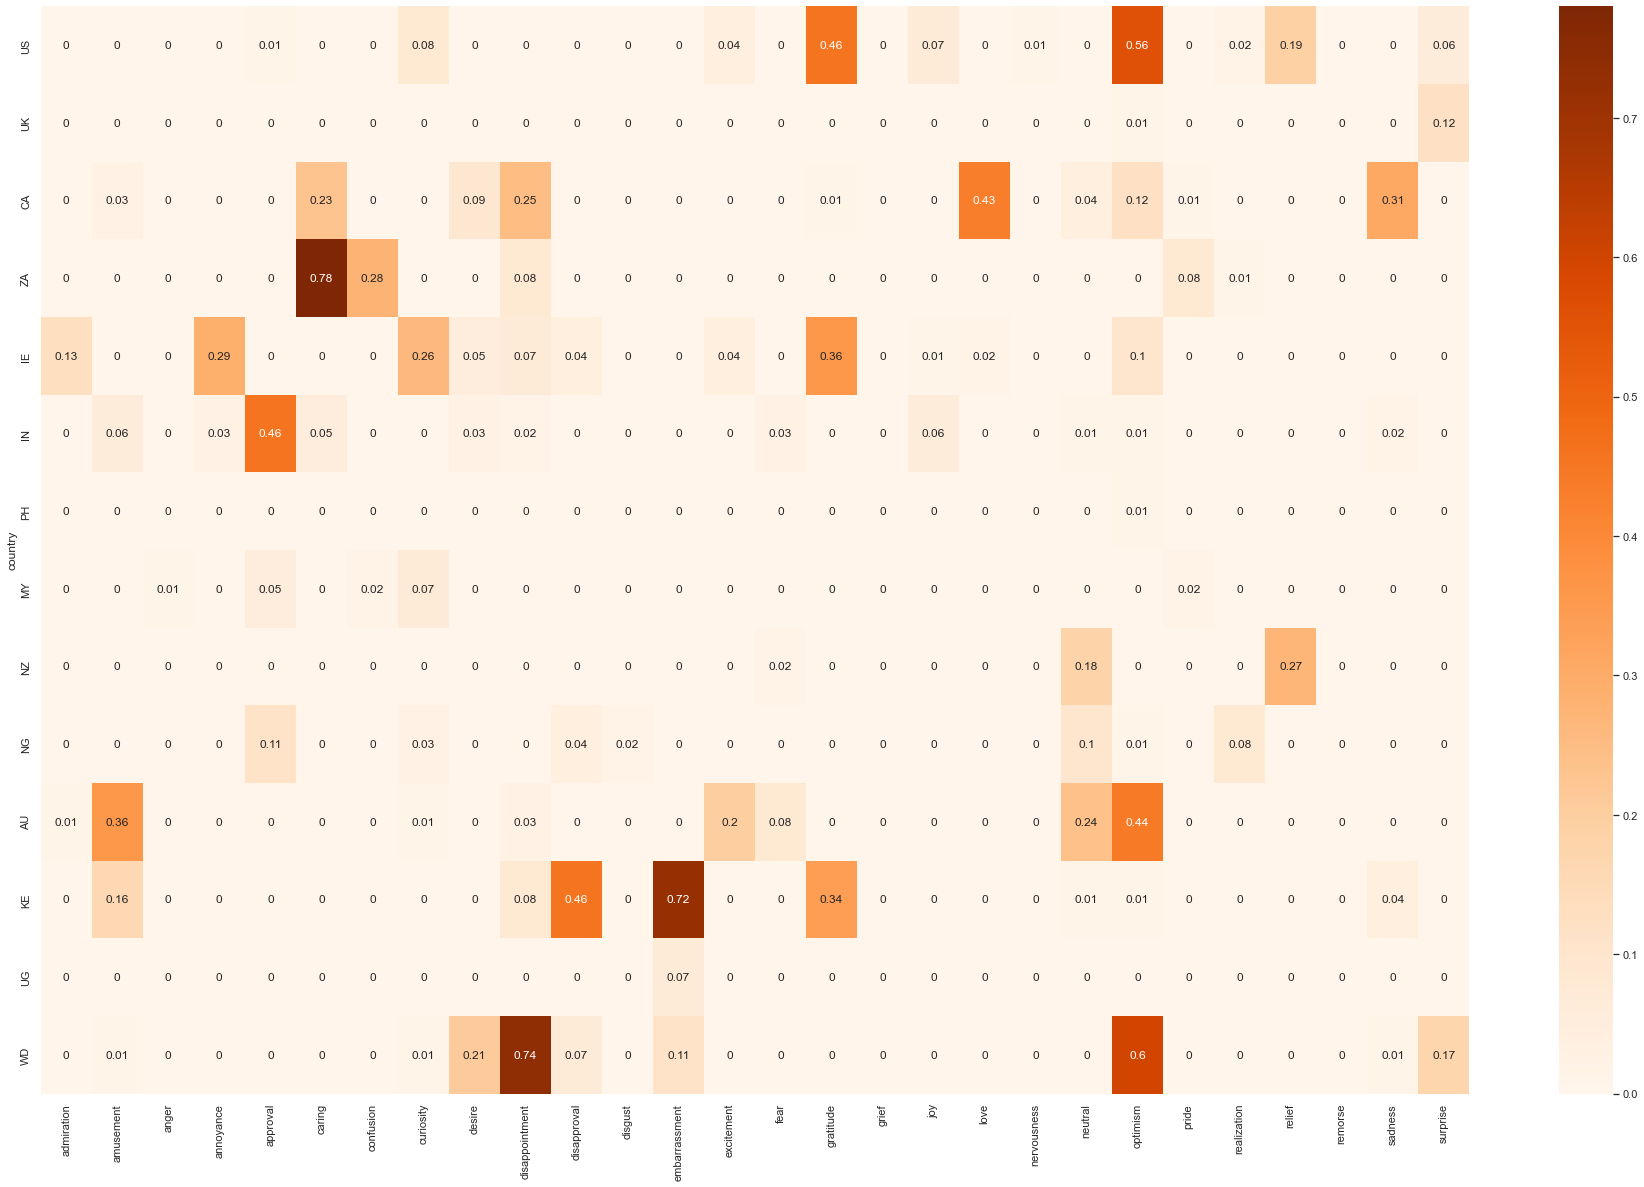

In [233]:
sns.heatmap(stationarity_test, annot=True, cmap='Oranges')
plt.show()

In [247]:
c = 'WD'
e = 'neutral'
period = 13

if c == 'WD':
    current_df = weekly_emotions
else:    
    current_df = weekly_country_emotions.loc[:, pd.IndexSlice[:, c]]
    current_df.columns = current_df.columns.droplevel(1)

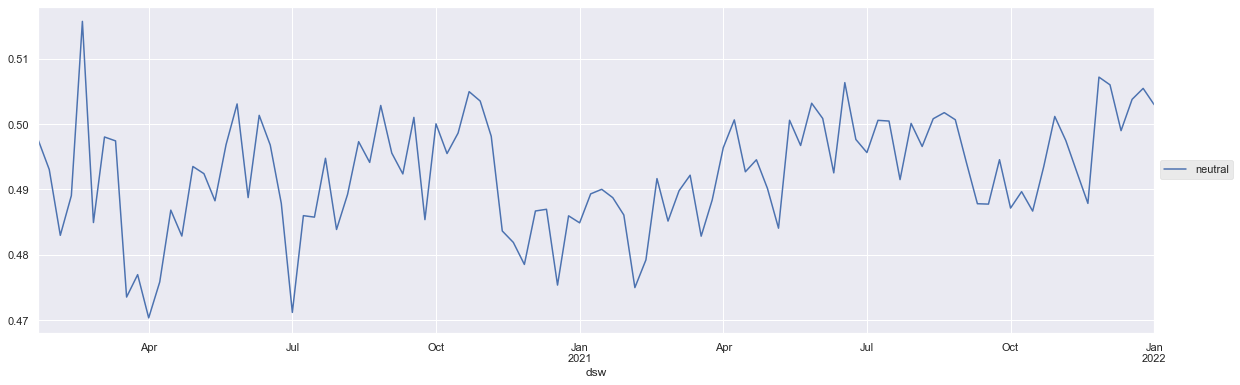

In [248]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    current_df[[e]].plot.line(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Account x Time x Theme

In [59]:
weekly_account_emotions = comments.groupby(['dsw', 'in_reply_to_user_id']).emotion.value_counts(normalize=True).rename('emotion_prop').reset_index()
weekly_account_emotions = weekly_account_emotions.merge(news_accounts[['author_id', 'display_name']], left_on='in_reply_to_user_id', right_on='author_id')
weekly_account_emotions = weekly_account_emotions.pivot_table(index='dsw', columns=['emotion', 'display_name'], values='emotion_prop', aggfunc='sum')
weekly_account_emotions = weekly_account_emotions.fillna(0.0)

In [77]:
def get_stationarity_over_emotions(c, population=False):
    emolist = {}
    emolist['account'] = c if population==False else 'Population'
    for e in emotions:
        try:
            current_df = weekly_account_emotions.loc[:, pd.IndexSlice[:, c]][e] if population==False else weekly_emotions[e]
            stat, p, lags, obs, crit, t = adfuller(current_df)
            emolist[e] = np.round(p,2)
        except Exception as exc: 
            emolist[e] = 0.00
    return emolist


stationarity_test = pd.DataFrame([], columns=['account'] + emotions)
for account in news_accounts.display_name.unique():
    emolist = get_stationarity_over_emotions(account)
    stationarity_test = stationarity_test.append(emolist, ignore_index=True)
emolist = get_stationarity_over_emotions('', population=True)
stationarity_test = stationarity_test.append(emolist, ignore_index=True)
stationarity_test = stationarity_test.set_index('account')

C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
 

C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 128251 (\N{RADIO}) missing from current font.
  fig.canvas.draw()
C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\seaborn\utils.py:660: UserWarning: Glyph 128251 (\N{RADIO}) missing from current font.
  bboxes = [l.get_window_extent() for l in labels]
C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128251 (\N{RADIO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


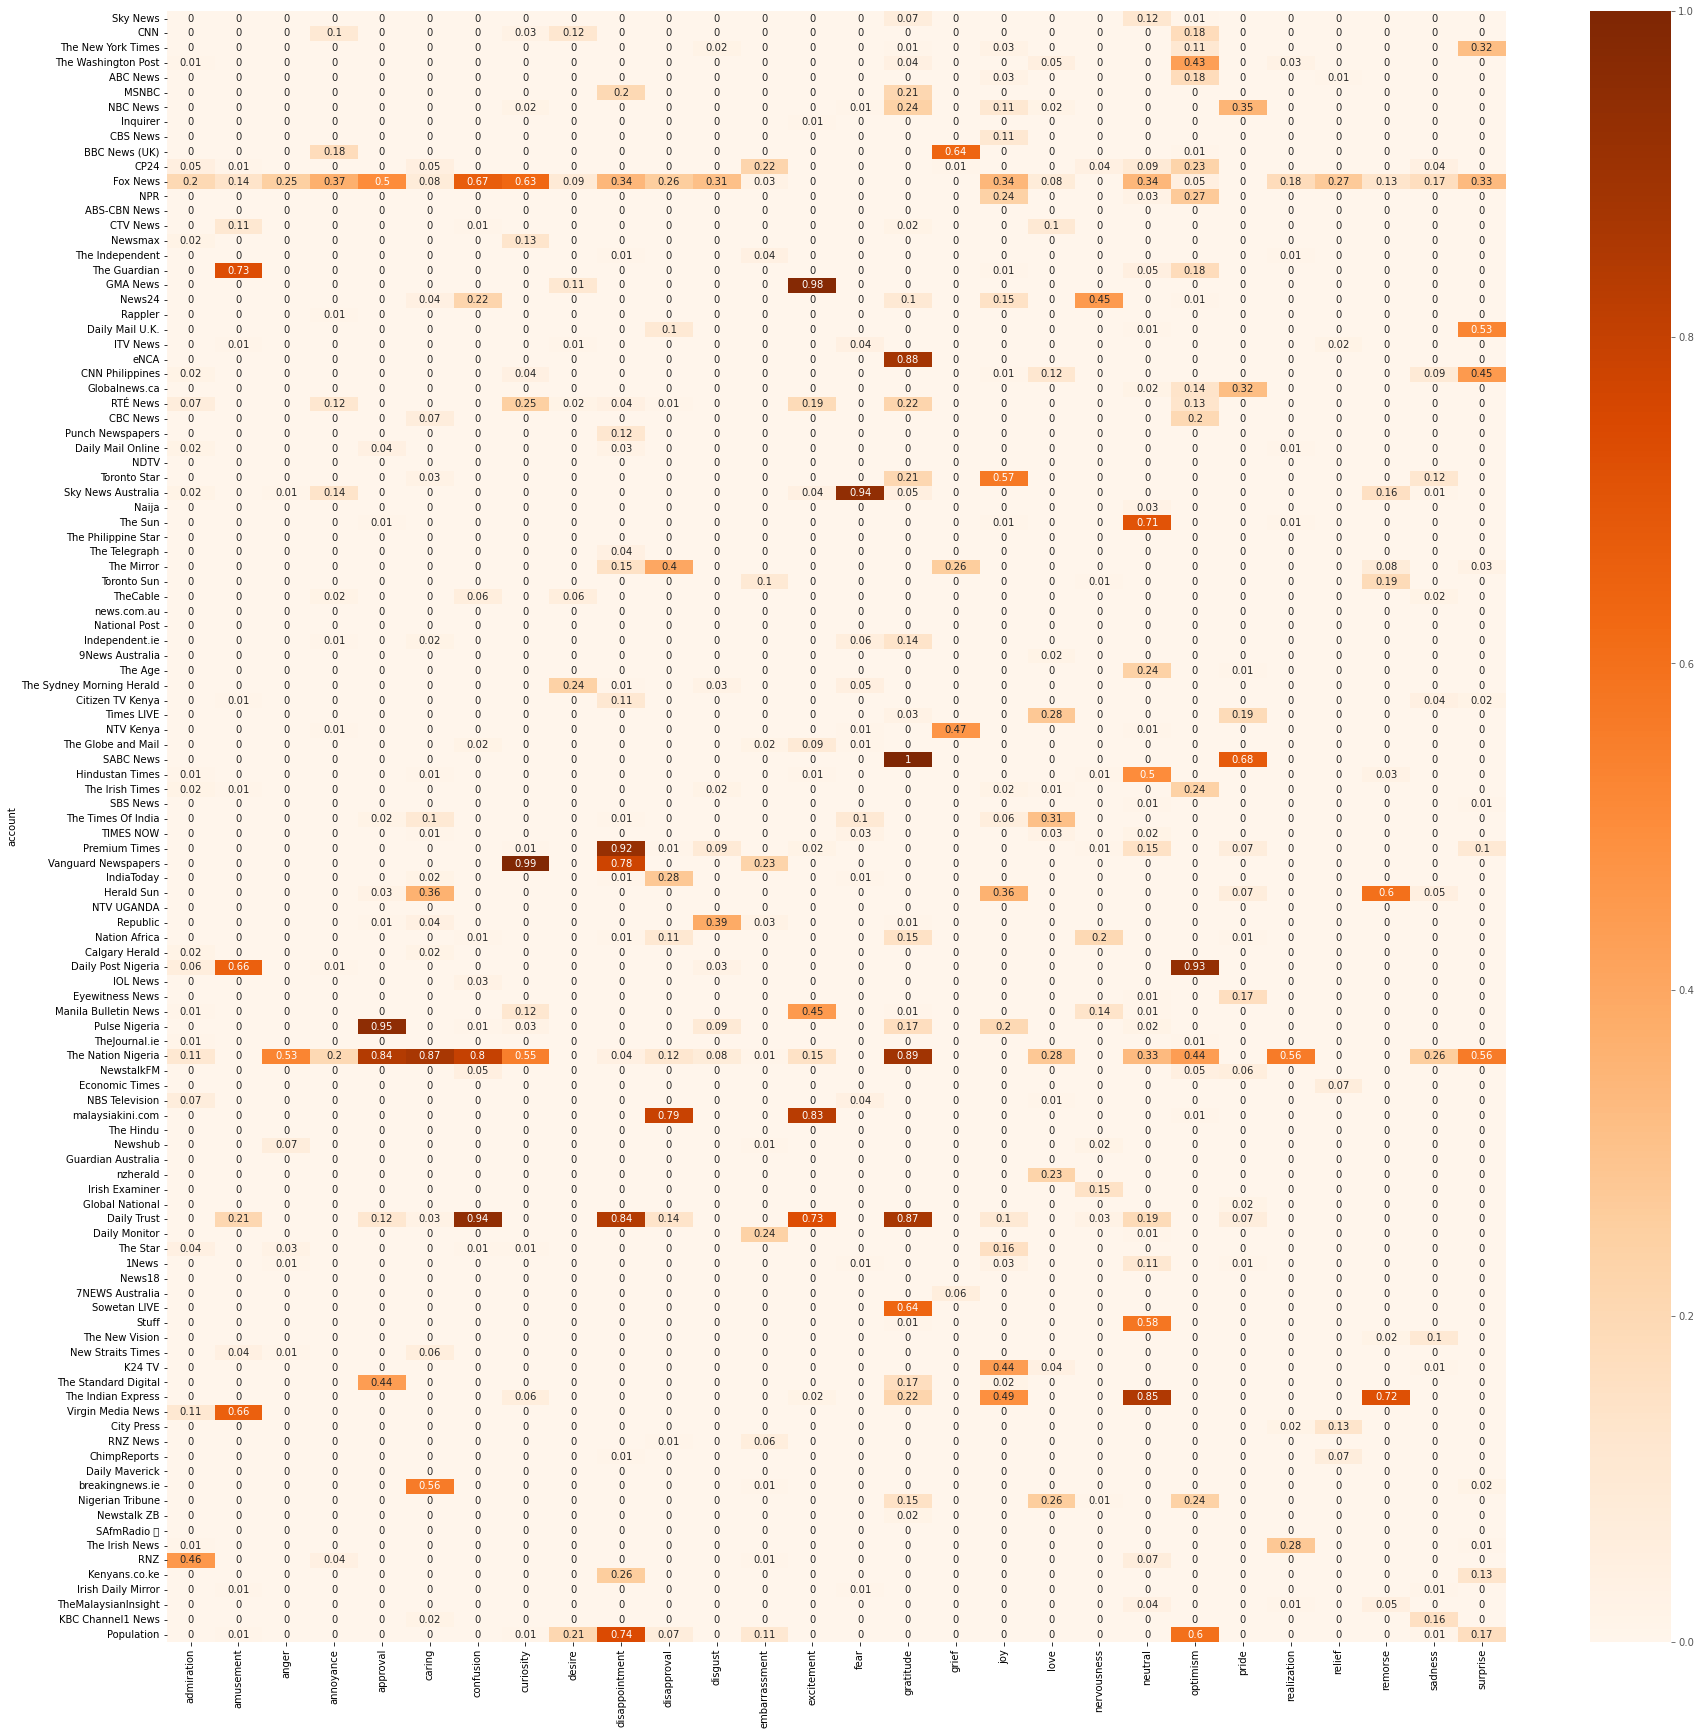

In [84]:
fig, ax = plt.subplots(1,1,figsize=(30, 30), sharex=True)
with plt.style.context(['ggplot']):
    sns.heatmap(stationarity_test, annot=True, cmap='Oranges')
    plt.show()

### Emotion x Time x Theme

In [250]:
weekly_theme_emotions = comments.groupby(['dsw', 'theme']).emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='dsw', columns=['emotion', 'theme'], values='emotion_prop')
weekly_theme_emotions = weekly_theme_emotions.fillna(0.0)

In [253]:
def get_stationarity_over_emotions(c, population=False):
    emolist = {}
    emolist['theme'] = c if population==False else 'Population'
    for e in emotions:
        try:
            current_df = weekly_theme_emotions.loc[:, pd.IndexSlice[:, c]][e] if population==False else weekly_emotions[e]
            stat, p, lags, obs, crit, t = adfuller(current_df)
            emolist[e] = np.round(p,2)
        except Exception as exc: 
            emolist[e] = 0.00
    return emolist

stationarity_test = pd.DataFrame([], columns=['theme'] + emotions)
for theme in comments.theme.unique():
    emolist = get_stationarity_over_emotions(theme)
    stationarity_test = stationarity_test.append(emolist, ignore_index=True)
emolist = get_stationarity_over_emotions('', population=True)
stationarity_test = stationarity_test.append(emolist, ignore_index=True)
stationarity_test = stationarity_test.set_index('theme')

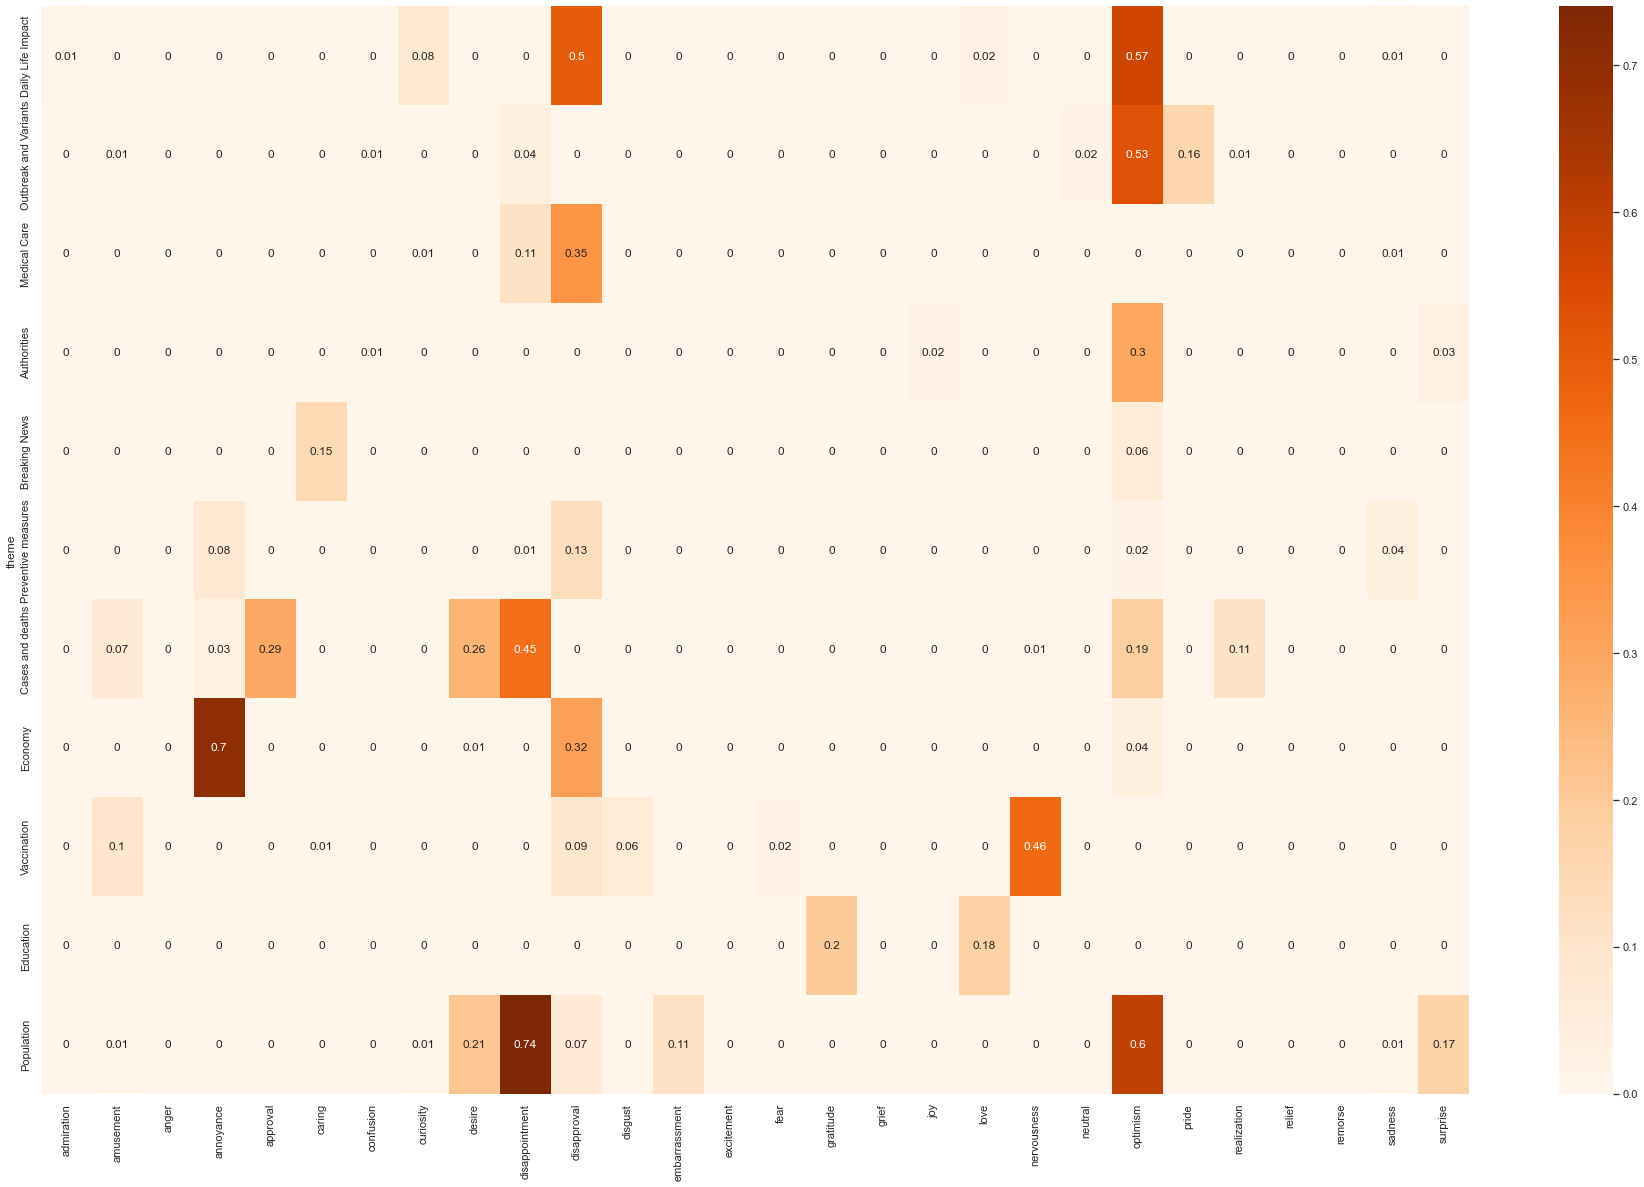

In [254]:
sns.heatmap(stationarity_test, annot=True, cmap='Oranges')
plt.show()

### Time series decomposition -- trend analysis

In [296]:
t = 'Medical Care'
e = 'disapproval'
period = 13

if t == 'Population':
    current_df = weekly_emotions
else:    
    current_df = weekly_theme_emotions.loc[:, pd.IndexSlice[:, t]]
    current_df.columns = current_df.columns.droplevel(1)

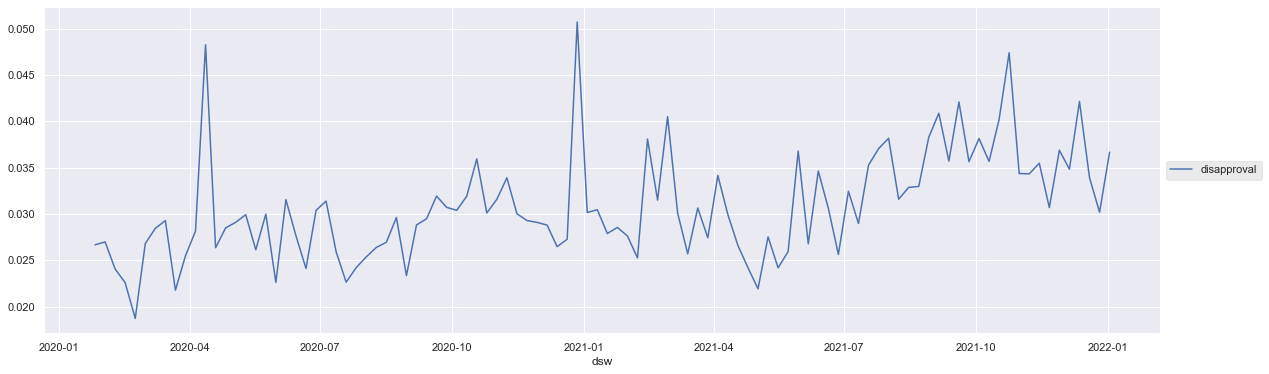

In [297]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    current_df[[e]].plot.line(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

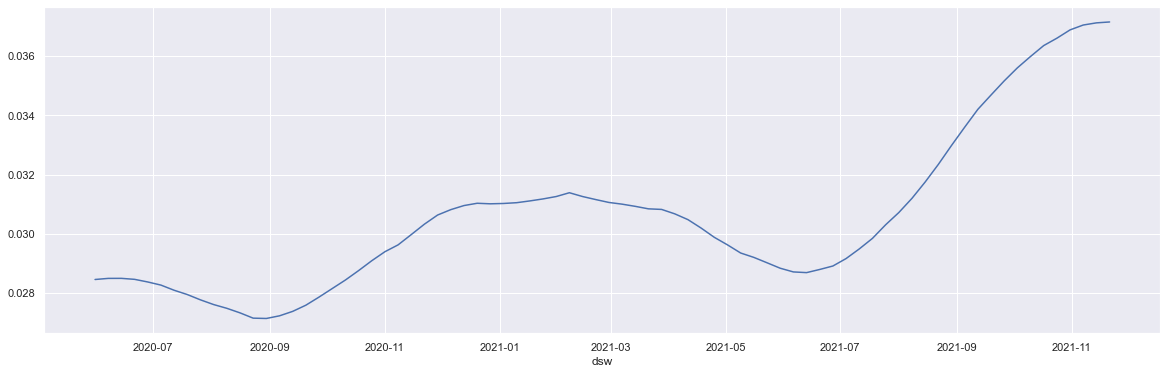

In [298]:
result=seasonal_decompose(current_df[e], period=period)

fig, ax = plt.subplots(1,1,figsize=(20, 6))
with plt.style.context(['ggplot']):
    result.trend.rolling(period).mean().plot()

In [128]:
weekly_emotions['annoyance']

dsw
2020-01-26    0.053614
2020-02-02    0.059195
2020-02-09    0.056826
2020-02-16    0.054629
2020-02-23    0.063612
                ...   
2021-12-05    0.076371
2021-12-12    0.082975
2021-12-19    0.076292
2021-12-26    0.073422
2022-01-02    0.076859
Name: annoyance, Length: 102, dtype: float64

### Correlations

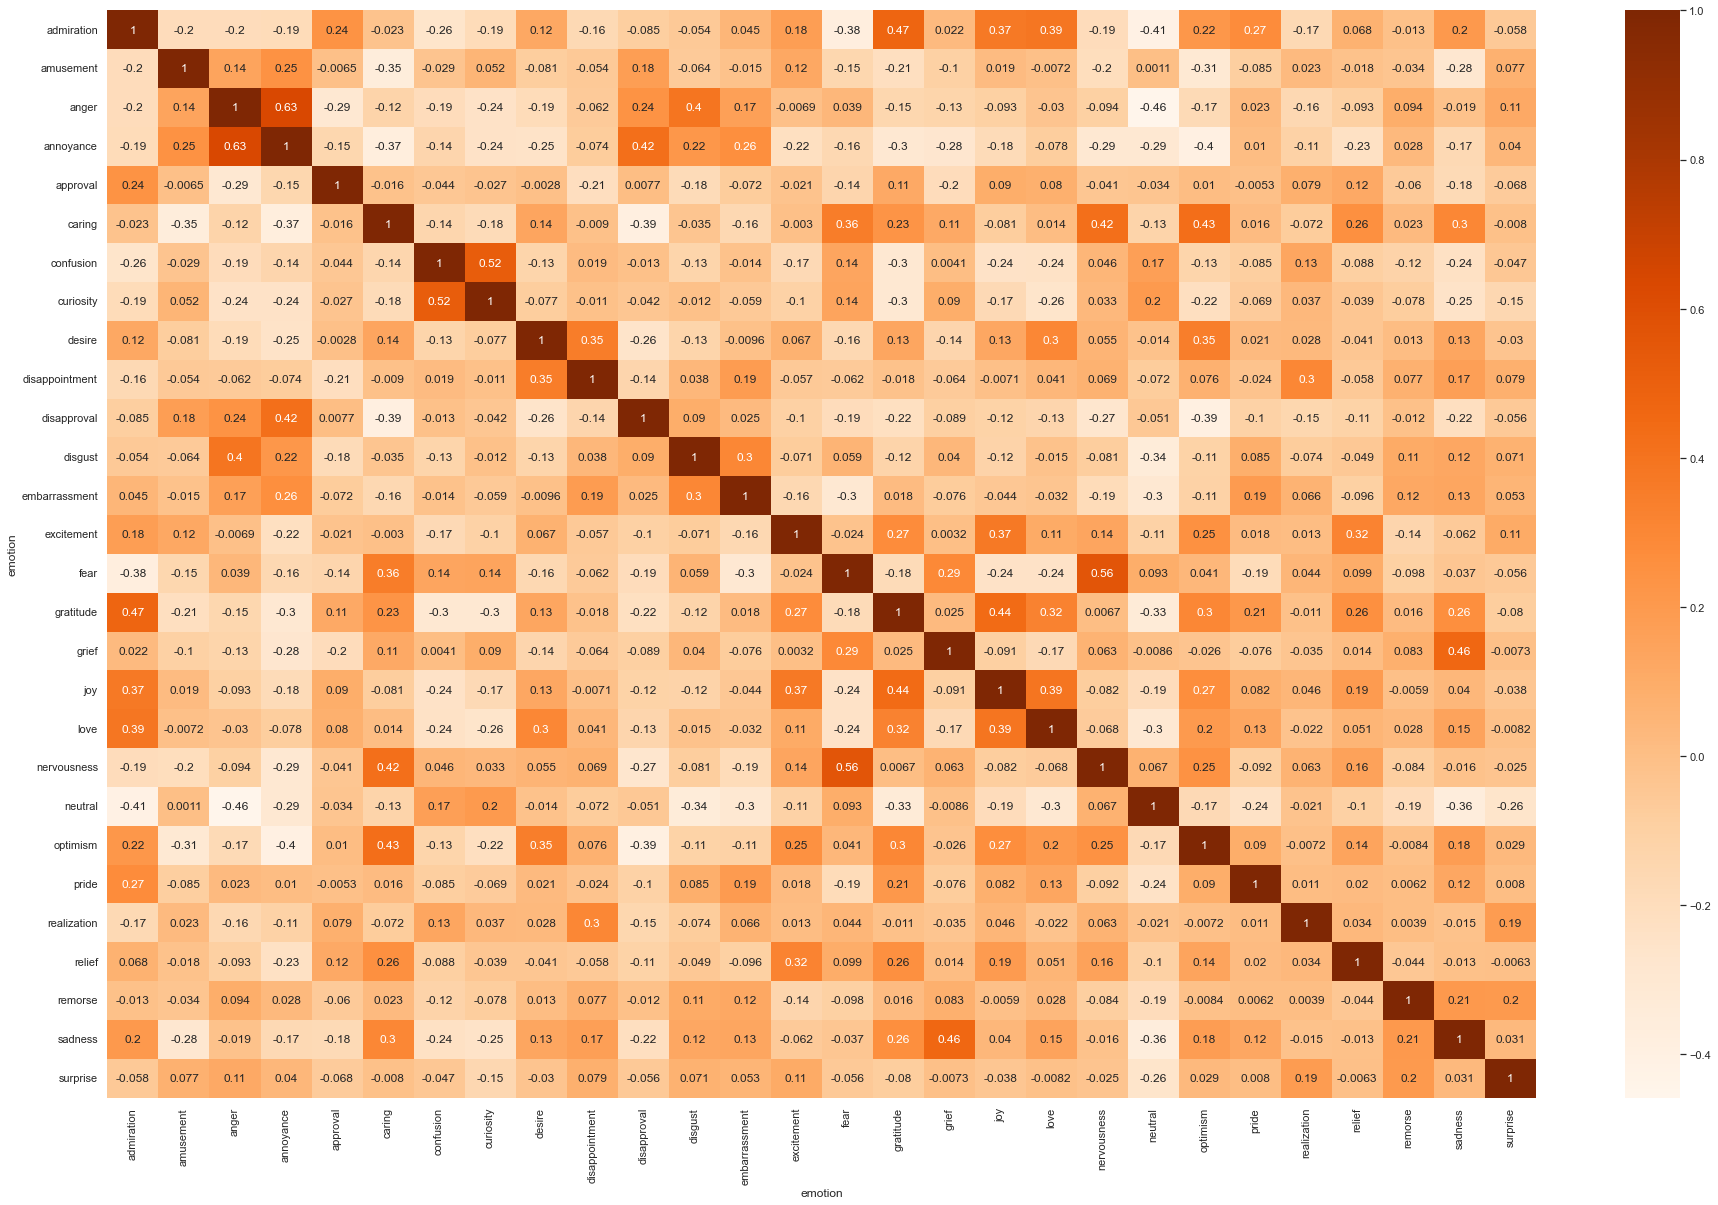

In [90]:
c = 'US'
sns.set(rc={'figure.figsize':(32,20)})
sns.heatmap(gen_corr[emotions].sort_index(), annot=True, cmap='Oranges')
plt.show()

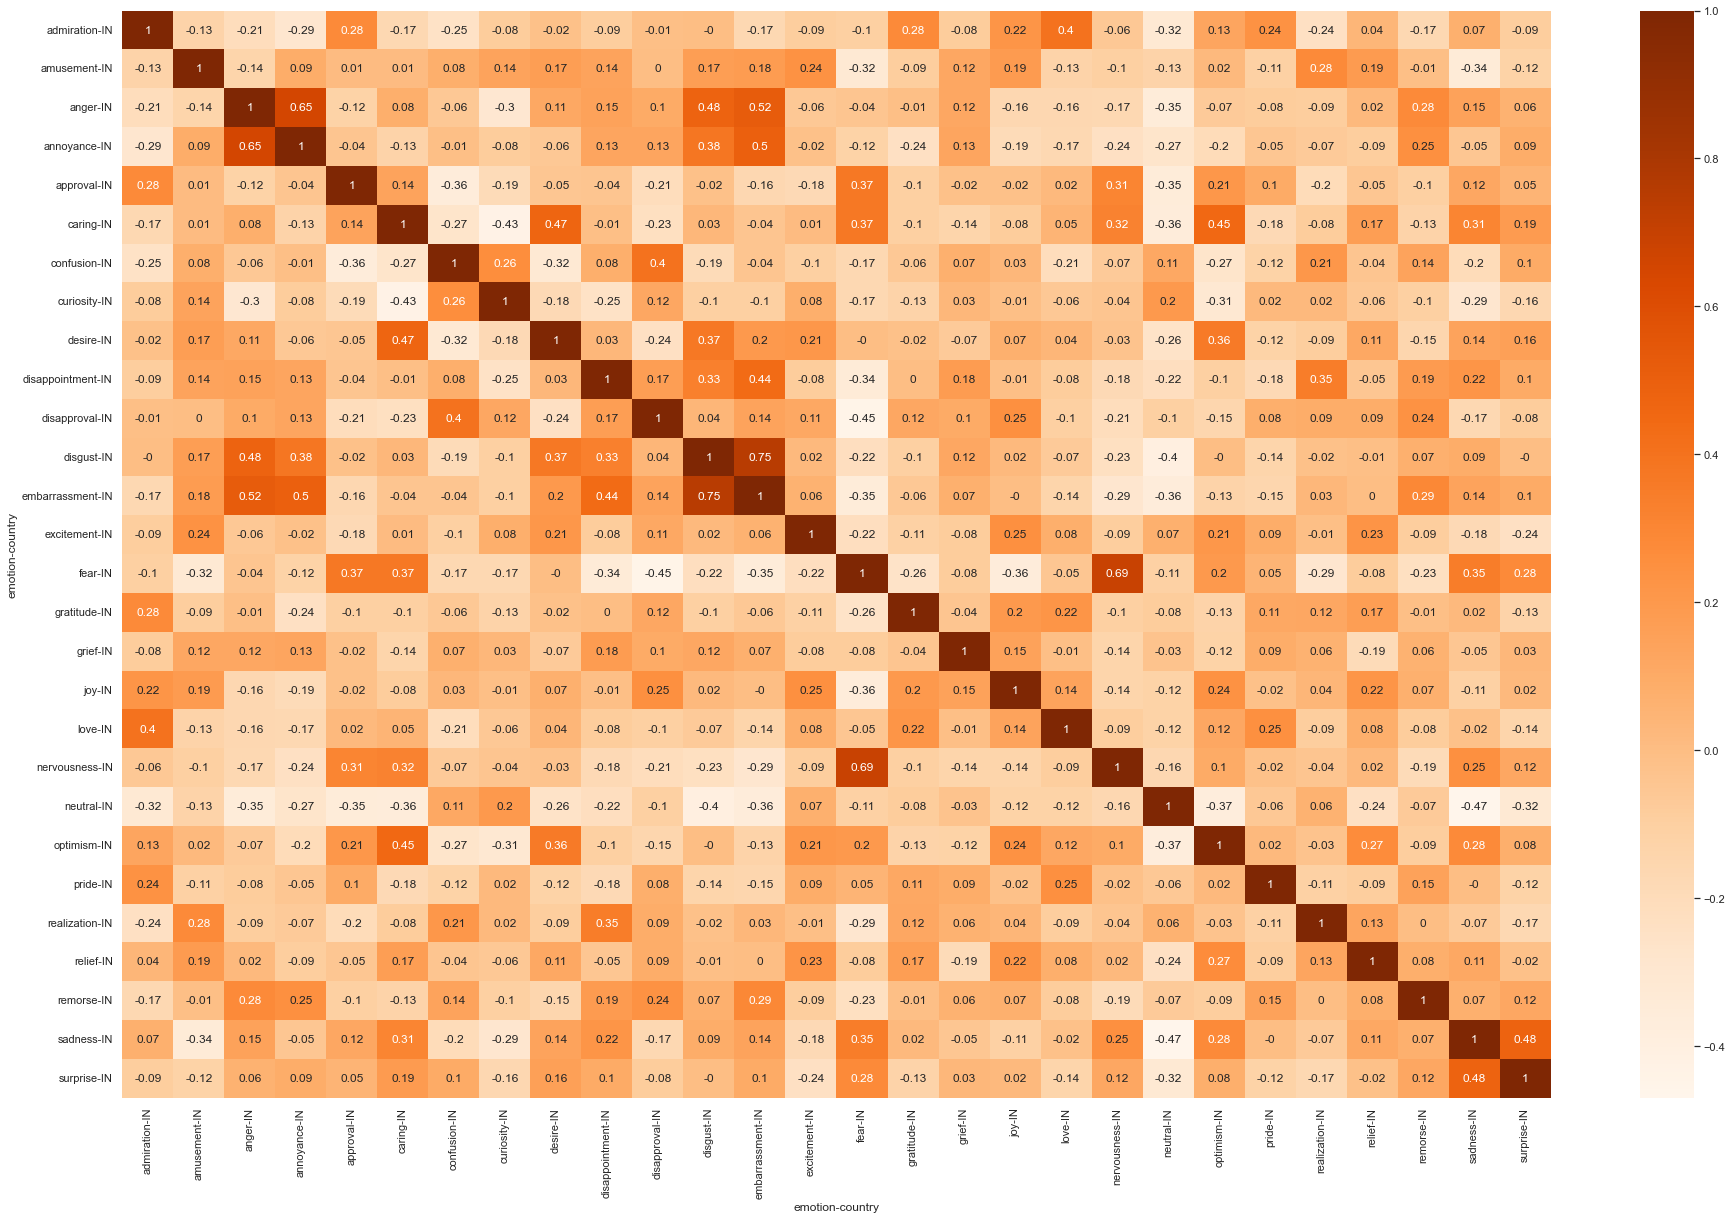

In [82]:
c = 'IN'
sns.set(rc={'figure.figsize':(32,20)})
sns.heatmap(corrMatrix.loc[pd.IndexSlice[:, c], pd.IndexSlice[:, c]][emotions].sort_index(), annot=True, cmap='Oranges')
plt.show()

### Chi-squared test

In [45]:
# Theme x Sentiment 
counter = comments[['theme','sentiment']].value_counts().rename('prop').reset_index()
col = 'sentiment'
for theme in comments.theme.unique():
    trial = counter.copy()
    trial['is_theme'] = trial.theme == theme

    trial = trial.groupby(['is_theme', col])['prop'].sum().reset_index().pivot(index='is_theme', columns=col, values='prop')

    trial.loc['All']= trial.sum(numeric_only=True, axis=0)
    trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
    
    print(theme, np.round(chi2_contingency(trial)[1],2))

Daily Life Impact 0.0
Outbreak and Variants 0.0
Medical Care 0.0
Authorities 0.0
Breaking News 0.0
Preventive measures 0.0
Cases and deaths 0.0
Economy 0.0
Vaccination 0.0
Education 0.0


In [48]:
# Theme x Emotion 
counter = comments[['theme','emotion']].value_counts().rename('prop').reset_index()
col = 'emotion'
for theme in comments.theme.unique():
    trial = counter.copy()
    trial['is_theme'] = trial.theme == theme

    trial = trial.groupby(['is_theme', col])['prop'].sum().reset_index().pivot(index='is_theme', columns=col, values='prop')

    trial.loc['All']= trial.sum(numeric_only=True, axis=0)
    trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
    
    print(theme, np.round(chi2_contingency(trial)[1],2))

Daily Life Impact 0.0
Outbreak and Variants 0.0
Medical Care 0.0
Authorities 0.0
Breaking News 0.0
Preventive measures 0.0
Cases and deaths 0.0
Economy 0.0
Vaccination 0.0
Education 0.0


In [18]:
# Theme x Sentiment (each)
counter = comments[['theme','sentiment']].value_counts().rename('prop').reset_index()
col = 'sentiment'
themes = comments.theme.unique()
sentiments = comments.sentiment.unique()
chi_squared_group = pd.DataFrame([], columns=sentiments)
for theme in themes:
    theme_sentiments = []
    for sentiment in sentiments:
        trial = counter.copy()
        trial['is_theme'] = trial.theme == theme
        trial['is_sentiment'] = trial.sentiment == sentiment

        trial = trial.groupby(['is_theme', 'is_sentiment'])['prop'].sum().reset_index().pivot(index='is_theme', columns='is_sentiment', values='prop')

        trial.loc['All']= trial.sum(numeric_only=True, axis=0)
        trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
        theme_sentiments.append(np.round(chi2_contingency(trial)[1],2))

    print(theme_sentiments)
    chi_squared_group.loc[chi_squared_group.shape[0],:] = theme_sentiments
chi_squared_group.index = themes

[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.14, 0.0]
[0.0, 0.13, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]


In [19]:
chi_squared_group

sentiment_negative sentiment_ambiguous  \
Daily Life Impact                    0.0                 0.0   
Outbreak and Variants                0.0                 0.0   
Medical Care                         0.0                 0.0   
Authorities                          0.0                 0.0   
Breaking News                        0.0                 0.0   
Preventive measures                  0.0                0.13   
Cases and deaths                     0.0                 0.0   
Economy                              0.0                 0.0   
Vaccination                          0.0                 0.0   
Education                            0.0                 0.0   

                      sentiment_neutral sentiment_positive  
Daily Life Impact                   0.0                0.0  
Outbreak and Variants               0.0                0.0  
Medical Care                        0.0                0.0  
Authorities                         0.0                0.0  
Breaking News                      0.14                0.0  
Preventive measures                 0.0                0.0  
Cases and deaths                    0.0                0.0  
Economy                             0.0                0.0  
Vaccination                         0.0                0.0  
Education                           0.0                0.0

In [14]:
# Theme x Emotion (each)
counter = comments[['theme','emotion']].value_counts().rename('prop').reset_index()
col = 'emotion'
chi_squared_group = pd.DataFrame([], columns=emotions)
for theme in comments.theme.unique():
    theme_emotions = []
    for emotion in emotions:
        trial = counter.copy()
        trial['is_theme'] = trial.theme == theme
        trial['is_emotion'] = trial.emotion == emotion

        trial = trial.groupby(['is_theme', 'is_emotion'])['prop'].sum().reset_index().pivot(index='is_theme', columns='is_emotion', values='prop')

        trial.loc['All']= trial.sum(numeric_only=True, axis=0)
        trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
        theme_emotions.append(np.round(chi2_contingency(trial)[1],2))

    print(theme_emotions)
    chi_squared_group.loc[chi_squared_group.shape[0],:] = theme_emotions

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.56, 0.0, 0.03, 0.0, 0.0, 0.02, 0.18, 0.0, 0.92, 0.0, 0.0, 0.0, 0.01, 0.0]
[0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.96, 0.56, 0.0, 0.0, 0.0, 0.64, 0.0, 0.72, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.51, 0.0, 0.0, 0.0, 0.92, 0.0, 0.59, 0.9, 0.36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.46, 0.0, 0.02, 0.0, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.74, 0.0, 0.0, 0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.0, 0.65, 0.1, 0.0, 0.0, 0.89, 0.0, 0.0, 0.0, 0.74, 0.0, 0.5, 0.27, 0.0, 0.0, 0.14, 0.0, 0.0, 0.0, 0.0, 0.14]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.43, 0.0, 0.0, 0.27, 0.79, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.51, 1.0, 0.99, 0.0, 0.06, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.99, 0.81, 0.2, 0.0, 0.0, 0.0, 1.0, 0

In [17]:
chi_squared_group

admiration amusement anger annoyance approval caring  \
Daily Life Impact            0.0       0.0   0.0       0.0      0.0    0.0   
Outbreak and Variants        0.0      0.05   0.0       0.0      0.0    0.0   
Medical Care                 0.0       0.0  0.51       0.0      0.0    0.0   
Authorities                  0.0       0.0   0.0       0.0     0.46    0.0   
Breaking News                0.0       0.0   0.0       0.0      0.0    0.0   
Preventive measures          0.0       0.0   0.0       0.0      0.0    0.0   
Cases and deaths             0.0       0.0   0.0       0.0      0.0    0.0   
Economy                     0.02      0.98   0.0       0.0      0.0    0.0   
Vaccination                  0.0       0.0   0.0       0.0      0.0    0.0   
Education                    0.0       0.0   0.0       0.0      0.0    0.0   

                      confusion curiosity desire disappointment disapproval  \
Daily Life Impact           0.0      0.75    0.0            0.0         0.0   
Outbreak and Variants       0.0      0.42    0.0            0.0         0.0   
Medical Care               0.92       0.0   0.59            0.9        0.36   
Authorities                0.02       0.0    0.0           0.12         0.0   
Breaking News              0.08       0.0   0.65            0.1         0.0   
Preventive measures        0.43       0.0    0.0           0.27        0.79   
Cases and deaths            0.0       0.0    0.0            0.0         0.0   
Economy                     0.0       0.0   0.07            0.0        0.85   
Vaccination                 0.0       0.0   0.92            0.0         0.0   
Education                   0.0       0.0    0.0           0.55         0.0   

                      disgust embarrassment excitement  fear gratitude grief  \
Daily Life Impact         0.0           0.0        0.0  0.56       0.0  0.03   
Outbreak and Variants    0.05           0.0        0.0   0.0       0.0  0.96   
Medical Care              0.0           0.0        0.0   0.0       0.0  0.55   
Authorities               0.0           0.0        0.0   0.0       0.0  0.74   
Breaking News             0.0          0.89        0.0   0.0       0.0  0.74   
Preventive measures       0.0           0.0        0.0   0.0       0.0  0.02   
Cases and deaths          0.0           0.0        0.0   0.0      0.99  0.81   
Economy                  0.25           0.0        0.0   0.0       0.0  0.14   
Vaccination               0.0           0.0        0.0   0.0       0.0  0.95   
Education                 0.0          0.19        0.9   0.0       0.0   1.0   

                        joy love nervousness optimism pride realization  \
Daily Life Impact       0.0  0.0        0.02     0.18   0.0        0.92   
Outbreak and Variants  0.56  0.0         0.0      0.0  0.64         0.0   
Medical Care            0.0  0.0         0.0     0.07   0.0         0.0   
Authorities             0.0  0.0         0.0      0.0  0.46         0.0   
Breaking News           0.0  0.5        0.27      0.0   0.0        0.14   
Preventive measures     0.0  0.0         0.0      0.0   0.0        0.51   
Cases and deaths        0.2  0.0         0.0      0.0   1.0         0.0   
Economy                0.11  0.0         0.0      0.0  0.95         0.0   
Vaccination             0.0  0.0         0.0      0.0   0.0         0.0   
Education               0.0  0.0         0.0     0.13   0.0         0.0   

                      relief remorse sadness surprise neutral  
Daily Life Impact        0.0     0.0     0.0     0.01     0.0  
Outbreak and Variants   0.72     0.0     0.0      0.0     0.0  
Medical Care            0.01     0.0     0.0      0.0     0.0  
Authorities              0.0     0.0     0.0      0.0     0.0  
Breaking News            0.0     0.0     0.0      0.0    0.14  
Preventive measures      1.0    0.99     0.0     0.06     0.0  
Cases and deaths        0.98     0.0     0.0      0.0     0.0  
Economy                  1.0    0.07     0.0      0.0     0.0  
Vaccinatio

- Authorities lidera em 'annoyance' e 'anger'
- Medical Care lidera em admiration
- Vaccination tem índices altos em approval e dissaproval e lidera em gratitude

In [252]:
counter = comments[['theme','emotion']].value_counts().rename('prop').reset_index()

In [258]:
theme = 'Vaccination'
emotion = 'gratitude'

trial = counter.copy()
trial['is_theme'] = trial.theme == theme
trial['is_emotion'] = trial.emotion == emotion

trial = trial.groupby(['is_theme', 'is_emotion'])['prop'].sum().reset_index().pivot(index='is_theme', columns='is_emotion', values='prop')

trial.loc['All']= trial.sum(numeric_only=True, axis=0)
trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
chi2_contingency(trial)[:3]

(470.1556029001751, 1.9057378704915535e-100, 4)

In [20]:
# Country x Sentiment (each)
counter = comments[['country','sentiment']].value_counts().rename('prop').reset_index()
col = 'sentiment'
countries = comments.country.unique()
sentiments = comments.sentiment.unique()
chi_squared_group = pd.DataFrame([], columns=sentiments)
for country in countries:
    country_sentiments = []
    for sentiment in sentiments:
        trial = counter.copy()
        trial['is_country'] = trial.country == country
        trial['is_sentiment'] = trial.sentiment == sentiment

        trial = trial.groupby(['is_country', 'is_sentiment'])['prop'].sum().reset_index().pivot(index='is_country', columns='is_sentiment', values='prop')

        trial.loc['All']= trial.sum(numeric_only=True, axis=0)
        trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
        country_sentiments.append(np.round(chi2_contingency(trial)[1],2))

    print(country_sentiments)
    chi_squared_group.loc[chi_squared_group.shape[0],:] = country_sentiments
chi_squared_group.index = countries

[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.04, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.74, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.42, 0.0, 0.0]


In [21]:
chi_squared_group

sentiment_negative sentiment_ambiguous sentiment_neutral sentiment_positive
US                0.0                 0.0               0.0                0.0
UK                0.0                 0.0               0.0                0.0
CA                0.0                 0.0               0.0                0.0
ZA                0.0                 0.0               0.0                0.0
IE                0.0                 0.0              0.04                0.0
IN                0.0                 0.0               0.0                0.0
PH                0.0                 0.0               0.0                0.0
MY                0.0                 0.0              0.74                0.0
NZ                0.0                 0.0               0.0                0.0
NG                0.0                 0.0               0.0                0.0
AU                0.0                 0.0               0.0                0.0
KE                0.0                 0.0               0.0                0.0
UG                0.0                0.42               0.0                0.0

In [18]:
# Country x Emotion (each)
counter = comments[['country','emotion']].value_counts().rename('prop').reset_index()
col = 'emotion'
chi_squared_group = pd.DataFrame([], columns=emotions)
for country in comments.country.unique():
    country_emotions = []
    for emotion in emotions:
        trial = counter.copy()
        trial['is_country'] = trial.country == country
        trial['is_emotion'] = trial.emotion == emotion

        trial = trial.groupby(['is_country', 'is_emotion'])['prop'].sum().reset_index().pivot(index='is_country', columns='is_emotion', values='prop')

        trial.loc['All']= trial.sum(numeric_only=True, axis=0)
        trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
        country_emotions.append(np.round(chi2_contingency(trial)[1],2))

    print(country_emotions)
    chi_squared_group.loc[chi_squared_group.shape[0],:] = country_emotions
chi_squared_group.index = comments.country.unique()

[0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.84, 0.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.09, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.99, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.63, 0.0, 0.0, 0.13, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.42, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.88, 0.0, 0.02, 0.0, 0.27, 0.34, 0.0, 0.0, 0.98, 0.0, 0.0, 0.04]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

- Uganda and Philippines have the lead on approval (10.7%, 9.4%), optimism (5.3%, 5.1%) and gratitude (6.1%, 6.5%)
- Canada have almost same values for approval (7.3%) and disapproval (7.2%) (X)
- Kenya have the lead on curiosity (16.3%) and confusion (12.5%)
- The US, UK and Australia have the lead on annoyance (15.3%, 14.8%, 16.2%) and anger (6.6%, 6.6%, 6.4%)

- The US leads on Authorities (32.6%)
- AU leads on Breaking News (22.4%)
- UK leads on Outbreak and Variants (17.4%)
- PH leads on Cases and Deaths (11.1%) and Preventive Measures (18.0%)
- UG leads on Education (18.3%)

In [19]:
chi_squared_group

admiration amusement anger annoyance approval caring confusion curiosity  \
US        0.0      0.02   0.0       0.0      0.0    0.0       0.0       0.0   
UK        0.0       0.0   0.0       0.0      0.0    0.0       0.0       0.0   
CA        0.0       0.0   0.0       0.0     0.09    0.0       0.0       0.0   
ZA        0.0       0.0   0.0       0.0      0.0    0.0       0.0       0.0   
IE        0.0       0.0   0.0       0.0      0.0    0.0       0.0       0.0   
IN        0.0       0.0   0.0       0.0      0.0    0.0      0.18       0.0   
PH        0.0       0.0   0.0       0.0      0.0    0.0       0.0       0.0   
MY        0.0      0.91   0.0       0.0      0.0    0.0       0.0       0.0   
NZ        0.0      0.01   0.0      0.76      0.0    0.0      0.39       0.0   
NG        0.0       0.0   0.0       0.0     0.01    0.0      0.18       0.0   
AU        0.0       0.0   0.0       0.0      0.0    0.0       0.0       0.0   
KE        0.0       0.0   0.0       0.0      0.0    0.0       0.0       0.0   
UG       0.02       0.0   0.0       0.0      0.0    0.0       0.0       0.0   

   desire disappointment disapproval disgust embarrassment excitement  fear  \
US    0.0            0.0         0.0     0.0           0.0        0.0   0.0   
UK    0.0            0.0         1.0     0.0           0.0        0.0   0.0   
CA    0.0           0.01         0.0     0.0           0.0       0.04   0.0   
ZA    0.0            0.0         0.0     0.0           0.0       0.22   0.0   
IE    0.0            0.0        0.11     0.0           0.0        0.0   0.0   
IN    0.0            0.0         0.0     0.0           0.0        0.0   0.0   
PH    0.0            0.0         0.0     0.0           0.0        0.0   0.0   
MY   0.79           0.49         0.0     0.0           0.0       0.35   0.0   
NZ   0.99           0.94         1.0     0.0           0.0       0.29  0.35   
NG    0.0            0.0         0.0     0.0          0.12        0.0   0.0   
AU    0.0            0.0         0.0    0.99          0.01        0.0  0.92   
KE    0.0           0.02         0.0     0.0           0.0        0.0   0.0   
UG    0.0            0.0         0.0     0.0           0.0        1.0   0.0   

   gratitude grief   joy  love nervousness optimism pride realization relief  \
US       0.0   0.0   0.0   0.0         0.0      0.0   0.0         0.0    0.0   
UK       0.0  0.84   0.0  0.98         0.0      0.0   0.0         0.0    0.0   
CA       0.0  0.99   0.0   0.0         0.1      0.0   0.0         0.0   0.63   
ZA       0.0   1.0   0.0   0.0         0.0      1.0   1.0         0.0    0.0   
IE       0.0  0.88   0.0  0.02         0.0     0.27  0.34         0.0    0.0   
IN       0.0   1.0   0.0   0.0         0.0      0.0   0.0         0.0    0.0   
PH       0.0  0.36  0.87   0.0         0.0      0.0   0.0         0.0    0.0   
MY       0.0   1.0   0.0   0.0         0.0      0.0   1.0        0.23   0.08   
NZ       0.0   1.0   0.0  0.99        0.02     0.97  0.93        0.13   0.99   
NG       0.0  0.42   0.0   0.0         0.0      0.0   0.0         0.0   0.86   
AU       0.0  0.22  0.58   0.0        0.49      0.0   0.0         0.0    0.0   
KE       0.0  0.96   0.0   0.0         0.0     0.15   0.0        0.01    0.0   
UG       0.0  0.99  0.99  0.59        0.17      0.0  0.14         0.0   0.18   

   remorse sadness surprise neutral  
US     0.0     0.0      0.0     0.0  
UK     0.0     0.0      0.0     0.0  
CA     0.0     0.0     0.13     0.0  
ZA    0.42     0.0      0.0     0.0  
IE    0.98     0.0      0.0    0.04  
IN     0.0     0.0      0.0     0.0  
PH     0.0     0.0     0.31     0.0  
MY    0.55     0.0      0.0    0.74  
NZ     0.0     0.0      0.0     0.0  
NG     0.0     0.0      0.0     0.0  
AU    0.69     0.0      0.0     0.0  
KE     0.0     0.0      0.0     0.0  
UG     0.0    0.36      0.0     0.0

In [32]:
news_accounts.head()

author_id        username         display_name  \
0    7587032         SkyNews             Sky News   
1     759251             CNN                  CNN   
2     807095         nytimes   The New York Times   
3    2467791  washingtonpost  The Washington Post   
4   28785486             ABC             ABC News   

                                         description  verified  \
0  We take you to the heart of the stories that s...      True   
1  It’s our job to #GoThere & tell the most diffi...      True   
2  News tips? Share them here: https://t.co/ghL9O...      True   
3                        Democracy Dies in Darkness.      True   
4  All the news and information you need to see, ...      True   

                  created_at  followers_count  following_count  tweet_count  \
0  2007-07-19 14:42:53+00:00          7374400               23       493585   
1  2007-02-09 00:35:02+00:00         55311684             1101       357579   
2  2007-03-02 20:41:42+00:00         50970475              856       453579   
3  2007-03-27 11:19:39+00:00         18460122             1716       409700   
4  2009-04-04 12:40:32+00:00         16948838              507       366464   

   listed_count  response_count country  
0         28442          147218      UK  
1        150727          121914      US  
2        211713          119932      US  
3        103961           66330      US  
4         63667           66289      US

In [29]:
accounts = comments.in_reply_to_user_id.unique()

In [39]:
pd.DataFrame(accounts, columns=['author_id'])

author_id
0       2467791
1      87818409
2       6433472
3      14697575
4      34655603
..          ...
105  1901298962
106    44900997
107   388368711
108    99960420
109     1367531

[110 rows x 1 columns]

In [41]:
# Account x Emotion (each)
counter = comments[['in_reply_to_user_id','emotion']].value_counts().rename('prop').reset_index()
col = 'emotion'
accounts = comments.in_reply_to_user_id.unique()
chi_squared_group = pd.DataFrame([], columns=emotions)
for account in accounts:
    account_emotions = []
    for emotion in emotions:
        trial = counter.copy()
        trial['is_account'] = trial.in_reply_to_user_id == account
        trial['is_emotion'] = trial.emotion == emotion

        trial = trial.groupby(['is_account', 'is_emotion'])['prop'].sum().reset_index().pivot(index='is_account', columns='is_emotion', values='prop')

        trial.loc['All']= trial.sum(numeric_only=True, axis=0)
        trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
        account_emotions.append(np.round(chi2_contingency(trial)[1],2))

    print(account_emotions)
    chi_squared_group.loc[chi_squared_group.shape[0],:] = account_emotions
chi_squared_group.index = pd.DataFrame(accounts, columns=['author_id']).merge(news_accounts[['author_id','display_name']]).display_name

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.35, 0.0, 0.0, 0.35, 0.0, 0.01, 0.0, 0.95, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83, 1.0, 0.0, 0.57, 0.61, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34, 0.0, 0.03, 0.0, 0.9, 0.0, 0.97, 0.28, 0.0, 0.0, 0.71, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.09, 0.39, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.99, 0.0, 0.0, 0.0, 0.26, 0.72, 0.0, 1.0, 0.01, 0.11, 0.0, 1.0, 0.86, 0.24, 0.0, 0.99, 0.11, 1.0, 0.12, 1.0, 0.52, 0.0, 0.74, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.74, 0.02, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.99, 0.0, 0.26, 0.0, 0.11, 0.17, 0.01, 0.0, 0.69, 0.0, 0.0, 1.0, 0.0, 0.02, 0.03, 1.0, 0.94, 0.0, 1.0, 0.0]
[0.99, 0.0, 0.0, 0.0, 0.37, 0.0, 0.0, 0.0, 0.02, 0.08, 0.98, 0.72, 0.76, 0.0, 1.0, 0.0, nan, 0.82, 0.0, 0.04, 1.0, 0.53, 0.8, 0.52, 1.0, 0.0, 0.17, 0.0]
[0.0, 0.0, 0.0, 0.35, 0.49, 0.0, 0.0, 0.98, 0.0, 0.08, 0.0, 0.27, 0.67, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0

In [42]:
chi_squared_group

admiration amusement anger annoyance approval caring  \
display_name                                                               
The Washington Post        0.0       0.0   0.0       0.0      0.0    0.0   
The Guardian               0.0       0.0   0.0       0.0      0.0    0.0   
CBC News                   0.0       0.0   0.0       0.0     0.99    0.0   
News24                     0.0       0.0   0.0       0.0      0.0    0.0   
The Sun                    0.0       0.0   0.0       0.0      0.0    0.0   
...                        ...       ...   ...       ...      ...    ...   
Naija                      0.0       0.0   0.0       0.0     0.02   0.83   
Nigerian Tribune          0.91       0.0   0.0       0.0     0.96    0.0   
ChimpReports              0.08      0.45   0.0       0.0      1.0   0.78   
The Irish News             0.0       0.2   0.0       0.0      0.4    1.0   
Fox News                   1.0       0.0   0.0       0.0      0.0    0.0   

                    confusion curiosity desire disappointment disapproval  \
display_name                                                                
The Washington Post       0.0       0.0    0.0           0.35         0.0   
The Guardian             0.34       0.0   0.03            0.0         0.9   
CBC News                  0.0       0.0   0.26           0.72         0.0   
News24                    0.0       0.0    0.0            0.0         0.0   
The Sun                   0.0       0.0   0.99            0.0        0.26   
...                       ...       ...    ...            ...         ...   
Naija                     0.0       0.0   0.11            0.0         0.0   
Nigerian Tribune         0.86       0.0   0.99           0.79         0.0   
ChimpReports             0.64       0.0   0.04           0.91         0.0   
The Irish News           0.84      0.42    1.0            1.0         1.0   
Fox News                  0.0       0.0    0.0            0.0         0.0   

                    disgust embarrassment excitement  fear gratitude grief  \
display_name                                                                 
The Washington Post     0.0          0.35        0.0  0.01       0.0  0.95   
The Guardian            0.0          0.97       0.28   0.0       0.0  0.71   
CBC News                1.0          0.01       0.11   0.0       1.0  0.86   
News24                  0.0           0.0       0.85   0.0       0.0   1.0   
The Sun                 0.0          0.11       0.17  0.01       0.0  0.69   
...                     ...           ...        ...   ...       ...   ...   
Naija                   0.0           0.0        1.0   0.0       0.0   1.0   
Nigerian Tribune        0.0          0.45       0.61  0.12       0.0   NaN   
ChimpReports            0.0          0.32        1.0  0.02       0.0   0.3   
The Irish News         0.77          0.28        1.0  0.66      0.93   NaN   
Fox News               0.66           0.0        0.0   0.0      0.04   1.0   

                      joy  love nervousness optimism pride realization relief  \
display_name                                                                    
The Washington Post   0.0   0.0         0.0      0.0   0.0        0.83    1.0   
The Guardian          0.0   0.0         0.0      0.0   1.0         0.0    0.0   
CBC News             0.24   0.0        0.99     0.11   1.0        0.12    1.0   
News24                0.0   0.0         0.0     0.74  0.02         0.0    0.0   
The Sun               0.0   0.0         1.0      0.0  0.02        0.03    1.0   
...                   ...   ...         ...      ...   ...         ...    ...   
Naija                 0.0  0.71        0.08      0.0   1.0         0.0   0.16   
Nigerian Tribune      0.1   0.0        0.14     0.93  0.46         0.0   0.26   
ChimpReports          1.0  0.98        0.97     0.06  0.96        0.82    1.0   
The Irish News        1.0   1.0        0.85     0.78  0.77        0.95   0.99   
Fox News              0.0  0.37         0.

In [51]:
# Country x Emotion 
counter = comments[['country','emotion']].value_counts().rename('prop').reset_index()
col = 'emotion'
for country in comments.country.unique():
    trial = counter.copy()
    trial['is_country'] = trial.country == country

    trial = trial.groupby(['is_country', col])['prop'].sum().reset_index().pivot(index='is_country', columns=col, values='prop')

    trial.loc['All']= trial.sum(numeric_only=True, axis=0)
    trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
    
    print(country, np.round(chi2_contingency(trial)[1],2))

US 0.0
UK 0.0
CA 0.0
ZA 0.0
IE 0.0
IN 0.0
PH 0.0
MY 0.0
NZ 0.0
NG 0.0
AU 0.0
KE 0.0
UG 0.0


In [67]:
# Country x Theme x Emotion 
counter = comments[['country', 'theme','emotion']].value_counts().rename('prop').reset_index()
col = 'emotion'
for country in comments.country.unique():
    for theme in comments.theme.unique():
        trial = counter.copy()
        trial['is_theme'] = trial.theme == theme
        trial['is_country'] = trial.country == country

        trial = trial.groupby(['is_theme', 'is_country', col])['prop'].sum().reset_index().pivot(index=['is_theme', 'is_country'], columns=col, values='prop')

        trial.loc['All']= trial.sum(numeric_only=True, axis=0)
        trial.loc[:,'All'] = trial.sum(numeric_only=True, axis=1)
        trial = trial.fillna(0)

        print(country, theme,np.round(100*chi2_contingency(trial)[1],2))

US Daily Life Impact 0.0
US Outbreak and Variants 0.0
US Medical Care 0.0
US Authorities 0.0
US Breaking News 0.0
US Preventive measures 0.0
US Cases and deaths 0.0
US Economy 0.0
US Vaccination 0.0
US Education 0.0
UK Daily Life Impact 0.0
UK Outbreak and Variants 0.0
UK Medical Care 0.0
UK Authorities 0.0
UK Breaking News 0.0
UK Preventive measures 0.0
UK Cases and deaths 0.0
UK Economy 0.0
UK Vaccination 0.0
UK Education 0.0
CA Daily Life Impact 0.0
CA Outbreak and Variants 0.0
CA Medical Care 0.0
CA Authorities 0.0
CA Breaking News 0.0
CA Preventive measures 0.0
CA Cases and deaths 0.0
CA Economy 0.0
CA Vaccination 0.0
CA Education 0.0
ZA Daily Life Impact 0.0
ZA Outbreak and Variants 0.0
ZA Medical Care 0.0
ZA Authorities 0.0
ZA Breaking News 0.0
ZA Preventive measures 0.0
ZA Cases and deaths 0.0
ZA Economy 0.0
ZA Vaccination 0.0
ZA Education 0.0
IE Daily Life Impact 0.0
IE Outbreak and Variants 0.0
IE Medical Care 0.0
IE Authorities 0.0
IE Breaking News 0.0
IE Preventive measures

# Relationship Analysis

1- calculate correlation between proportions of emotions/sentiments/themes weekly

2- calculate hypothesis for around 10 statements

We are going to use Chi-Squared test because our main variables are discrete and categorical

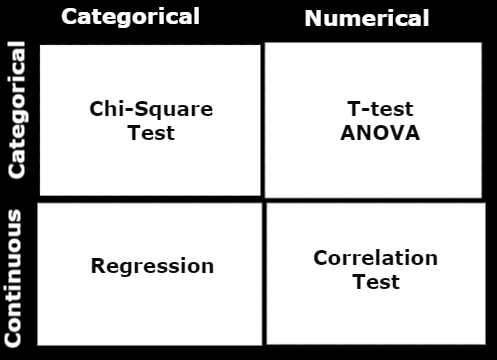

source: https://towardsdatascience.com/how-to-know-which-statistical-test-to-use-for-hypothesis-testing-744c91685a5d

### General Correlation

In [79]:
features

Authorities  Breaking News  Cases and deaths  Daily Life Impact  \
dsw                                                                           
2020-01-26          511            366               434                867   
2020-02-02         6733           3809              4852              10136   
2020-02-09         4509           2461              1923               7305   
2020-02-16         4361           3107              1432               3882   
2020-02-23         2035           3340               837               3948   
2020-03-01        28125          17428              3372              17435   
2020-03-08        42374          14720              7970              37640   
2020-03-15       115468          35099             18829             104336   
2020-03-22       154062          58757             27985             116268   
2020-03-29       169561          55810             27677             125302   
2020-04-05       176086          46900             21126             109506   
2020-04-12       143891          49142             16140             146225   
2020-04-19       139799          40110             16393              95503   
2020-04-26       138803          30575             13519              97343   
2020-05-03       101385          26231             13532              72680   
2020-05-10        92432          22858             14585              83399   
2020-05-17        95222          29826             13439              65172   
2020-05-24       107880          19978             10785              57380   
2020-05-31        99396          14856             13670              48664   
2020-06-07        41143          13256              8852              35637   
2020-06-14        44913          10774             17550              25703   
2020-06-21        48238          15774             15474              29452   
2020-06-28        67100          16756             25637              42661   
2020-07-05        55938          36266             19256              36874   
2020-07-12        71311          24704             20929              45214   
2020-07-19        89302          26629             17881              43158   
2020-07-26        65159          17376             11625              35583   
2020-08-02        73401          16043             10506              47630   
2020-08-09        52581          19152             10312              31829   
2020-08-16        40596          10764             10678              25183   
2020-08-23        37413          11241              9005              24496   
2020-08-30        39164           9760              7847              25129   
2020-09-06        37097           9909              7361              30641   
2020-09-13        54994          11944             17873              37313   
2020-09-20        60768          12427             10773              25977   
2020-09-27        41927          12793              9382              30039   
2020-10-04       114526          29633             11575              29902   
2020-10-11       165883          19558              8297              31968   
2020-10-18        68306          12535              8720              44333   
2020-10-25        63630          12537             14333              25498   
2020-11-01        74840          14314             19991              38812   
2020-11-08        68117           9116             11555              19976   
2020-11-15        58738          16882             12856              29604   
2020-11-22        63149          20019              9998              26231   
2020-11-29        41450           7934              8375              21576   
2020-12-06        49523          10147             13720              24005   
2020-12-13        58555          16323              7197              24563   
2020-12-20        59795          12746              8319              35725   
2020-12-27        64367          15027              9132      

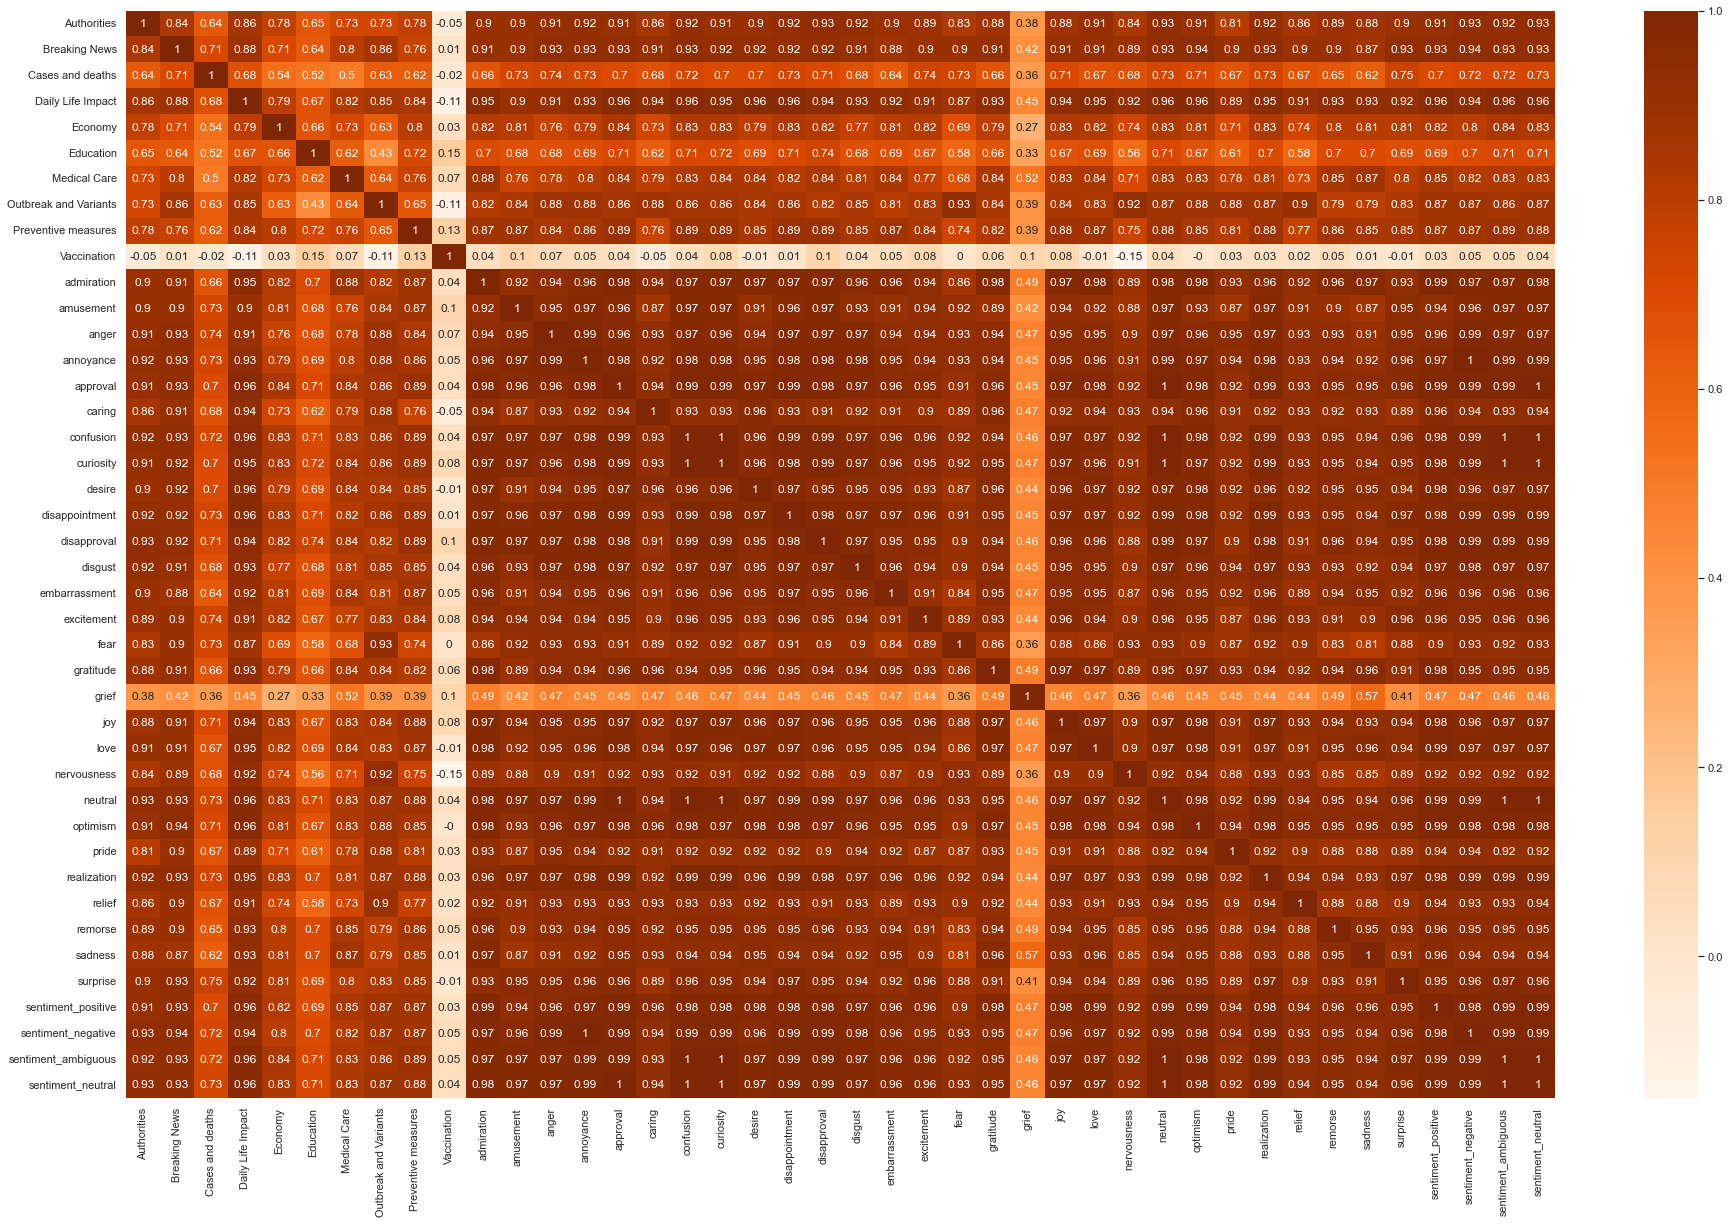

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

weekly_themes = comments.groupby('dsw').theme.value_counts().rename('theme_prop').reset_index().pivot(index='dsw', columns='theme', values='theme_prop')
weekly_emotions = comments.groupby('dsw').emotion.value_counts().rename('emotion_prop').reset_index().pivot(
    index='dsw', columns='emotion', values='emotion_prop'
)

for s, v in sentiment_lookup.items():
    weekly_emotions[s] = weekly_emotions[v].sum(axis=1)

features = pd.concat([weekly_themes, weekly_emotions], axis=1)
corrMatrix = np.round(features.corr(),2)

sns.set(rc={'figure.figsize':(32,20)})
sns.heatmap(corrMatrix, annot=True, cmap='Oranges')
plt.show()

### Chi-Squared to validate affirmations (JUST EXAMPLES!!!)

#### Q1: In the US, is there a relationship between the prevalence of the vaccination theme and the presence of optimism among comments?
A1: Yes, there is.

In [48]:
cs = comments[comments.country=='US'][['theme', 'emotion']]

In [49]:
cs.theme = cs.theme.apply(lambda x: 'Not Vaccination' if x != 'Vaccination' else x)
cs.emotion = cs.emotion.apply(lambda x: 'Not optimism' if x != 'optimism' else x)

In [50]:
ct = pd.crosstab(cs.theme, cs.emotion, margins=True)

In [51]:
ct

emotion          Not optimism  optimism      All
theme                                           
Not Vaccination       8301140    171798  8472938
Vaccination            792025     17332   809357
All                   9093165    189130  9282295

In [54]:
chi2_contingency(ct)[:3] #chi-squared, p-value, df

(47.97106534907865, 9.569827878194193e-10, 4)

#### Q2: In the population, is there a relationship between the prevalence of the vaccination theme and the month where the news were published?
A2: Yes, there is.

In [55]:
cs = comments[['theme', 'dsm']]

In [56]:
cs.theme = cs.theme.apply(lambda x: 'Not Vaccination' if x != 'Vaccination' else x)

C:\Users\olive\anaconda3\envs\ugpn\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [58]:
ct = pd.crosstab(cs.theme, cs.dsm, margins=True)

In [59]:
ct

dsm              2020-01-01 00:00:00  2020-02-01 00:00:00  \
theme                                                       
Not Vaccination                71144               238710   
Vaccination                      587                 7327   
All                            71731               246037   

dsm              2020-03-01 00:00:00  2020-04-01 00:00:00  \
theme                                                       
Not Vaccination              2145289              2304614   
Vaccination                    47000                59070   
All                          2192289              2363684   

dsm              2020-05-01 00:00:00  2020-06-01 00:00:00  \
theme                                                       
Not Vaccination              1485430               841673   
Vaccination                    52423                42930   
All                          1537853               884603   

dsm              2020-07-01 00:00:00  2020-08-01 00:00:00  \
theme                                                       
Not Vaccination              1118439               727890   
Vaccination                    48621                36729   
All                          1167060               764619   

dsm              2020-09-01 00:00:00  2020-10-01 00:00:00  \
theme                                                       
Not Vaccination               747411              1101637   
Vaccination                    33027                34372   
All                           780438              1136009   

dsm              2020-11-01 00:00:00  2020-12-01 00:00:00  \
theme                                                       
Not Vaccination               758257               822838   
Vaccination                    65912               131344   
All                           824169               954182   

dsm              2021-01-01 00:00:00  2021-02-01 00:00:00  \
theme                                                       
Not Vaccination               836392               561602   
Vaccination                   106040                72515   
All                           942432               634117   

dsm              2021-03-01 00:00:00  2021-04-01 00:00:00  \
theme                                                       
Not Vaccination               606335               654128   
Vaccination                    96956                90547   
All                           703291               744675   

dsm              2021-05-01 00:00:00  2021-06-01 00:00:00  \
theme                                                       
Not Vaccination               650681               519091   
Vaccination                    97941                73737   
All                           748622               592828   

dsm              2021-07-01 00:00:00  2021-08-01 00:00:00  \
theme                                                       
Not Vaccination               702891               825753   
Vaccination                   133650               100487   
All                           836541               926240   

dsm              2021-09-01 00:00:00  2021-10-01 00:00:00  \
theme                                                       
Not Vaccination               738233               608135   
Vaccination                   100190                95669   
All                           838423               703804   

dsm              2021-11-01 00:00:00  2021-12-01 00:00:00       All  
theme                                                                
Not Vaccination               611028               872083  20549684  
Vaccination                    68948               104491   1700513  
All                           679976               976574  22250197

In [60]:
chi2_contingency(ct)[:3] #chi-squared, p-value, df

(682553.5038192902, 0.0, 48)

#### Q3: It seems that the US (33%) and India (34%) comment more about the Authorities theme than other countries (population avg., 26%), is there evidence of it (i.e., is there a strong relationship between those countries and that theme)?
A3: Yes, there is.

In [64]:
cs = comments[['country', 'theme']]

cs.country = cs.country.apply(lambda x: 'Not US' if x != 'US' else x)
cs.theme = cs.theme.apply(lambda x: 'Not Authorities' if x != 'Authorities' else x)

ct = pd.crosstab(cs.theme, cs.country, margins=True)

ct

print(chi2_contingency(ct)[:3]) #chi-squared, p-value, df

(337358.55271257006, 0.0, 4)


In [65]:
cs = comments[['country', 'theme']]

cs.country = cs.country.apply(lambda x: 'Not India' if x != 'IN' else x)
cs.theme = cs.theme.apply(lambda x: 'Not Authorities' if x != 'Authorities' else x)

ct = pd.crosstab(cs.theme, cs.country, margins=True)

print(chi2_contingency(ct)[:3]) #chi-squared, p-value, df

ct

(42579.60992437099, 0.0, 4)


country               IN  Not India       All
theme                                        
Authorities       446058    5373814   5819872
Not Authorities   873062   15557263  16430325
All              1319120   20931077  22250197

#### Q4: It seems users comments to news about Economy at NTV Kenya twitter are on the average for Kenya, or is there a difference?
A4: No, there is not.

In [74]:
cs = comments[comments.country=='KE'][['author_id', 'theme']]

In [75]:
cs.author_id = cs.author_id.apply(lambda x: '25985333' if x != 25985333 else x)
cs.theme = cs.theme.apply(lambda x: 'Not Economy' if x != 'Economy' else x)

In [76]:
ct = pd.crosstab(cs.author_id, cs.theme, margins=True)

In [77]:
ct

theme      Economy  Not Economy     All
author_id                              
25985333         1           29      30
25985333     13238       298746  311984
All          13239       298775  312014

In [78]:
chi2_contingency(ct)[:3] #chi-squared, p-value, df

(0.061115528803717616, 0.9995425147863145, 4)

H1: Relationship between news emotions and comments emotions
H2: Relationship between vaccinations theme and positive emotions

# Trunk

In [ ]:
cs = comments.sample(100000)

In [64]:
comments.head()

tweet_id      conversation_id            author_id  \
0  1220703206570852352  1220702824209813508             37449633   
1  1220703215915761664  1220702824209813508           1160228557   
2  1220703914061897730  1220702824209813508  1166742573173444608   
3  1220703942104928256  1220702824209813508             32897186   
4  1220704189996773377  1220702824209813508            192512635   

   in_reply_to_user_id  is_quote                 created_at               geo  \
0              2467791      True  2020-01-24 13:41:38+00:00                     
1              2467791      True  2020-01-24 13:41:40+00:00                     
2              2467791     False  2020-01-24 13:44:27+00:00                     
3              2467791      True  2020-01-24 13:44:34+00:00  5c2b5e46ab891f07   
4              2467791     False  2020-01-24 13:45:33+00:00                     

  lang  like_count  quote_count  reply_count  retweet_count  \
0   en           0            0            0              0   
1   en           1            0            0              0   
2   en           7            0            1              5   
3   en           0            0            0              0   
4   en           0            0            3              0   

                source                                               text  \
0      Twitter Web App  This plague is making me nervous https://t.co/...   
1  Twitter for Android  You are not healthy if you are infected? https...   
2   Twitter for iPhone  @washingtonpost Pls block the entry of all mea...   
3   Twitter for iPhone  Y’all this is no joke. Sadly trump will just t...   
4      Twitter Web App  @washingtonpost Another 3rd world sickness... ...   

       emotion     score                   news_at news_emotion  news_score  \
0  nervousness  0.975709 2020-01-24 13:40:07+00:00      neutral    0.999968   
1    confusion  0.671001 2020-01-24 13:40:07+00:00      neutral    0.999968   
2      neutral  0.999876 2020-01-24 13:40:07+00:00      neutral    0.999968   
3      sadness  0.993425 2020-01-24 13:40:07+00:00      neutral    0.999968   
4    curiosity  0.987211 2020-01-24 13:40:07+00:00      neutral    0.999968   

   topic country          ds         dsw        dsm              theme  
0     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact  
1     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact  
2     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact  
3     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact  
4     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact

In [80]:
comments['dummy'] = np.random.randint(5,size=comments.shape[0])

In [99]:
ct = pd.crosstab(comments.is_quote, comments.theme, margins=True)

In [100]:
ct

theme     Authorities  Breaking News  Cases and deaths  Daily Life Impact  \
is_quote                                                                    
False         4283973        1158232            716095            2320675   
True          1535899         484997            333528             988868   
All           5819872        1643229           1049623            3309543   

theme     Economy  Education  Medical Care  Outbreak and Variants  \
is_quote                                                            
False      455794     806914        696921                1981744   
True       189011     318696        335391                 928036   
All        644805    1125610       1032312                2909780   

theme     Preventive measures  Vaccination       All  
is_quote                                              
False                 2107250      1213939  15741537  
True                   907660       486574   6508660  
All                   3014910      1700513  22250197

In [101]:
chi2_contingency(ct)[:3]

(43857.06914029578, 0.0, 20)

In [32]:
account_emotions = comments.groupby('in_reply_to_user_id').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='in_reply_to_user_id', columns='emotion', values='emotion_prop')
account_emotions = account_emotions.reset_index().merge(news_accounts[['author_id', 'display_name']], left_on='in_reply_to_user_id', right_on='author_id')[['display_name'] + list(account_emotions.columns)]

NameError: name 'news_accounts' is not defined

In [6]:
comments.head()

tweet_id      conversation_id            author_id  \
0  1220703206570852352  1220702824209813508             37449633   
1  1220703215915761664  1220702824209813508           1160228557   
2  1220703914061897730  1220702824209813508  1166742573173444608   
3  1220703942104928256  1220702824209813508             32897186   
4  1220704189996773377  1220702824209813508            192512635   

   in_reply_to_user_id  is_quote                 created_at               geo  \
0              2467791      True  2020-01-24 13:41:38+00:00                     
1              2467791      True  2020-01-24 13:41:40+00:00                     
2              2467791     False  2020-01-24 13:44:27+00:00                     
3              2467791      True  2020-01-24 13:44:34+00:00  5c2b5e46ab891f07   
4              2467791     False  2020-01-24 13:45:33+00:00                     

  lang  like_count  quote_count  reply_count  retweet_count  \
0   en           0            0            0              0   
1   en           1            0            0              0   
2   en           7            0            1              5   
3   en           0            0            0              0   
4   en           0            0            3              0   

                source                                               text  \
0      Twitter Web App  This plague is making me nervous https://t.co/...   
1  Twitter for Android  You are not healthy if you are infected? https...   
2   Twitter for iPhone  @washingtonpost Pls block the entry of all mea...   
3   Twitter for iPhone  Y’all this is no joke. Sadly trump will just t...   
4      Twitter Web App  @washingtonpost Another 3rd world sickness... ...   

       emotion     score                   news_at news_emotion  news_score  \
0  nervousness  0.975709 2020-01-24 13:40:07+00:00      neutral    0.999968   
1    confusion  0.671001 2020-01-24 13:40:07+00:00      neutral    0.999968   
2      neutral  0.999876 2020-01-24 13:40:07+00:00      neutral    0.999968   
3      sadness  0.993425 2020-01-24 13:40:07+00:00      neutral    0.999968   
4    curiosity  0.987211 2020-01-24 13:40:07+00:00      neutral    0.999968   

   topic country          ds         dsw        dsm              theme  
0     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact  
1     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact  
2     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact  
3     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact  
4     22      US  2020-01-24  2020-01-26 2020-01-01  Daily Life Impact

In [15]:
import numpy as np

In [7]:
emotion_themes = comments.groupby('emotion').theme.value_counts(normalize=True).rename('theme_prop').reset_index().pivot(index='emotion', columns='theme', values='theme_prop')

In [47]:
emotion_general = comments.emotion.value_counts(normalize=True).reset_index().sort_values('index').emotion.values

In [44]:
emotion_themes['Cases and deaths'].values

array([0.03746945, 0.03674149, 0.0391281 , 0.03829428, 0.04059216,
       0.06795157, 0.04953333, 0.04960167, 0.04197987, 0.05031541,
       0.04068151, 0.03844292, 0.0330051 , 0.05662709, 0.07245323,
       0.04699028, 0.05797101, 0.04558111, 0.03010528, 0.07472935,
       0.04928856, 0.04546601, 0.0469047 , 0.05183275, 0.04636332,
       0.03150507, 0.05311323, 0.05660372])

In [50]:
obs

array([[10, 10, 20],
       [20, 20, 20]])

In [49]:
obs = np.array([[10, 10, 20], [20, 20, 20]])

chi2_contingency(obs)

(2.7777777777777777,
 0.24935220877729622,
 2,
 array([[12., 12., 16.],
        [18., 18., 24.]]))

In [52]:
comments.emotion.value_counts(normalize=True).reset_index().sort_values('index')

index   emotion
4       admiration  0.040458
10       amusement  0.018294
7            anger  0.030677
1        annoyance  0.073501
5         approval  0.037582
14          caring  0.013784
3        confusion  0.051187
2        curiosity  0.058672
23          desire  0.002362
11  disappointment  0.017633
6      disapproval  0.031644
17         disgust  0.008450
19   embarrassment  0.005345
21      excitement  0.003637
16            fear  0.011254
9        gratitude  0.019616
27           grief  0.000028
20             joy  0.004761
18            love  0.006109
25     nervousness  0.001067
0          neutral  0.490485
8         optimism  0.021027
26           pride  0.000875
13     realization  0.016553
24          relief  0.001304
22         remorse  0.003535
15         sadness  0.013417
12        surprise  0.016744

In [35]:
emotion_themes

theme           Authorities  Breaking News  Cases and deaths  \
emotion                                                        
admiration         0.256983       0.076536          0.037469   
amusement          0.278626       0.070643          0.036741   
anger              0.274294       0.072378          0.039128   
annoyance          0.285025       0.071348          0.038294   
approval           0.260666       0.070414          0.040592   
caring             0.220683       0.080932          0.067952   
confusion          0.262968       0.073167          0.049533   
curiosity          0.249531       0.075952          0.049602   
desire             0.247217       0.075644          0.041980   
disappointment     0.259682       0.075013          0.050315   
disapproval        0.276985       0.069717          0.040682   
disgust            0.266516       0.069216          0.038443   
embarrassment      0.286812       0.073048          0.033005   
excitement         0.229091       0.084663          0.056627   
fear               0.216900       0.070365          0.072453   
gratitude          0.250325       0.075674          0.046990   
grief              0.236715       0.088567          0.057971   
joy                0.218769       0.081025          0.045581   
love               0.251253       0.072556          0.030105   
nervousness        0.199503       0.077720          0.074729   
neutral            0.264159       0.074001          0.049289   
optimism           0.241606       0.080255          0.045466   
pride              0.255587       0.063858          0.046905   
realization        0.248466       0.072734          0.051833   
relief             0.243571       0.083730          0.046363   
remorse            0.255283       0.080314          0.031505   
sadness            0.207613       0.070679          0.053113   
surprise           0.244020       0.075787          0.056604   

theme           Daily Life Impact   Economy  Education  Medical Care  \
emotion                                                                
admiration               0.158202  0.028390   0.056433      0.055342   
amusement                0.145288  0.028806   0.045716      0.040906   
anger                    0.144105  0.024912   0.048324      0.045942   
annoyance                0.144742  0.026389   0.048160      0.041832   
approval                 0.144158  0.032270   0.055286      0.045211   
caring                   0.164580  0.025417   0.055744      0.061949   
confusion                0.143585  0.027972   0.047633      0.046212   
curiosity                0.148325  0.027655   0.049142      0.047852   
desire                   0.159394  0.031152   0.058441      0.044853   
disappointment           0.155919  0.035683   0.051192      0.046734   
disapproval              0.138916  0.029211   0.054433      0.045878   
disgust                  0.165744  0.028088   0.053378      0.056228   
embarrassment            0.160771  0.026471   0.052152      0.055482   
excitement               0.142476  0.026528   0.051376      0.037735   
fear                     0.147522  0.023998   0.057241      0.048735   
gratitude                0.152264  0.030791   0.055626      0.056902   
grief                    0.194847  0.011272   0.051530      0.061192   
joy                      0.155961  0.030384   0.059287      0.043240   
love                     0.171487  0.031864   0.066854      0.044150   
nervousness              0.140907  0.036312   0.081343      0.040566   
neutral                  0.146773  0.029291   0.049398      0.044427   
optimism                 0.147459  0.031002   0.049743      0.047300   
pride                    0.163781  0.027948   0.059080      0.062522   
realization              0.149313  0.034475   0.054181      0.043619   
relief                   0.159049  0.028680   0.050465      0.042054   
remorse                  0.175783  0.027220   0.055064      0.054835   
sadness                  0.218633  0.032000   0.063373      0.0

In [18]:
np.array(emotion_themes.Authorities)

array([0.25698289, 0.27862606, 0.27429372, 0.28502533, 0.26066616,
       0.22068284, 0.2629681 , 0.2495312 , 0.24721688, 0.25968217,
       0.27698454, 0.26651562, 0.28681225, 0.22909073, 0.21690043,
       0.25032535, 0.23671498, 0.21876858, 0.25125255, 0.19950293,
       0.26415873, 0.24160618, 0.25558695, 0.24846592, 0.24357118,
       0.25528263, 0.20761258, 0.24402035])

In [53]:
from scipy.stats import chi2_contingency

H0: In the population, emtions and themes variables are independent.

In [10]:
chi2_contingency(emotion_themes)

(0.38340868668650013,
 1.0,
 243,
 array([[0.24960171, 0.07521203, 0.04747399, 0.15681558, 0.02861133,
         0.05447993, 0.0496259 , 0.13087725, 0.13331043, 0.07399185],
        [0.24960171, 0.07521203, 0.04747399, 0.15681558, 0.02861133,
         0.05447993, 0.0496259 , 0.13087725, 0.13331043, 0.07399185],
        [0.24960171, 0.07521203, 0.04747399, 0.15681558, 0.02861133,
         0.05447993, 0.0496259 , 0.13087725, 0.13331043, 0.07399185],
        [0.24960171, 0.07521203, 0.04747399, 0.15681558, 0.02861133,
         0.05447993, 0.0496259 , 0.13087725, 0.13331043, 0.07399185],
        [0.24960171, 0.07521203, 0.04747399, 0.15681558, 0.02861133,
         0.05447993, 0.0496259 , 0.13087725, 0.13331043, 0.07399185],
        [0.24960171, 0.07521203, 0.04747399, 0.15681558, 0.02861133,
         0.05447993, 0.0496259 , 0.13087725, 0.13331043, 0.07399185],
        [0.24960171, 0.07521203, 0.04747399, 0.15681558, 0.02861133,
         0.05447993, 0.0496259 , 0.13087725, 0.13331043, 0.0739